# Food Price Prediction Project 

Objective:
The goal of this project is to build a machine learning model capable of predicting food prices in a country experiencing a crisis.

Dataset:
The project utilizes data from the World Food Programme (WFP) Price Database, which provides comprehensive information on food prices at the country level. The dataset includes staple commodities such as maize, rice, beans, fish, and sugar, covering 98 countries and approximately 3,000 markets.
- Frequency: Reported primarily on a monthly basis as time series data.
- Historical Coverage: Some countries have data as far back as 1992, with broader availability starting from 2003 onwards.
- Source: WFP Food Price Dataset  
https://data.humdata.org/dataset/global-wfp-food-prices/resource/0f2ef8c4-353f-4af1-af97-9e48562ad5b1

Methodology: 
The notebook focuses on using machine learning regression models to predict food prices, specifically leveraging datasets for Ukraine. Analysis conducted using data for a common commodity (in my case was choosen rice). 
In this notebook, I study: 
1. Data Exploration and Preprocessing (Section 1)
    - Handling Missing data 

2. Implementing and performance comparison three models:
- Naive Forecasting (Section 2)
- Simple Feed-Forward Neural Network (FFNN) (Section 3)
- LSTM Model (Section 4)

3. Hyperparameter Optimization for LSTMs (Section 4)
- Conducting grid search experiments to fine-tune LSTM model parameters.
    - Experiment Breakdown:
    -   Evaluating different network structures.
    -   Exploring the impact of data scaling 
    -   Exploring the use of new indicators 

This structured approach aims to identify the most suitable machine learning model and configuration for accurate food price prediction under crisis conditions.

## Library 

All requirments for runnning the notebook. 

In [1]:
!pip install ipykernel
!pip install --quiet pandas
!pip install --quiet matplotlib
!pip install --quiet plotly
!pip install --quiet seaborn
!pip install --quiet scikit-learn
!pip install --quiet tensorflow
!pip install --quiet torch
!pip install --quiet prophet
!pip install scikeras
!pip install --upgrade nbformat



[notice] A new release of pip is available: 24.2 -> 24.3.1
[notice] To update, run: python.exe -m pip install --upgrade pip

[notice] A new release of pip is available: 24.2 -> 24.3.1
[notice] To update, run: python.exe -m pip install --upgrade pip

[notice] A new release of pip is available: 24.2 -> 24.3.1
[notice] To update, run: python.exe -m pip install --upgrade pip

[notice] A new release of pip is available: 24.2 -> 24.3.1
[notice] To update, run: python.exe -m pip install --upgrade pip

[notice] A new release of pip is available: 24.2 -> 24.3.1
[notice] To update, run: python.exe -m pip install --upgrade pip

[notice] A new release of pip is available: 24.2 -> 24.3.1
[notice] To update, run: python.exe -m pip install --upgrade pip

[notice] A new release of pip is available: 24.2 -> 24.3.1
[notice] To update, run: python.exe -m pip install --upgrade pip

[notice] A new release of pip is available: 24.2 -> 24.3.1
[notice] To update, run: python.exe -m pip install --upgrade pip



[notice] A new release of pip is available: 24.2 -> 24.3.1
[notice] To update, run: python.exe -m pip install --upgrade pip



[notice] A new release of pip is available: 24.2 -> 24.3.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [2]:

import math
import numpy as np
import seaborn as sns
import pandas as pd
from sklearn.metrics import mean_squared_error
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from sklearn.preprocessing import MinMaxScaler
import plotly.express as px
from datetime import timedelta
import matplotlib.pyplot as plt
import sklearn

from math import sqrt
from numpy import array
from numpy import mean
from numpy import std
from pandas import DataFrame
from pandas import concat
from pandas import read_csv
from sklearn.metrics import mean_squared_error
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM

import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from keras.layers import LSTM, Dense, Dropout
from keras.regularizers import l2
from keras.optimizers import Adam



## 1. Data Loading and Preparation

This section focuses on analyzing the representation of various commodities in the dataset. The data spans multiple markets, and for the purpose of this analysis, the market with the highest number of entries was selected. This ensures that the analysis remains concentrated on univariate time series data.  

Missing data is examined in detail, and two methods are applied to address the issue:  
1. A straightforward forward fill (ffill) approach.  
2. A more sophisticated interpolation method.  

The impact of both methods is visualized to highlight their differences. Additionally, new indicators were created to capture trends, such as lag features, rolling windows, and exponentially weighted moving averages (EWMA). Pairwise correlations between these indicators are also analyzed to uncover relationships.  

When comparing data across countries, it was observed that commodity categorization varies significantly. For example:  
- Some countries list "Potatoes" generically, while others differentiate between types such as "Potatoes (red)" or "Sweet Potatoes."  
- Similarly, oil is categorized into types like sunflower oil, soybean oil, and others, each with distinct price variations.  
This variability in categorization presents challenges in analysis and is one of the reasons why rice—a commodity consistently categorized across datasets—was chosen as the focus of this study.  


In [3]:
df_ukr= pd.read_csv('wfp_food_prices_ukr.csv')
df_ukr= df_ukr[1:]
df_ukr.info()
# As we can see the type of the column is not in correct format so it needs to be formating.
df_ukr['usdprice'] = df_ukr['usdprice'].astype(float)
df_ukr['price'] = df_ukr['price'].astype(float)
df_ukr['latitude'] = df_ukr['latitude'].astype(float)
df_ukr['longitude'] = df_ukr['longitude'].astype(float)

# Empty, no data that is null in usd price
nul_data = pd.isnull(df_ukr['usdprice']) 
df_ukr[nul_data]

product = df_ukr['commodity'].value_counts(ascending=True)
px.bar(product)


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 63585 entries, 1 to 63585
Data columns (total 14 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   date       63585 non-null  object
 1   admin1     62825 non-null  object
 2   admin2     62825 non-null  object
 3   market     63585 non-null  object
 4   latitude   62825 non-null  object
 5   longitude  62825 non-null  object
 6   category   63585 non-null  object
 7   commodity  63585 non-null  object
 8   unit       63585 non-null  object
 9   priceflag  63585 non-null  object
 10  pricetype  63585 non-null  object
 11  currency   63585 non-null  object
 12  price      63585 non-null  object
 13  usdprice   63585 non-null  object
dtypes: object(14)
memory usage: 6.8+ MB


In [4]:
#Filtered and created a new DataFrame containing only rice as the commodity.
#Reset the index to range from 0 to 2059, ensuring it no longer reflects the indexing of the original dataset, which included all commodity types.
#Converted the date column to datetime format to ensure it has the correct object type.
df_ukr_rice= df_ukr[df_ukr['commodity']=='Rice'].reset_index()
df_ukr_rice['Date'] = pd.to_datetime(df_ukr_rice['date'])
print(df_ukr_rice['date'].dtypes, "type of date column")
print(df_ukr_rice['Date'].dtypes, "type of Date column")
print (df_ukr_rice.shape) 



object type of date column
datetime64[ns] type of Date column
(2022, 16)


In [5]:
# So here I want to see for each market how many values (count of usdprice) I have and also to see which period i have covered (range)
# so minimum /earliest date and maximum /latest date. 
function_dictionary = {'usdprice':'count','Date': ['min','max']}
df=df_ukr_rice.groupby('market').aggregate(function_dictionary)#.count().sort_values(by='index')
df


usdprice       Date           
                    count        min        max
market                                         
Cherkasy               74 2014-03-15 2024-02-15
Chernihiv              64 2014-03-15 2024-03-15
Chernivtsi             78 2014-04-15 2024-03-15
Crimea                  1 2014-03-15 2014-03-15
Dnipropetrovsk         74 2014-03-15 2024-02-15
Donetsk                50 2014-03-15 2022-02-15
Ivano-Frankivsk        64 2014-04-15 2024-03-15
Kharkiv                69 2014-03-15 2024-03-15
Kherson                98 2014-04-15 2024-02-15
Khmelnytskiy          109 2014-03-15 2024-03-15
Kirovohrad            107 2014-03-15 2024-03-15
Kyiv                   76 2014-03-15 2024-01-15
Kyiv city             107 2014-03-15 2024-03-15
Luhansk                78 2014-03-15 2022-01-15
Lviv                  109 2014-03-15 2024-03-15
Mykolaiv              108 2014-03-15 2024-03-15
National Average       26 2014-04-15 2017-12-15
Odesa                 105 2014-03-15 2024-03-15
Poltava                76 2014-04-15 2024-03-15
Rivne                  59 2014-03-15 2024-03-15
Sumy                   64 2014-03-15 2024-03-15
Ternopyl               69 2014-03-15 2024-03-15
Vinnytsya              75 2014-03-15 2024-04-15
Volyn                  68 2014-07-15 2024-01-15
Zakarpattya            76 2014-03-15 2024-03-15
Zaporizhzhya           65 2014-05-15 2024-04-15
Zhytomyr               71 2014-03-15 2024-04-15
m. Sevastopol           2 2014-03-15 2014-04-15

In [6]:
#find missing data 
df_Lviv= df_ukr_rice[df_ukr_rice['market']=='Lviv'].reset_index()
df_Lviv = df_Lviv.set_index('Date')
product = df_Lviv.index.value_counts(ascending=True)
px.bar(product)

### 1.1. Handling Missing Data


DatetimeIndex(['2014-04-15', '2014-05-15', '2014-06-15', '2014-07-15',
               '2014-08-15', '2014-09-15', '2014-10-15', '2014-11-15',
               '2014-12-15', '2015-01-15',
               ...
               '2023-06-15', '2023-07-15', '2023-08-15', '2023-09-15',
               '2023-10-15', '2023-11-15', '2023-12-15', '2024-01-15',
               '2024-02-15', '2024-03-15'],
              dtype='datetime64[ns]', length=120, freq=None)
mean value usd price | 0.9963203703703704 


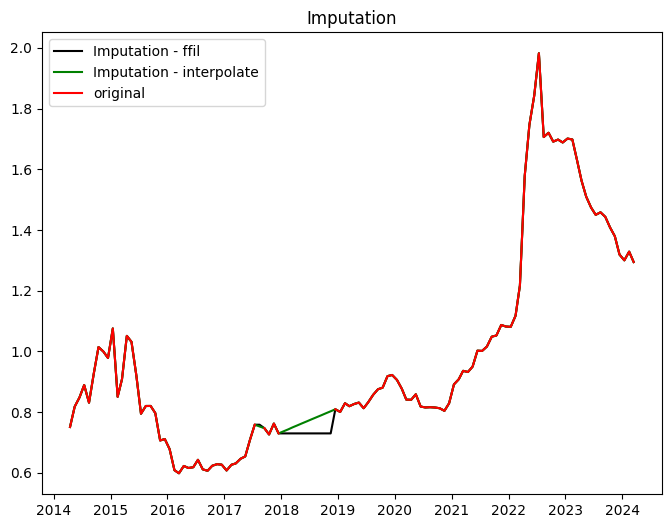

In [7]:
# Create a date range with monthly frequency
all_months = pd.date_range(start=df_Lviv.index.min(), end=df_Lviv.index.max(), freq='MS') +timedelta(days=14)
print(all_months)
# Reindex the DataFrame to include all months in the range
reindexed_df = df_Lviv.reindex(all_months)
# Identify missing months
missing_months = reindexed_df[reindexed_df.isna().all(axis=1)].index
# Append missing months with NaN values
firstrow= df_Lviv.iloc[1]
for month in missing_months:
    reindexed_df.loc[month, ['admin1', 'admin2', 'date', 'date_2', 'latitude', 'longitude', 'commodity', 'unit', 'priceflag', 'pricetype', 'currency', 'market', 'category']] = [firstrow['admin1'], firstrow['admin2'], month.strftime("%Y-%m-%d"), month, firstrow['latitude'], firstrow['longitude'], firstrow['commodity'], firstrow['unit'], firstrow['priceflag'], firstrow['pricetype'], firstrow['currency'], firstrow['market'], firstrow['category']]

plt.rcParams['figure.figsize']=(15,7)
print(f'mean value usd price | {reindexed_df["usdprice"].mean()} ')

reindexed_df['usdprice_ffil']= reindexed_df['usdprice'].ffill()
#ffill() stands for "forward fill".
#This method propagates the last observed non-null value forward until another non-null value is encountered.
#If there are missing values (NaNs) in the 'usdprice' column, they are replaced by the last known value above them in the column.
#This approach is often used in time series data to carry the last known value forward in the absence of new data.



reindexed_df['usdprice_Inter']= reindexed_df['usdprice'].interpolate(option='spline')
#interpolate() is a method used to fill in missing values in a data frame.
#The method='spline' argument specifies that spline interpolation should be used.
#Spline interpolation fits a smooth polynomial curve through the known data points and estimates the missing values along that curve.
#This can provide a more nuanced and smooth estimate of missing values compared to linear interpolation or forward/backward fill methods.

# visualization of two imputation method
fig, ax = plt.subplots(figsize=(8, 6))
plt.plot(reindexed_df['usdprice_ffil'], color='black', label='Imputation - ffil')
plt.plot(reindexed_df['usdprice_Inter'], color='green', label='Imputation - interpolate')
plt.plot(reindexed_df['usdprice'], color='red', label='original')
plt.title('Imputation')
plt.legend()
plt.show()

### 1.2. New indicators for time series

In [8]:
#Lag features with different ranges (1 month, 3, 6 )
reindexed_df['Lag_1'] = reindexed_df['usdprice_Inter'].shift(1)
reindexed_df['Lag_3']= reindexed_df['usdprice_Inter'].shift(3)
reindexed_df['Lag_6']= reindexed_df['usdprice_Inter'].shift(6)


# Rolling Window Statistics
#We can calculate summary statistics across the values in the sliding window and include these as features in our dataset. 
# Perhaps the most useful is the mean of the previous few values, also called the rolling mean.

width = 3 
window = reindexed_df['usdprice_Inter'].rolling(window=width)
reindexed_df['rolling_3_mean']= window.mean()


#Expanding Window Statistics
#Another type of window that may be useful includes all previous data in the series.
#In time series analysis, the expanding window mean is a statistical calculation that computes the mean of a time series over an expanding window of observations. 
# Unlike a rolling window, which uses a fixed-size window of observations, an expanding window includes all observations up to the current time point.

window_exp = reindexed_df['usdprice_Inter'].expanding()
reindexed_df['exp_min'] = window_exp.min()
reindexed_df['exp_max']= window_exp.max()
reindexed_df['exp_mean']=window_exp.mean()



#Exponentially Weighted Functions - Exponentially-weighted moving average

# The ewm() method is typically used to smooth out time series data and to identify long-term trends or patterns. 
# It can be useful in applications such as financial forecasting, trend analysis, and anomaly detection.
#The smoothing parameter alpha determines the rate at which the weights decay, with higher values of alpha giving more weight to recent observations.
#The alpha parameter represents the degree of weight given to more recent observations relative to past observations.
# The alpha parameter can be set using the alpha parameter in the ewm() method in pandas. 
# This parameter takes a float value between 0 and 1, where a value closer to 1 gives more weight to recent observations,
#  and a value closer to 0 gives more weight to past observations.
ewma = reindexed_df['usdprice_Inter'].ewm(alpha=0.3).mean()
reindexed_df['ewma']= ewma

reindexed_df = reindexed_df.replace(np.nan, 0)

reindexed_df.to_csv('Reindexed.csv')

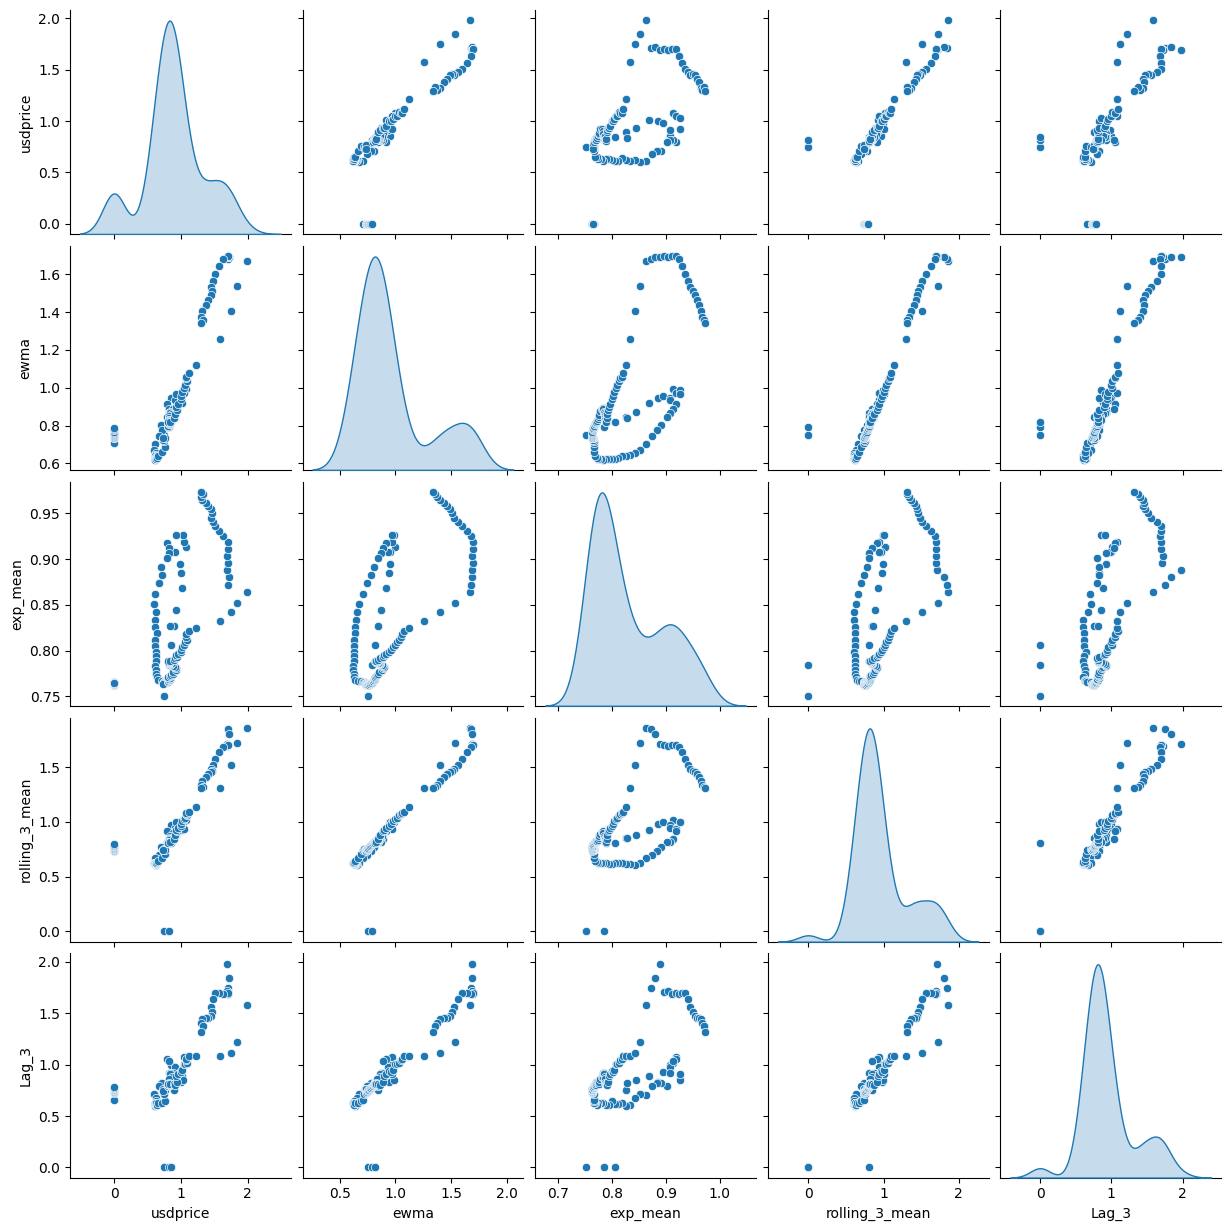

In [9]:
#a grid of scatter plots for pairwise relationships between variables and includes a diagonal showing their distributions
sns.pairplot(reindexed_df[['usdprice', 'ewma', 'exp_mean', 'rolling_3_mean', 'Lag_3']], diag_kind='kde')
#Scatter plots between usdprice and ewma or rolling_3_mean show strong positive linear correlations
#Relationships with others (e.g. exp_mean) could reveal groups of patterns. #see later gordana 

## 2. Simple forecasting methods 

Naive Forecast: The median of the subset of historical data based on offset is used for all future forecasts.
- As a reference, I used Time series Persistence implementation from lectures.  I tested different configuration and the best result is in Section 2.1.. 


In [10]:
# split a univariate dataset into train/test sets
def train_test_split_ts(data, n_test):
  return data[:-n_test], data[-n_test:]


# root mean squared error or rmse
def measure_rmse(actual, predicted):
  return math.sqrt(mean_squared_error(actual, predicted))

# fit a model
def model_fit(train, config):
  return None

# forecast with a pre-fit model
def model_predict_median(model, history, config):
  values = list()
  for offset in config:
    values.append(history[-offset])
  return np.median(values)

# walk-forward validation for univariate data
def walk_forward_validation(data, n_test, cfg):
  predictions = list()
  # split dataset
  train, test = train_test_split_ts(data, n_test)
  # fit model
  model = model_fit(train, cfg)
  # seed history with training dataset
  history = [x for x in train]
  # step over each time-step in the test set
  for i in range(len(test)):
    # fit model and make forecast for history
    yhat = model_predict_median(model, history, cfg)
    # store forecast in list of predictions
    predictions.append(yhat)
    # add actual observation to history for the next loop
    history.append(test[i])
  # estimate prediction error
  error = measure_rmse(test, predictions)
  print(' > %.3f' % error)
  return error

# summarize model performance
def summarize_scores(name, scores):
  # print a summary
  scores_m, score_std = np.mean(scores), np.std(scores)
  print('%s: %.3f RMSE (+/- %.3f)' % (name, scores_m, score_std)) # box and whisker plot


(120, 1)


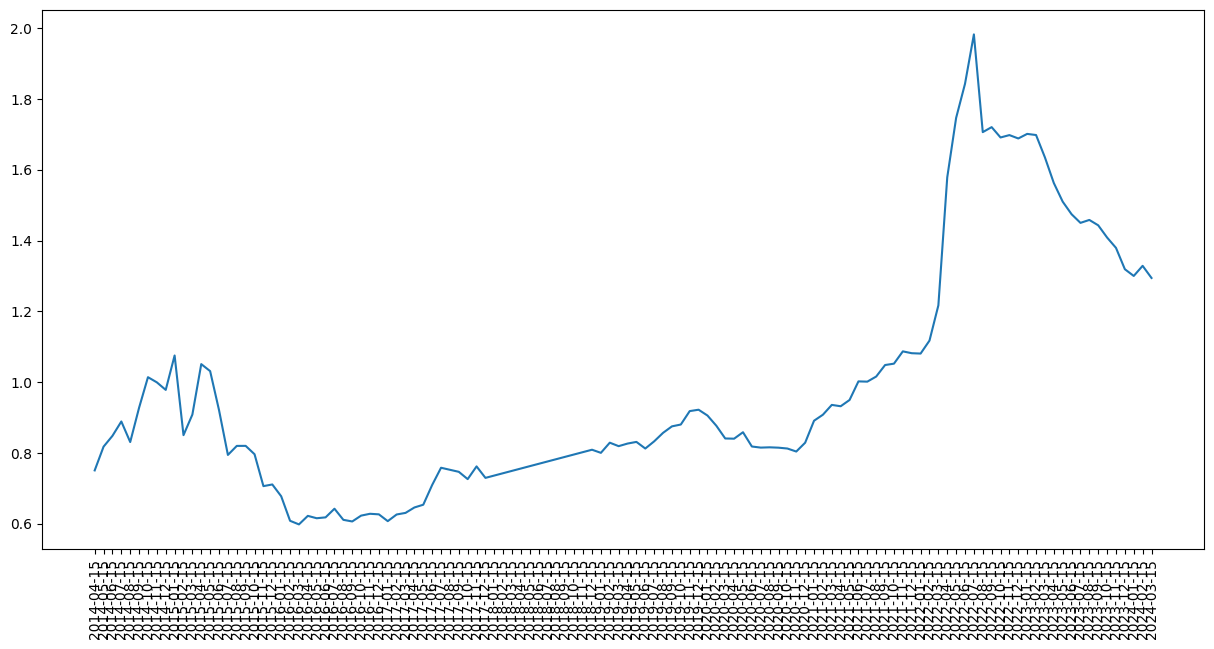

 > 0.178
Naive forecasting: 0.178 RMSE (+/- 0.000)


In [23]:
#Import data saved from section 1 
df = pd.read_csv("Reindexed.csv")
from matplotlib import pyplot
#I'm using only usdprice (univariate time series)
series= df[['date', 'usdprice_Inter']]
series.set_index('date', inplace=True)
data= series.values 
print(data.shape)
pyplot.plot(series)
pyplot.xticks(rotation=90)
pyplot.show()

# data split
n_test = 12
# define config 
config = [3, 6, 12] 
# grid search
scores = walk_forward_validation(data, n_test, config)
# summarize scores
summarize_scores('Naive forecasting', scores)
# Naive forecasting: 0.178 RMSE (+/- 0.000)

### 2.1. Results 

This model achieves an RMSE of 0.178 by calculating the median of prior observations (using three timeframes: the last 3 months, 6 months, and 12 months). The performance of this naive forecast model establishes a baseline, serving as the lower bound for a model to be considered skillful. Since the model is None, there is no variation in the RMSE.

config [3, 6, 12] # Naive model: 0.178 RMSE (+/- 0.000)

## 3. MLP 

This model defines and trains a simple Multi-Layer Perceptron (MLP) with one hidden layer using ReLU activation to predict a target value from a given input sequence. 
- As a reference, I used Time series MLP implementation from lectures.

- Config: [ #n_input: The number of prior inputs to use as input for the model.
#n_nodes: The number of nodes to use in the hidden layer.
#n_epochs: The number of training epochs.
#n_batch: The number of samples to include in each mini-batch. ]


In [24]:
#Import data saved from section 1 
df = pd.read_csv("Reindexed.csv")
from matplotlib import pyplot
series= df[['date', 'usdprice_Inter']]
series.set_index('date', inplace=True)
data= series.values 
print(data.shape)
# Dataset is same as the one used in previous model.

(120, 1)


### Auxilary functions


In [25]:
# split a univariate dataset into train/test sets
def train_test_split_ts(data, n_test):
  return data[:-n_test], data[-n_test:]


In [28]:
# transform list into supervised learning format
def series_to_supervised(data, n_in, n_out=1):
  df = pd.DataFrame(data)
  cols = list()
  # input sequence (t-n, ... t-1)
  for i in range(n_in, 0, -1):
    cols.append(df.shift(i))
  # forecast sequence (t, t+1, ... t+n)
  for i in range(0, n_out):
    cols.append(df.shift(-i))
  # put it all together
  agg = pd.concat(cols, axis=1)
  # drop rows with NaN values
  agg.dropna(inplace=True)
  return agg.values

In [29]:
# root mean squared error or rmse
def measure_rmse(actual, predicted):
  return math.sqrt(sklearn.metrics.mean_squared_error(actual, predicted))

### 3.1. MLP Model Fit and predict 


In [41]:
# fit a model
def model_fit_MLP(train, config):
  # unpack config
  n_input, n_nodes, n_epochs, n_batch = config                                 
  # prepare data
  data = series_to_supervised(train, n_input)                          
  train_x, train_y = data[:, :-1], data[:, -1]
  # define model
  model = Sequential()                                                      
  model.add(Dense(n_nodes, activation='relu', input_dim=n_input))
  model.add(Dense(1))
  model.compile(loss='mse', optimizer='adam')
  # fit
  model.fit(train_x, train_y, epochs=n_epochs, batch_size=n_batch, verbose=0)
  #model.summary()

  return model 

In [36]:
# forecast with a pre-fit model                                                
def model_predict_MLP(model, history, config):
  # unpack config
  n_input, _, _, _ = config                                                    
  # prepare data
  x_input = np.array(history[-n_input:]).reshape(1, n_input)                    
  # forecast
  yhat = model.predict(x_input, verbose=0)
  return yhat[0]

In [37]:
# walk-forward validation for univariate data
def walk_forward_validation_MLP(data, n_test, cfg):
  predictions = list()
  # split dataset
  train, test = train_test_split_ts(data, n_test)
  # fit model
  model = model_fit_MLP(train,  cfg)
  # seed history with training dataset
  history = [x for x in train]
  # step over each time-step in the test set
  for i in range(len(test)):
    # fit model and make forecast for history
    yhat = model_predict_MLP(model, history, cfg)
    # store forecast in list of predictions
    predictions.append(yhat)
    # add actual observation to history for the next loop
    history.append(test[i])
  # estimate prediction error
  error = measure_rmse(test, predictions)
  print(' > %.3f' % error)
  return error

In [38]:
# repeat evaluation of a config
def repeat_evaluate_MLP(data, config, n_test, n_repeats=30):
  # fit and evaluate the model n times
  scores = [walk_forward_validation_MLP(data, n_test, config) for _ in range(n_repeats)]
  return scores

In [39]:
# summarize model performance
def summarize_scores_MLP(name, scores):
  # print a summary
  scores_m, score_std = np.mean(scores), np.std(scores)
  print('%s: %.3f RMSE (+/- %.3f)' % (name, scores_m, score_std)) 
  # box and whisker plot
  pyplot.boxplot(scores)
  pyplot.show()

c:\Users\Kaidrin\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning:

Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.



 > 0.071


c:\Users\Kaidrin\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning:

Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.



 > 0.119


c:\Users\Kaidrin\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning:

Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.



 > 0.094


c:\Users\Kaidrin\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning:

Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.



 > 0.121


c:\Users\Kaidrin\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning:

Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.



 > 0.147


c:\Users\Kaidrin\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning:

Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.



 > 0.070


c:\Users\Kaidrin\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning:

Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.



 > 0.081


c:\Users\Kaidrin\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning:

Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.



 > 0.147


c:\Users\Kaidrin\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning:

Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.



 > 0.190


c:\Users\Kaidrin\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning:

Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.



 > 0.108


c:\Users\Kaidrin\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning:

Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.



 > 0.081


c:\Users\Kaidrin\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning:

Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.



 > 0.068


c:\Users\Kaidrin\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning:

Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.



 > 0.062


c:\Users\Kaidrin\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning:

Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.



 > 0.076


c:\Users\Kaidrin\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning:

Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.



 > 0.065


c:\Users\Kaidrin\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning:

Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.



 > 0.073


c:\Users\Kaidrin\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning:

Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.



 > 0.087


c:\Users\Kaidrin\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning:

Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.



 > 0.099


c:\Users\Kaidrin\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning:

Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.



 > 0.146


c:\Users\Kaidrin\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning:

Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.



 > 0.095


c:\Users\Kaidrin\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning:

Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.



 > 0.051


c:\Users\Kaidrin\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning:

Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.



 > 0.056


c:\Users\Kaidrin\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning:

Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.



 > 0.063


c:\Users\Kaidrin\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning:

Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.



 > 0.073


c:\Users\Kaidrin\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning:

Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.



 > 0.051


c:\Users\Kaidrin\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning:

Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.



 > 0.039


c:\Users\Kaidrin\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning:

Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.



 > 0.041


c:\Users\Kaidrin\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning:

Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.



 > 0.054


c:\Users\Kaidrin\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning:

Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.



 > 0.091


c:\Users\Kaidrin\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning:

Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.



 > 0.038
MLP: 0.085 RMSE (+/- 0.036)


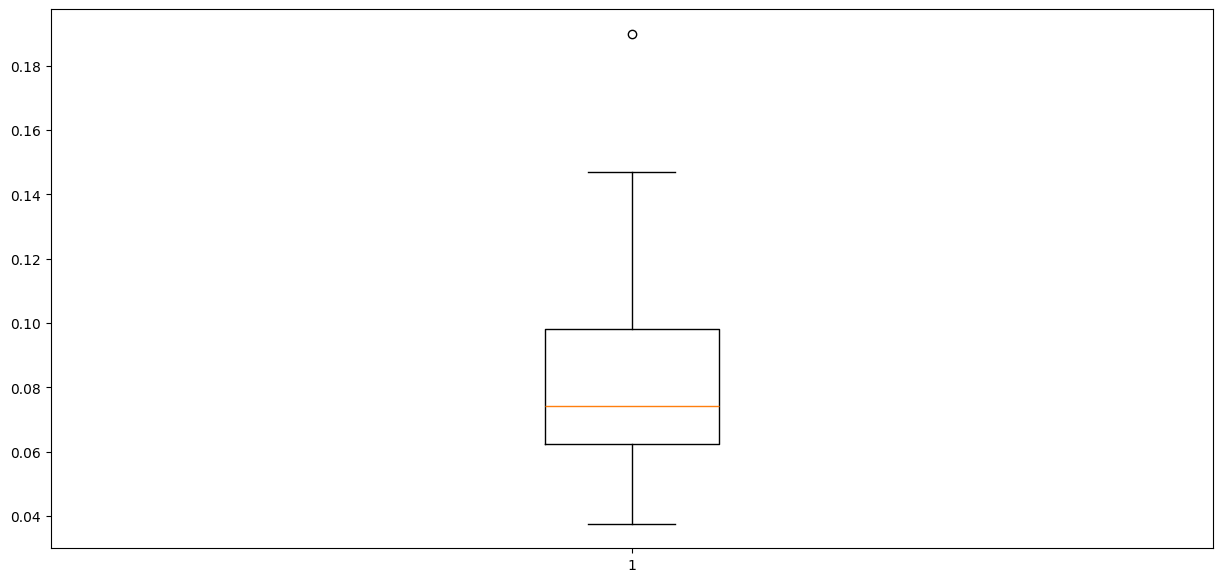

In [ ]:
# data split
n_test = 12
# define config
config = [6, 50, 10, 4] 
scores = repeat_evaluate_MLP(data, config, n_test) 
# summarize scores
summarize_scores_MLP('MLP', scores) 


### 3.2. Results 

This model achieves an RMSE of 0.085, outperforming naive forecasting. Unlike naive forecasting, this model transforms input features by incorporating multiple prior time-step observations (referred to as "lag observations"). In this case, n_input is set to 6 (as specified in the configuration), which means last 6 values are used to predict one step ahead. 


#[6, 50, 10, 4] # MLP: 0.085 RMSE (+/- 0.036)


## 4. LSTM Model 
- As a reference, I used LSTM implementation from lectures (Section 4.1)
- Implemented Grid search to find optimal parameters (Section 4.2.)
- Implemented visualization of the optimal prediction  (Section 4.3.)

 All analysis are done using three experiments: 
 For all three experiments, dataset from section 1 of 120 samples was split into three segemets : 
 train, 
 predict (validation set), 
 unseen data (benchmark set)

 Experiment 1: 
    - Network architecture called basic (1 LSTM layer with relu activation function, 1 Dense and output layer, optimizer function is adam )
Experiment 2 : 
    -  Network architecture called advanced (2 LSTM layers with tanh activation function and output layer, optimizer function is adam )
Experiment 3 : 
    -  Network architecture called advanced (2 LSTM layers with relu function and output layer, optimizer function is adam )
- All three experiments were runned multiple times to show box plot of stochastic changes of the model parameteres ( see Section 4.1)

In [70]:
# root mean squared error or rmse
def measure_rmse_LSTM(actual, predicted):
  return sqrt(mean_squared_error(actual, predicted))
#Splitting the dataset into train, validation,test 
def train_test_validate_split(data, n_predict=10, n_unseen= 10):
  total =n_predict+n_unseen
  data_train= data[: -total]
  data_predict=  data[-total:-n_predict]
  data_test= data[-n_unseen: ]
  return data_train, data_predict, data_test


In [71]:
def plot_learing_curve(history):
    # Plot learning curve
    plt.figure(figsize=(10, 6))
    plt.plot(history.history['loss'],  label='Training Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title('Learning Curve')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid()
    plt.show()

In [72]:
# difference dataset                                                            
def difference(data, interval):
  return [data[i] - data[i - interval]  for i in range(interval, len(data))]

(120, 1)


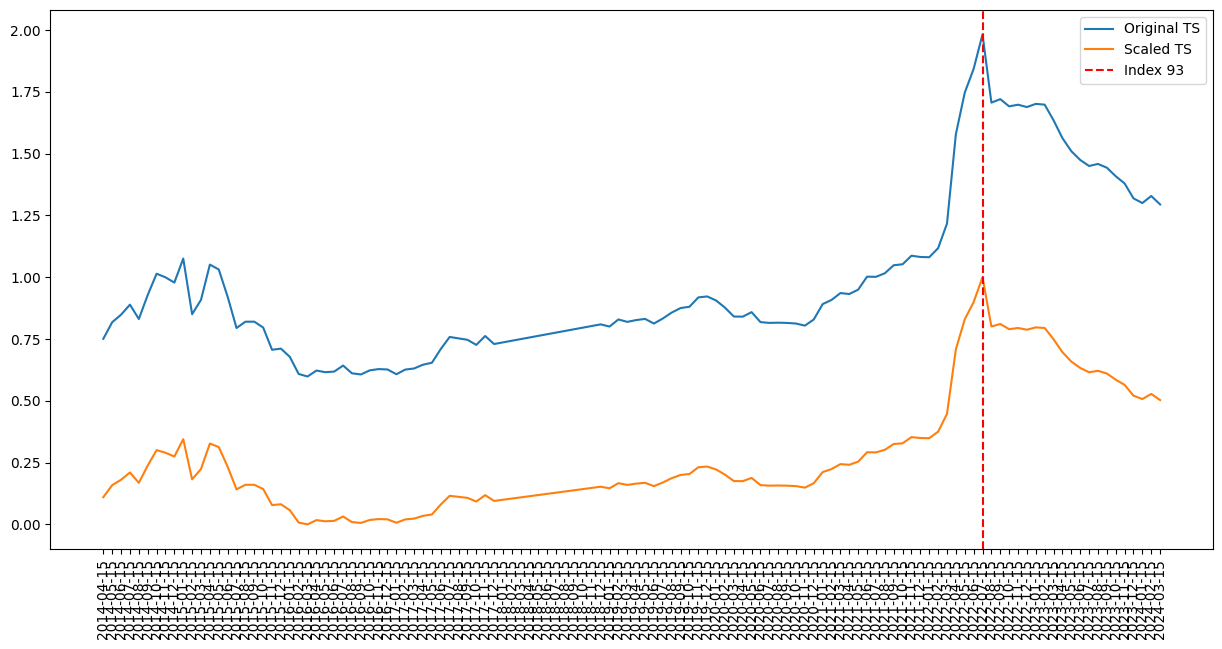

In [ ]:

# Import data saved from Section 1
df = pd.read_csv("Reindexed.csv")
# Prepare the series
series = df[['date', 'usdprice_Inter']]
series.set_index('date', inplace=True)
data = series.values
print(data.shape)
# scale data that is used in Section 4.4
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_series = scaler.fit_transform(data.reshape(-1, 1))
# Plotted original time series (blue) and scaled (orange).  
pyplot.plot(series, label='Original TS')
pyplot.xticks(rotation=90)
pyplot.plot(scaled_series, label='Scaled TS')
# Draw a vertical line at index 93 which shows the crisis peak 
pyplot.axvline(x=series.index[99], color='red', linestyle='--', label='Index 93')
# Add legend for clarity
pyplot.legend()
#Show plot
pyplot.show()

### 4.1. LSTM Model fit and predict

- All three experiments were runned multiple times to show box plot of stochastic changes of the model parameteres. 

- Config: [ #n_input: The number of prior inputs to use as input for the model (e.g. 12 months).

    #n_nodes: The number of nodes to use in the hidden layer (e.g. 50).

    #n_epochs: The number of training epochs (e.g. 1000).

    #n_batch: The number of samples to include in each mini-batch (e.g. 32).

    #n_diff: The difference order (e.g. 0 or 12).]

In [74]:
# fit a model
def model_fit_LSTM(train, config):
  # unpack config
  n_input, n_nodes, n_epochs, n_batch, n_diff = config                          
  # prepare data                                                     
  if n_diff > 0:
    train = difference(train, n_diff)                                           
  data = series_to_supervised(train, n_input)
  train_x, train_y = data[:, :-1], data[:, -1]
  train_x = train_x.reshape((train_x.shape[0], train_x.shape[1], 1))
  # define model
  model = Sequential()                                                          
  model.add(LSTM(n_nodes, activation='relu', input_shape=(n_input, 1)))
  model.add(Dense(n_nodes, activation='relu'))
  model.add(Dense(1))
  model.compile(loss='mse', optimizer='adam')
  # fit
  model.fit(train_x, train_y, epochs=n_epochs, batch_size=n_batch, verbose=0)
  
  return model


# Fit an LSTM model with validation and learning curve
def model_fit_LSTM_with_validation(train, config, ind_model, ind_plotcurve):
    # Unpack configuration
    n_input, n_nodes, n_epochs, n_batch, n_diff = config
 
    # Prepare data
    if n_diff > 0:
        train = difference(train, n_diff)  # Apply differencing if specified
    data = series_to_supervised(train, n_input)

    train_x, train_y = data[:, :-1], data[:, -1]
    train_x = train_x.reshape((train_x.shape[0], train_x.shape[1], 1))
    n_validation= train_x.shape[0] - 6

    # Split into training and validation sets
    X_train, y_train = train_x[:n_validation, :], train_y[:n_validation]
    X_valid, y_valid = train_x[n_validation:, :], train_y[n_validation:]

    # experiment 1 model architecture 
    if (ind_model==1):
       # Define model
      model = Sequential()
      model.add(LSTM(n_nodes, activation='relu', input_shape=(n_input, 1),  kernel_regularizer=l2(0.01), recurrent_regularizer=l2(0.01)))
      model.add(Dropout(0.2))
      model.add(Dense(n_nodes, activation='relu', kernel_regularizer=l2(0.01)))
      model.add(Dropout(0.2))
      model.add(Dense(1))
      model.compile(loss='mse', optimizer='adam')
      # Fit model and record history for learning curve
      history = model.fit( X_train , y_train, 
                        validation_data=(X_valid, y_valid), 
                        epochs=n_epochs, 
                        batch_size=n_batch, 
                        verbose=0)
    #experiment 2 model architecture 
    elif ind_model==2:
      model = Sequential()                                                        
      model.add(LSTM(n_nodes, activation='tanh', return_sequences=True,  input_shape=(n_input, 1), kernel_regularizer=l2(0.01), recurrent_regularizer=l2(0.01)))
      model.add(Dropout(0.2))
      model.add(LSTM(n_nodes, activation='tanh', kernel_regularizer=l2(0.01), recurrent_regularizer=l2(0.01), return_sequences=False))
      model.add(Dropout(0.2))
      model.add(Dense(1))
      model.compile(loss='mse', optimizer='adam')
      # fit
      history = model.fit( X_train , y_train, 
                        validation_data=(X_valid, y_valid), 
                        epochs=n_epochs, 
                        batch_size=n_batch, 
                        verbose=1)
      
    #experiment 3 model architecture 
    else: 
      model = Sequential()                                                          
      model.add(LSTM(n_nodes, activation='relu', return_sequences=True,  input_shape=(n_input, 1), kernel_regularizer=l2(0.01), recurrent_regularizer=l2(0.01)))
      model.add(Dropout(0.2))
      model.add(LSTM(n_nodes, activation='relu', kernel_regularizer=l2(0.01), recurrent_regularizer=l2(0.01), return_sequences=False))
      model.add(Dropout(0.2))
      model.add(Dense(1))
      model.compile(loss='mse', optimizer='adam')
      # fit
      history = model.fit( X_train , y_train, 
                        validation_data=(X_valid, y_valid), 
                        epochs=n_epochs, 
                        batch_size=n_batch, 
                        verbose=1)
    if ind_plotcurve==True:
      plot_learing_curve(history)
    return model 


In [75]:
# forecast with a pre-fit model
def model_predict_LSTM(model, history, config):
  # unpack config
  n_input, _, _, _, n_diff = config                                             
  # prepare data
  correction = 0.0                                                             
  if n_diff > 0:                                                                
    correction = history[-n_diff]                                              
    history = difference(history, n_diff)  
  x_input = np.array(history[-n_input:]).reshape((1, n_input, 1))  
  # forecast
  yhat = model.predict(x_input, verbose=0)

  return correction + yhat[0]

In [76]:
# walk-forward validation for univariate data
def walk_forward_validation_LSTM(data, n_test, cfg,  ind_model, ind_plotcurve):
  predictions = []
  # split dataset
  train, predict, unseen  = train_test_validate_split(data, n_test)
  # fit model
  model = model_fit_LSTM_with_validation(train, cfg, ind_model, ind_plotcurve)
  # seed history with training dataset
  history = [x for x in train]
  test_ls= [x for x in predict]
  # step over each time-step in the validation set
  for i in range(len(predict)):
    # fit model and make forecast for history
    yhat = model_predict_LSTM(model, history, cfg)
    # store forecast in list of predictions
    predictions.append(yhat)
    # add actual observation to history for the next loop
    history.append(predict[i])
  # estimate prediction error
  error = measure_rmse_LSTM(test_ls, predictions)
  print(' > %.3f' % error)
  return error 

In [77]:
# repeat evaluation of a config
def repeat_evaluate_LSTM(data, n_test, config,  ind_model, ind_plotcurve, n_repeats=30):
  # fit and evaluate the model n times
  scores = [walk_forward_validation_LSTM(data, n_test, config, ind_model, ind_plotcurve) for _ in range(n_repeats)]
  return scores



In [78]:
# summarize model performance
def summarize_scores(name, scores):
  # print a summary
  scores_m, score_std = np.mean(scores), np.std(scores)
  print('%s: %.3f RMSE (+/- %.3f)' % (name, scores_m, score_std)) # box and whisker plot
  pyplot.boxplot(scores)
  pyplot.show()

#### Experiment 1 

data (120, 1)


c:\Users\Kaidrin\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning:

Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.



 > 0.129


c:\Users\Kaidrin\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning:

Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.



 > 0.129


c:\Users\Kaidrin\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning:

Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.



 > 0.128


c:\Users\Kaidrin\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning:

Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.



 > 0.130


c:\Users\Kaidrin\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning:

Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.



 > 0.132


c:\Users\Kaidrin\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning:

Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.



 > 0.130


c:\Users\Kaidrin\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning:

Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.



 > 0.134


c:\Users\Kaidrin\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning:

Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.



 > 0.130


c:\Users\Kaidrin\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning:

Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.



 > 0.128


c:\Users\Kaidrin\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning:

Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.



 > 0.130
[0.1294361840601783, 0.1289218968673877, 0.12783728501147235, 0.13017208419991835, 0.13234546719591866, 0.12958003328627204, 0.1340262858103006, 0.1297723423290935, 0.1278490214859509, 0.1302487816589927]
LSTM RMSE Experiment 1 -: 0.130 RMSE (+/- 0.002)


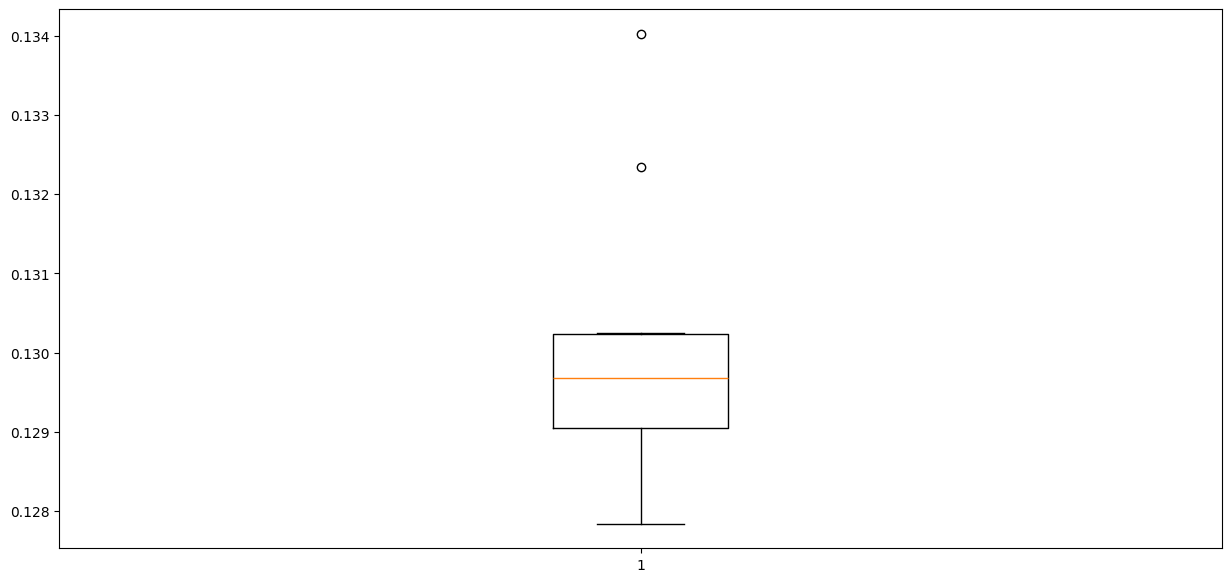

In [79]:
df = pd.read_csv("Reindexed.csv")
series= df[['date', 'usdprice_Inter']]
series.set_index('date', inplace=True)
data= series.values 
print('data', data.shape)
# data split
n_test = 10
# define config                                                
config = [6, 50, 10, 4 , 3] 

ind_model= 1 # # indicator for the model (1 - exp 1, 2- exp 2, 3 - exp 3 ) 
ind_plotcurve= False # T/F indicator for ploting learning curve  

scores = repeat_evaluate_LSTM(data,  n_test, config,  ind_model, ind_plotcurve, 10)
print(scores)
# summarize scores
summarize_scores(f'LSTM RMSE Experiment {ind_model} -', scores)


#### Experiment 2


data (120, 1)
Epoch 1/10


c:\Users\Kaidrin\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning:

Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.



22/22 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 1.6400 - val_loss: 1.3378
Epoch 2/10
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 1.0086 - val_loss: 0.8849
Epoch 3/10
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.6103 - val_loss: 0.6096
Epoch 4/10
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.3679 - val_loss: 0.4437
Epoch 5/10
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.2201 - val_loss: 0.3466
Epoch 6/10
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.1308 - val_loss: 0.2877
Epoch 7/10
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0786 - val_loss: 0.2464
Epoch 8/10
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0479 - val_loss: 0.2253
Epoch 9/10
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0287 - val_loss: 0.2198
Epoch 10/10
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0177 - val_loss: 0.2094
 > 0.129
Epoch 1/10


c:\Users\Kaidrin\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning:

Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.



22/22 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 1.6449 - val_loss: 1.3360
Epoch 2/10
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 1.0087 - val_loss: 0.8799
Epoch 3/10
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.6100 - val_loss: 0.6097
Epoch 4/10
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.3661 - val_loss: 0.4459
Epoch 5/10
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.2198 - val_loss: 0.3422
Epoch 6/10
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.1294 - val_loss: 0.2876
Epoch 7/10
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0784 - val_loss: 0.2521
Epoch 8/10
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0463 - val_loss: 0.2263
Epoch 9/10
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0292 - val_loss: 0.2181
Epoch 10/10
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0182 - val_loss: 0.2114
 > 0.127
Epoch 1/10


c:\Users\Kaidrin\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning:

Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.



22/22 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 1.6243 - val_loss: 1.2984
Epoch 2/10
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.9952 - val_loss: 0.8688
Epoch 3/10
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.5995 - val_loss: 0.5967
Epoch 4/10
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.3606 - val_loss: 0.4331
Epoch 5/10
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.2155 - val_loss: 0.3439
Epoch 6/10
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.1286 - val_loss: 0.2788
Epoch 7/10
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0768 - val_loss: 0.2487
Epoch 8/10
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0462 - val_loss: 0.2254
Epoch 9/10
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0282 - val_loss: 0.2192
Epoch 10/10
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0193 - val_loss: 0.2090
 > 0.129
Epoch 1/10


c:\Users\Kaidrin\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning:

Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.



22/22 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 1.6171 - val_loss: 1.2989
Epoch 2/10
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.9926 - val_loss: 0.8609
Epoch 3/10
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.5968 - val_loss: 0.6028
Epoch 4/10
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.3588 - val_loss: 0.4284
Epoch 5/10
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.2142 - val_loss: 0.3451
Epoch 6/10
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.1296 - val_loss: 0.2834
Epoch 7/10
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0773 - val_loss: 0.2499
Epoch 8/10
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0469 - val_loss: 0.2280
Epoch 9/10
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0287 - val_loss: 0.2195
Epoch 10/10
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0181 - val_loss: 0.2128
 > 0.126
Epoch 1/10


c:\Users\Kaidrin\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning:

Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.



22/22 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 1.6404 - val_loss: 1.3348
Epoch 2/10
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 1.0099 - val_loss: 0.8826
Epoch 3/10
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.6125 - val_loss: 0.6054
Epoch 4/10
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.3717 - val_loss: 0.4386
Epoch 5/10
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.2232 - val_loss: 0.3477
Epoch 6/10
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.1309 - val_loss: 0.2824
Epoch 7/10
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0800 - val_loss: 0.2529
Epoch 8/10
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0484 - val_loss: 0.2246
Epoch 9/10
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0329 - val_loss: 0.2144
Epoch 10/10
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0204 - val_loss: 0.2104
 > 0.128
Epoch 1/10


c:\Users\Kaidrin\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning:

Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.



22/22 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - loss: 1.6346 - val_loss: 1.3164
Epoch 2/10
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 1.0045 - val_loss: 0.8794
Epoch 3/10
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.6075 - val_loss: 0.6066
Epoch 4/10
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.3665 - val_loss: 0.4397
Epoch 5/10
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.2172 - val_loss: 0.3412
Epoch 6/10
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.1296 - val_loss: 0.2851
Epoch 7/10
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0769 - val_loss: 0.2502
Epoch 8/10
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0465 - val_loss: 0.2288
Epoch 9/10
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0296 - val_loss: 0.2102
Epoch 10/10
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0183 - val_loss: 0.2122
 > 0.126
Epoch 1/10


c:\Users\Kaidrin\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning:

Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.



22/22 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 1.6323 - val_loss: 1.3124
Epoch 2/10
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 1.0008 - val_loss: 0.8768
Epoch 3/10
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.6048 - val_loss: 0.6063
Epoch 4/10
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.3634 - val_loss: 0.4430
Epoch 5/10
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.2192 - val_loss: 0.3406
Epoch 6/10
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.1289 - val_loss: 0.2858
Epoch 7/10
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0778 - val_loss: 0.2464
Epoch 8/10
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0463 - val_loss: 0.2283
Epoch 9/10
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0283 - val_loss: 0.2190
Epoch 10/10
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0189 - val_loss: 0.2107
 > 0.128
Epoch 1/10


c:\Users\Kaidrin\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning:

Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.



22/22 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 1.6237 - val_loss: 1.2996
Epoch 2/10
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.9983 - val_loss: 0.8808
Epoch 3/10
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.6063 - val_loss: 0.6036
Epoch 4/10
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.3624 - val_loss: 0.4427
Epoch 5/10
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.2177 - val_loss: 0.3430
Epoch 6/10
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.1310 - val_loss: 0.2791
Epoch 7/10
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0779 - val_loss: 0.2558
Epoch 8/10
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0490 - val_loss: 0.2226
Epoch 9/10
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0300 - val_loss: 0.2183
Epoch 10/10
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0187 - val_loss: 0.2063
 > 0.132
Epoch 1/10


c:\Users\Kaidrin\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning:

Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.



22/22 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 1.6189 - val_loss: 1.3229
Epoch 2/10
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.9938 - val_loss: 0.8714
Epoch 3/10
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.6021 - val_loss: 0.6081
Epoch 4/10
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.3629 - val_loss: 0.4428
Epoch 5/10
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.2165 - val_loss: 0.3468
Epoch 6/10
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.1292 - val_loss: 0.2849
Epoch 7/10
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0772 - val_loss: 0.2494
Epoch 8/10
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0481 - val_loss: 0.2297
Epoch 9/10
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0312 - val_loss: 0.2196
Epoch 10/10
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0188 - val_loss: 0.2051
 > 0.133
Epoch 1/10


c:\Users\Kaidrin\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning:

Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.



22/22 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - loss: 1.6324 - val_loss: 1.3113
Epoch 2/10
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 1.0035 - val_loss: 0.8825
Epoch 3/10
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.6091 - val_loss: 0.6063
Epoch 4/10
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.3649 - val_loss: 0.4484
Epoch 5/10
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.2202 - val_loss: 0.3405
Epoch 6/10
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.1314 - val_loss: 0.2824
Epoch 7/10
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0788 - val_loss: 0.2562
Epoch 8/10
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0471 - val_loss: 0.2257
Epoch 9/10
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0294 - val_loss: 0.2239
Epoch 10/10
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0196 - val_loss: 0.2093
 > 0.129
[0.12892401258266384, 0.12691597448535333, 0.1289511618559648, 0.1259801025778787, 0.12847318239621439, 0.12627635294480727, 0.12767130413028033, 0.131993680955

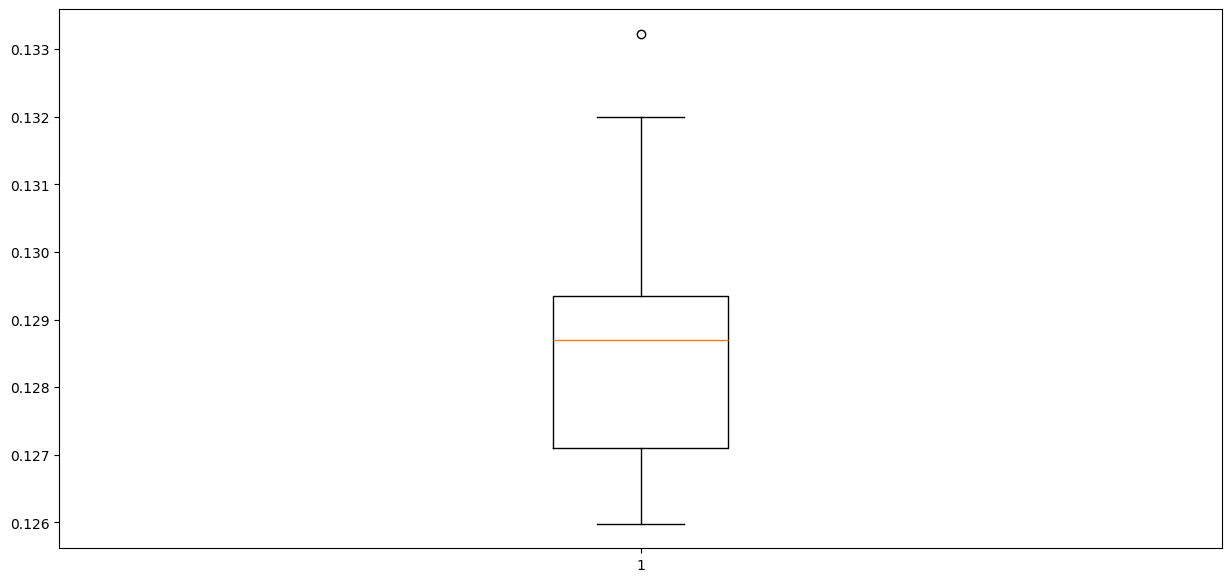

In [80]:
df = pd.read_csv("Reindexed.csv")
series= df[['date', 'usdprice_Inter']]
series.set_index('date', inplace=True)
data= series.values 
print('data', data.shape)
# data split
n_test = 10                                            
config = [6, 50, 10, 4 , 3]
ind_model= 2 # # indicator for the model (1 - exp 1, 2- exp 2, 3 - exp 3 ) 
ind_plotcurve= False #  T/F indicator for ploting learning curve 
scores = repeat_evaluate_LSTM(data,  n_test, config,  ind_model, ind_plotcurve, 10)
print(scores)
# summarize scores
summarize_scores(f'LSTM RMSE Experiment {ind_model} -', scores)

#### Experiment 3 


data (120, 1)
Epoch 1/10


c:\Users\Kaidrin\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning:

Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.



22/22 ━━━━━━━━━━━━━━━━━━━━ 2s 12ms/step - loss: 1.6359 - val_loss: 1.3233
Epoch 2/10
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 1.0035 - val_loss: 0.8794
Epoch 3/10
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.6059 - val_loss: 0.6075
Epoch 4/10
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.3664 - val_loss: 0.4423
Epoch 5/10
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.2178 - val_loss: 0.3422
Epoch 6/10
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.1307 - val_loss: 0.2808
Epoch 7/10
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0778 - val_loss: 0.2477
Epoch 8/10
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0458 - val_loss: 0.2284
Epoch 9/10
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0278 - val_loss: 0.2151
Epoch 10/10
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0178 - val_loss: 0.2096
 > 0.128
Epoch 1/10


c:\Users\Kaidrin\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning:

Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.



22/22 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 1.6293 - val_loss: 1.3195
Epoch 2/10
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 1.0025 - val_loss: 0.8755
Epoch 3/10
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.6043 - val_loss: 0.6074
Epoch 4/10
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.3633 - val_loss: 0.4390
Epoch 5/10
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.2177 - val_loss: 0.3412
Epoch 6/10
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.1295 - val_loss: 0.2825
Epoch 7/10
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0779 - val_loss: 0.2477
Epoch 8/10
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0456 - val_loss: 0.2285
Epoch 9/10
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0295 - val_loss: 0.2222
Epoch 10/10
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0180 - val_loss: 0.2115
 > 0.127
Epoch 1/10


c:\Users\Kaidrin\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning:

Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.



22/22 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - loss: 1.6238 - val_loss: 1.3114
Epoch 2/10
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.9982 - val_loss: 0.8736
Epoch 3/10
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.6027 - val_loss: 0.6013
Epoch 4/10
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.3627 - val_loss: 0.4434
Epoch 5/10
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.2171 - val_loss: 0.3422
Epoch 6/10
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.1304 - val_loss: 0.2793
Epoch 7/10
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0805 - val_loss: 0.2550
Epoch 8/10
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0467 - val_loss: 0.2286
Epoch 9/10
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0291 - val_loss: 0.2172
Epoch 10/10
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0170 - val_loss: 0.2063
 > 0.132
Epoch 1/10


c:\Users\Kaidrin\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning:

Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.



22/22 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 1.6193 - val_loss: 1.3112
Epoch 2/10
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.9937 - val_loss: 0.8683
Epoch 3/10
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.5988 - val_loss: 0.5966
Epoch 4/10
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.3587 - val_loss: 0.4401
Epoch 5/10
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.2143 - val_loss: 0.3441
Epoch 6/10
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.1271 - val_loss: 0.2824
Epoch 7/10
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0765 - val_loss: 0.2466
Epoch 8/10
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0459 - val_loss: 0.2285
Epoch 9/10
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0274 - val_loss: 0.2141
Epoch 10/10
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0174 - val_loss: 0.2104
 > 0.128
Epoch 1/10


c:\Users\Kaidrin\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning:

Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.



22/22 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - loss: 1.6314 - val_loss: 1.3271
Epoch 2/10
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 1.0026 - val_loss: 0.8766
Epoch 3/10
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.6061 - val_loss: 0.6075
Epoch 4/10
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.3655 - val_loss: 0.4421
Epoch 5/10
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.2191 - val_loss: 0.3484
Epoch 6/10
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.1315 - val_loss: 0.2849
Epoch 7/10
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0796 - val_loss: 0.2489
Epoch 8/10
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0479 - val_loss: 0.2346
Epoch 9/10
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0303 - val_loss: 0.2186
Epoch 10/10
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0190 - val_loss: 0.2113
 > 0.128
Epoch 1/10


c:\Users\Kaidrin\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning:

Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.



22/22 ━━━━━━━━━━━━━━━━━━━━ 2s 12ms/step - loss: 1.6432 - val_loss: 1.3306
Epoch 2/10
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 1.0105 - val_loss: 0.8838
Epoch 3/10
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.6130 - val_loss: 0.6149
Epoch 4/10
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.3714 - val_loss: 0.4462
Epoch 5/10
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.2235 - val_loss: 0.3448
Epoch 6/10
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.1321 - val_loss: 0.2822
Epoch 7/10
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0808 - val_loss: 0.2520
Epoch 8/10
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0490 - val_loss: 0.2295
Epoch 9/10
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0293 - val_loss: 0.2156
Epoch 10/10
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0179 - val_loss: 0.2087
 > 0.130
Epoch 1/10


c:\Users\Kaidrin\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning:

Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.



22/22 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 1.6280 - val_loss: 1.3186
Epoch 2/10
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 1.0012 - val_loss: 0.8815
Epoch 3/10
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.6061 - val_loss: 0.6081
Epoch 4/10
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.3654 - val_loss: 0.4398
Epoch 5/10
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.2181 - val_loss: 0.3436
Epoch 6/10
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.1306 - val_loss: 0.2853
Epoch 7/10
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0797 - val_loss: 0.2504
Epoch 8/10
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0472 - val_loss: 0.2277
Epoch 9/10
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0277 - val_loss: 0.2150
Epoch 10/10
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0184 - val_loss: 0.2115
 > 0.127
Epoch 1/10


c:\Users\Kaidrin\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning:

Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.



22/22 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 1.6278 - val_loss: 1.3151
Epoch 2/10
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.9953 - val_loss: 0.8739
Epoch 3/10
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.6001 - val_loss: 0.6062
Epoch 4/10
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.3612 - val_loss: 0.4383
Epoch 5/10
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.2155 - val_loss: 0.3410
Epoch 6/10
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.1289 - val_loss: 0.2821
Epoch 7/10
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0766 - val_loss: 0.2456
Epoch 8/10
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0456 - val_loss: 0.2292
Epoch 9/10
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0287 - val_loss: 0.2138
Epoch 10/10
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0182 - val_loss: 0.2070
 > 0.131
Epoch 1/10


c:\Users\Kaidrin\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning:

Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.



22/22 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - loss: 1.6313 - val_loss: 1.3208
Epoch 2/10
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 1.0015 - val_loss: 0.8817
Epoch 3/10
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.6087 - val_loss: 0.6120
Epoch 4/10
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.3661 - val_loss: 0.4429
Epoch 5/10
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.2192 - val_loss: 0.3481
Epoch 6/10
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.1331 - val_loss: 0.2876
Epoch 7/10
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0798 - val_loss: 0.2465
Epoch 8/10
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0483 - val_loss: 0.2282
Epoch 9/10
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0301 - val_loss: 0.2171
Epoch 10/10
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0184 - val_loss: 0.2140
 > 0.125
Epoch 1/10


c:\Users\Kaidrin\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning:

Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.



22/22 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 1.6145 - val_loss: 1.3040
Epoch 2/10
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.9890 - val_loss: 0.8664
Epoch 3/10
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.5970 - val_loss: 0.5990
Epoch 4/10
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.3585 - val_loss: 0.4363
Epoch 5/10
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.2159 - val_loss: 0.3420
Epoch 6/10
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.1296 - val_loss: 0.2810
Epoch 7/10
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0773 - val_loss: 0.2532
Epoch 8/10
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0482 - val_loss: 0.2245
Epoch 9/10
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0282 - val_loss: 0.2141
Epoch 10/10
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0188 - val_loss: 0.2124
 > 0.126
[0.12836953588281969, 0.12679679158930318, 0.13179559521022727, 0.12756364249037325, 0.12761795994336253, 0.1298161448106815, 0.12708082578472824, 0.13071402848

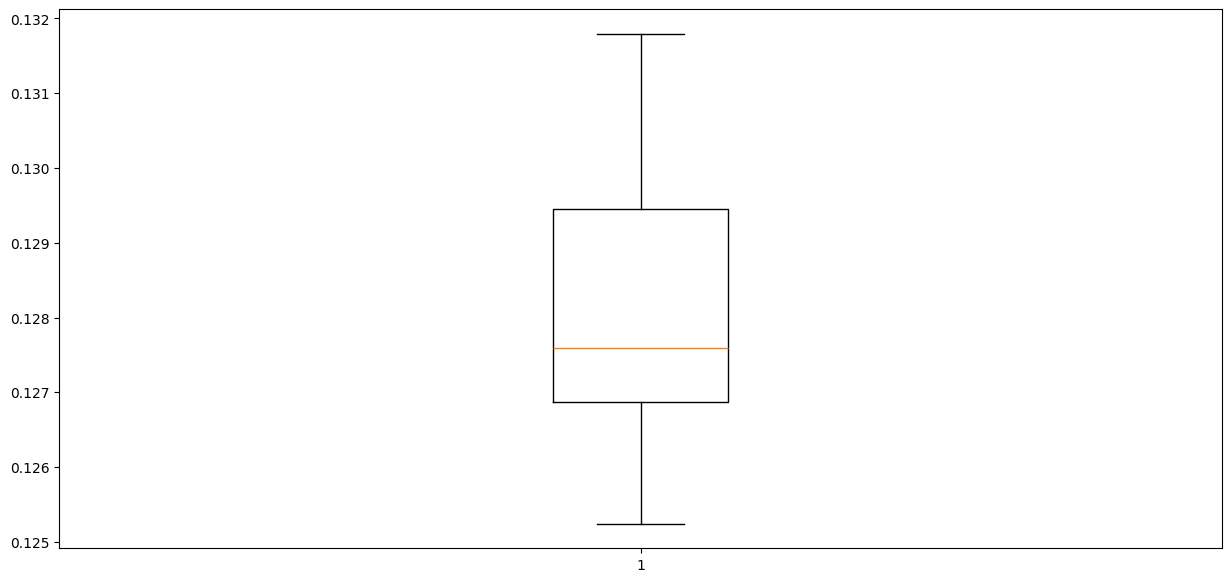

In [105]:
df = pd.read_csv("Reindexed.csv")
series= df[['date', 'usdprice_Inter']]
series.set_index('date', inplace=True)
data= series.values 
print('data', data.shape)
# data split
n_test = 10                                            
config = [6, 50, 10, 4 , 3]
ind_model= 3 # # indicator for the model (1 - exp 1, 2- exp 2, 3 - exp 3 ) 
ind_plotcurve= False #  T/F indicator for ploting learning curve 
scores = repeat_evaluate_LSTM(data,  n_test, config,  ind_model, ind_plotcurve, 10)
print(scores)
# summarize scores
summarize_scores(f'LSTM RMSE Experiment {ind_model} -', scores)

### 4.2. Grid Search 
To evaluate a range of hyperparameters for LSTMs, I implemented grid search approach. 

The grid search model was evaluated on the validation set.
 
The benchmark set (unseen data) was left behind so that after finding optimal parameters for our model, we can test true performance (how well model generalize). 



In [61]:
def model_configs():
	# define ranges of configs that was tested
	n_input = [3, 4, 6, 12]
	n_nodes = [15, 30, 50]
	n_epochs = [10]
	n_batch = [3, 4, 6]
	n_diff = [3, 4, 6]
	# create configs
	configs = list()
	for i in n_input:
		for j in n_nodes:
			for k in n_epochs:
				for l in n_batch:
					for m in n_diff:
						cfg = [i, j, k, l, m]
						configs.append(cfg)
	print('Total configs: %d' % len(configs))
	return configs

In [84]:

# score a model, return None on failure
def repeat_evaluate_LSTM_grid(data,  n_test, config, ind_model, ind_plotcurve, n_repeats=1):
	# fit and evaluate the model n times
	scores = [walk_forward_validation_LSTM(data, n_test, config, ind_model, ind_plotcurve,) for _ in range(n_repeats)]
	# summarize score
	result =np.mean(scores)
	print('> Model[%s] %.3f' % (config, result))
	return (config, result)

# grid search configs
def grid_search(data, n_test, cfg_list, ind_model, ind_plotcurve):
	# evaluate configs
	scores = [ repeat_evaluate_LSTM_grid(data,  n_test, cfg, ind_model, ind_plotcurve)  for cfg in cfg_list]
	scores.sort(key=lambda tup: tup[1])
	return scores

#### Experiment 1

Running grid search to find optimal parameters for model architecture.

In [ ]:
# data split
n_test = 10
# model configs
cfg_list = model_configs()
# grid search
ind_model= 1 # indicator for the model (1 - exp 1, 2- exp 2, 3 - exp 3 ) 
ind_plotcurve= False #  T/F indicator for ploting learning curve 
scores = grid_search(data, n_test, cfg_list, ind_model, ind_plotcurve)
print(scores)
print('done')
# list top 5 score configs
for cfg, error in scores[:5]:
	print(cfg, error)



Total configs: 108


c:\Users\Kaidrin\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning:

Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.



 > 0.130


c:\Users\Kaidrin\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning:

Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.



 > 0.130
> Model[[3, 15, 10, 3, 3]] 0.130


c:\Users\Kaidrin\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning:

Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.



 > 0.137


c:\Users\Kaidrin\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning:

Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.



 > 0.136
> Model[[3, 15, 10, 3, 4]] 0.137


c:\Users\Kaidrin\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning:

Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.



 > 0.264


c:\Users\Kaidrin\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning:

Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.



 > 0.269
> Model[[3, 15, 10, 3, 6]] 0.267


c:\Users\Kaidrin\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning:

Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.



 > 0.135


c:\Users\Kaidrin\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning:

Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.



 > 0.133
> Model[[3, 15, 10, 4, 3]] 0.134


c:\Users\Kaidrin\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning:

Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.



 > 0.137


c:\Users\Kaidrin\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning:

Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.



 > 0.132
> Model[[3, 15, 10, 4, 4]] 0.135


c:\Users\Kaidrin\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning:

Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.



 > 0.262


c:\Users\Kaidrin\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning:

Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.



 > 0.268
> Model[[3, 15, 10, 4, 6]] 0.265


c:\Users\Kaidrin\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning:

Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.



 > 0.131


c:\Users\Kaidrin\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning:

Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.



 > 0.133
> Model[[3, 15, 10, 6, 3]] 0.132


c:\Users\Kaidrin\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning:

Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.



 > 0.135


c:\Users\Kaidrin\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning:

Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.



 > 0.131
> Model[[3, 15, 10, 6, 4]] 0.133


c:\Users\Kaidrin\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning:

Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.



 > 0.250


c:\Users\Kaidrin\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning:

Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.



 > 0.250
> Model[[3, 15, 10, 6, 6]] 0.250


c:\Users\Kaidrin\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning:

Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.



 > 0.130


c:\Users\Kaidrin\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning:

Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.



 > 0.130
> Model[[3, 30, 10, 3, 3]] 0.130


c:\Users\Kaidrin\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning:

Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.



 > 0.139


c:\Users\Kaidrin\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning:

Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.



 > 0.135
> Model[[3, 30, 10, 3, 4]] 0.137


c:\Users\Kaidrin\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning:

Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.



 > 0.271


c:\Users\Kaidrin\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning:

Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.



 > 0.275
> Model[[3, 30, 10, 3, 6]] 0.273


c:\Users\Kaidrin\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning:

Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.



 > 0.129


c:\Users\Kaidrin\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning:

Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.



 > 0.134
> Model[[3, 30, 10, 4, 3]] 0.131


c:\Users\Kaidrin\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning:

Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.



 > 0.134


c:\Users\Kaidrin\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning:

Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.



 > 0.136
> Model[[3, 30, 10, 4, 4]] 0.135


c:\Users\Kaidrin\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning:

Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.



 > 0.263


c:\Users\Kaidrin\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning:

Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.



 > 0.266
> Model[[3, 30, 10, 4, 6]] 0.264


c:\Users\Kaidrin\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning:

Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.



 > 0.131


c:\Users\Kaidrin\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning:

Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.



 > 0.135
> Model[[3, 30, 10, 6, 3]] 0.133


c:\Users\Kaidrin\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning:

Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.



 > 0.134


c:\Users\Kaidrin\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning:

Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.



 > 0.135
> Model[[3, 30, 10, 6, 4]] 0.134


c:\Users\Kaidrin\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning:

Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.



 > 0.264


c:\Users\Kaidrin\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning:

Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.



 > 0.260
> Model[[3, 30, 10, 6, 6]] 0.262


c:\Users\Kaidrin\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning:

Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.



 > 0.133


c:\Users\Kaidrin\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning:

Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.



 > 0.133
> Model[[3, 50, 10, 3, 3]] 0.133


c:\Users\Kaidrin\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning:

Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.



 > 0.137


c:\Users\Kaidrin\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning:

Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.



 > 0.137
> Model[[3, 50, 10, 3, 4]] 0.137


c:\Users\Kaidrin\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning:

Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.



 > 0.275


c:\Users\Kaidrin\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning:

Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.



 > 0.274
> Model[[3, 50, 10, 3, 6]] 0.274


c:\Users\Kaidrin\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning:

Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.



 > 0.133


c:\Users\Kaidrin\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning:

Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.



 > 0.134
> Model[[3, 50, 10, 4, 3]] 0.133


c:\Users\Kaidrin\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning:

Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.



 > 0.137


c:\Users\Kaidrin\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning:

Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.



 > 0.135
> Model[[3, 50, 10, 4, 4]] 0.136


c:\Users\Kaidrin\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning:

Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.



 > 0.272


c:\Users\Kaidrin\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning:

Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.



 > 0.271
> Model[[3, 50, 10, 4, 6]] 0.272


c:\Users\Kaidrin\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning:

Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.



 > 0.133


c:\Users\Kaidrin\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning:

Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.



 > 0.135
> Model[[3, 50, 10, 6, 3]] 0.134


c:\Users\Kaidrin\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning:

Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.



 > 0.138


c:\Users\Kaidrin\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning:

Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.



 > 0.134
> Model[[3, 50, 10, 6, 4]] 0.136


c:\Users\Kaidrin\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning:

Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.



 > 0.264


c:\Users\Kaidrin\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning:

Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.



 > 0.269
> Model[[3, 50, 10, 6, 6]] 0.266


c:\Users\Kaidrin\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning:

Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.



 > 0.128


c:\Users\Kaidrin\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning:

Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.



 > 0.134
> Model[[4, 15, 10, 3, 3]] 0.131


c:\Users\Kaidrin\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning:

Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.



 > 0.132


c:\Users\Kaidrin\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning:

Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.



 > 0.133
> Model[[4, 15, 10, 3, 4]] 0.133


c:\Users\Kaidrin\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning:

Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.



 > 0.268


c:\Users\Kaidrin\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning:

Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.



 > 0.261
> Model[[4, 15, 10, 3, 6]] 0.265


c:\Users\Kaidrin\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning:

Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.



 > 0.130


c:\Users\Kaidrin\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning:

Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.



 > 0.134
> Model[[4, 15, 10, 4, 3]] 0.132


c:\Users\Kaidrin\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning:

Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.



 > 0.135


c:\Users\Kaidrin\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning:

Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.



 > 0.137
> Model[[4, 15, 10, 4, 4]] 0.136


c:\Users\Kaidrin\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning:

Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.



 > 0.250


c:\Users\Kaidrin\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning:

Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.



 > 0.269
> Model[[4, 15, 10, 4, 6]] 0.259


c:\Users\Kaidrin\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning:

Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.



 > 0.129


c:\Users\Kaidrin\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning:

Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.



 > 0.125
> Model[[4, 15, 10, 6, 3]] 0.127


c:\Users\Kaidrin\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning:

Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.



 > 0.134


c:\Users\Kaidrin\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning:

Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.



 > 0.134
> Model[[4, 15, 10, 6, 4]] 0.134


c:\Users\Kaidrin\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning:

Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.



 > 0.258


c:\Users\Kaidrin\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning:

Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.



 > 0.262
> Model[[4, 15, 10, 6, 6]] 0.260


c:\Users\Kaidrin\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning:

Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.



 > 0.129


c:\Users\Kaidrin\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning:

Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.



 > 0.132
> Model[[4, 30, 10, 3, 3]] 0.130


c:\Users\Kaidrin\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning:

Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.



 > 0.139


c:\Users\Kaidrin\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning:

Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.



 > 0.135
> Model[[4, 30, 10, 3, 4]] 0.137


c:\Users\Kaidrin\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning:

Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.



 > 0.270


c:\Users\Kaidrin\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning:

Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.



 > 0.266
> Model[[4, 30, 10, 3, 6]] 0.268


c:\Users\Kaidrin\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning:

Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.



 > 0.130


c:\Users\Kaidrin\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning:

Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.



 > 0.130
> Model[[4, 30, 10, 4, 3]] 0.130


c:\Users\Kaidrin\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning:

Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.



 > 0.136


c:\Users\Kaidrin\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning:

Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.



 > 0.134
> Model[[4, 30, 10, 4, 4]] 0.135


c:\Users\Kaidrin\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning:

Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.



 > 0.253


c:\Users\Kaidrin\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning:

Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.



 > 0.269
> Model[[4, 30, 10, 4, 6]] 0.261


c:\Users\Kaidrin\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning:

Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.



 > 0.134


c:\Users\Kaidrin\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning:

Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.



 > 0.130
> Model[[4, 30, 10, 6, 3]] 0.132


c:\Users\Kaidrin\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning:

Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.



 > 0.136


c:\Users\Kaidrin\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning:

Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.



 > 0.135
> Model[[4, 30, 10, 6, 4]] 0.135


c:\Users\Kaidrin\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning:

Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.



 > 0.263


c:\Users\Kaidrin\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning:

Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.



 > 0.254
> Model[[4, 30, 10, 6, 6]] 0.259


c:\Users\Kaidrin\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning:

Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.



 > 0.128


c:\Users\Kaidrin\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning:

Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.



 > 0.134
> Model[[4, 50, 10, 3, 3]] 0.131


c:\Users\Kaidrin\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning:

Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.



 > 0.139


c:\Users\Kaidrin\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning:

Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.



 > 0.136
> Model[[4, 50, 10, 3, 4]] 0.137


c:\Users\Kaidrin\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning:

Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.



 > 0.273


c:\Users\Kaidrin\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning:

Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.



 > 0.270
> Model[[4, 50, 10, 3, 6]] 0.272


c:\Users\Kaidrin\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning:

Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.



 > 0.127


c:\Users\Kaidrin\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning:

Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.



 > 0.135
> Model[[4, 50, 10, 4, 3]] 0.131


c:\Users\Kaidrin\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning:

Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.



 > 0.138


c:\Users\Kaidrin\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning:

Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.



 > 0.135
> Model[[4, 50, 10, 4, 4]] 0.137


c:\Users\Kaidrin\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning:

Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.



 > 0.265


c:\Users\Kaidrin\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning:

Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.



 > 0.259
> Model[[4, 50, 10, 4, 6]] 0.262


c:\Users\Kaidrin\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning:

Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.



 > 0.127


c:\Users\Kaidrin\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning:

Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.



 > 0.128
> Model[[4, 50, 10, 6, 3]] 0.128


c:\Users\Kaidrin\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning:

Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.



 > 0.134


c:\Users\Kaidrin\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning:

Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.



 > 0.142
> Model[[4, 50, 10, 6, 4]] 0.138


c:\Users\Kaidrin\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning:

Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.



 > 0.253


c:\Users\Kaidrin\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning:

Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.



 > 0.252
> Model[[4, 50, 10, 6, 6]] 0.252


c:\Users\Kaidrin\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning:

Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.



 > 0.127


c:\Users\Kaidrin\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning:

Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.



 > 0.131
> Model[[6, 15, 10, 3, 3]] 0.129


c:\Users\Kaidrin\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning:

Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.



 > 0.134


c:\Users\Kaidrin\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning:

Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.



 > 0.136
> Model[[6, 15, 10, 3, 4]] 0.135


c:\Users\Kaidrin\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning:

Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.



 > 0.263


c:\Users\Kaidrin\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning:

Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.



 > 0.271
> Model[[6, 15, 10, 3, 6]] 0.267


c:\Users\Kaidrin\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning:

Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.



 > 0.128


c:\Users\Kaidrin\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning:

Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.



 > 0.130
> Model[[6, 15, 10, 4, 3]] 0.129


c:\Users\Kaidrin\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning:

Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.



 > 0.137


c:\Users\Kaidrin\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning:

Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.



 > 0.135
> Model[[6, 15, 10, 4, 4]] 0.136


c:\Users\Kaidrin\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning:

Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.



 > 0.264


c:\Users\Kaidrin\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning:

Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.



 > 0.267
> Model[[6, 15, 10, 4, 6]] 0.265


c:\Users\Kaidrin\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning:

Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.



 > 0.127


c:\Users\Kaidrin\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning:

Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.



 > 0.130
> Model[[6, 15, 10, 6, 3]] 0.128


c:\Users\Kaidrin\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning:

Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.



 > 0.135


c:\Users\Kaidrin\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning:

Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.



 > 0.131
> Model[[6, 15, 10, 6, 4]] 0.133


c:\Users\Kaidrin\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning:

Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.



 > 0.250


c:\Users\Kaidrin\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning:

Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.



 > 0.252
> Model[[6, 15, 10, 6, 6]] 0.251


c:\Users\Kaidrin\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning:

Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.



 > 0.127


c:\Users\Kaidrin\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning:

Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.



 > 0.129
> Model[[6, 30, 10, 3, 3]] 0.128


c:\Users\Kaidrin\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning:

Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.



 > 0.134


c:\Users\Kaidrin\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning:

Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.



 > 0.135
> Model[[6, 30, 10, 3, 4]] 0.135


c:\Users\Kaidrin\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning:

Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.



 > 0.266


c:\Users\Kaidrin\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning:

Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.



 > 0.263
> Model[[6, 30, 10, 3, 6]] 0.265


c:\Users\Kaidrin\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning:

Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.



 > 0.131


c:\Users\Kaidrin\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning:

Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.



 > 0.128
> Model[[6, 30, 10, 4, 3]] 0.129


c:\Users\Kaidrin\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning:

Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.



 > 0.137


c:\Users\Kaidrin\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning:

Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.



 > 0.132
> Model[[6, 30, 10, 4, 4]] 0.134


c:\Users\Kaidrin\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning:

Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.



 > 0.259


c:\Users\Kaidrin\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning:

Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.



 > 0.270
> Model[[6, 30, 10, 4, 6]] 0.264


c:\Users\Kaidrin\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning:

Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.



 > 0.128


c:\Users\Kaidrin\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning:

Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.



 > 0.131
> Model[[6, 30, 10, 6, 3]] 0.130


c:\Users\Kaidrin\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning:

Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.



 > 0.137


c:\Users\Kaidrin\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning:

Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.



 > 0.132
> Model[[6, 30, 10, 6, 4]] 0.134


c:\Users\Kaidrin\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning:

Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.



 > 0.257


c:\Users\Kaidrin\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning:

Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.



 > 0.261
> Model[[6, 30, 10, 6, 6]] 0.259


c:\Users\Kaidrin\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning:

Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.



 > 0.128


c:\Users\Kaidrin\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning:

Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.



 > 0.130
> Model[[6, 50, 10, 3, 3]] 0.129


c:\Users\Kaidrin\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning:

Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.



 > 0.135


c:\Users\Kaidrin\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning:

Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.



 > 0.134
> Model[[6, 50, 10, 3, 4]] 0.135


c:\Users\Kaidrin\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning:

Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.



 > 0.275


c:\Users\Kaidrin\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning:

Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.



 > 0.273
> Model[[6, 50, 10, 3, 6]] 0.274


c:\Users\Kaidrin\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning:

Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.



 > 0.125


c:\Users\Kaidrin\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning:

Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.



 > 0.130
> Model[[6, 50, 10, 4, 3]] 0.128


c:\Users\Kaidrin\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning:

Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.



 > 0.133


c:\Users\Kaidrin\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning:

Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.



 > 0.136
> Model[[6, 50, 10, 4, 4]] 0.135


c:\Users\Kaidrin\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning:

Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.



 > 0.266


c:\Users\Kaidrin\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning:

Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.



 > 0.267
> Model[[6, 50, 10, 4, 6]] 0.267


c:\Users\Kaidrin\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning:

Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.



 > 0.129


c:\Users\Kaidrin\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning:

Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.



 > 0.122
> Model[[6, 50, 10, 6, 3]] 0.126


c:\Users\Kaidrin\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning:

Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.



 > 0.137


c:\Users\Kaidrin\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning:

Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.



 > 0.133
> Model[[6, 50, 10, 6, 4]] 0.135


c:\Users\Kaidrin\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning:

Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.



 > 0.264


c:\Users\Kaidrin\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning:

Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.



 > 0.260
> Model[[6, 50, 10, 6, 6]] 0.262


c:\Users\Kaidrin\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning:

Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.



 > 0.128


c:\Users\Kaidrin\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning:

Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.



 > 0.130
> Model[[12, 15, 10, 3, 3]] 0.129


c:\Users\Kaidrin\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning:

Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.



 > 0.139


c:\Users\Kaidrin\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning:

Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.



 > 0.138
> Model[[12, 15, 10, 3, 4]] 0.138


c:\Users\Kaidrin\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning:

Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.



 > 0.265


c:\Users\Kaidrin\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning:

Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.



 > 0.265
> Model[[12, 15, 10, 3, 6]] 0.265


c:\Users\Kaidrin\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning:

Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.



 > 0.130


c:\Users\Kaidrin\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning:

Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.



 > 0.128
> Model[[12, 15, 10, 4, 3]] 0.129


c:\Users\Kaidrin\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning:

Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.



 > 0.140


c:\Users\Kaidrin\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning:

Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.



 > 0.137
> Model[[12, 15, 10, 4, 4]] 0.139


c:\Users\Kaidrin\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning:

Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.



 > 0.265


c:\Users\Kaidrin\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning:

Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.



 > 0.264
> Model[[12, 15, 10, 4, 6]] 0.264


c:\Users\Kaidrin\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning:

Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.



 > 0.119


c:\Users\Kaidrin\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning:

Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.



 > 0.133
> Model[[12, 15, 10, 6, 3]] 0.126


c:\Users\Kaidrin\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning:

Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.



 > 0.133


c:\Users\Kaidrin\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning:

Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.



 > 0.137
> Model[[12, 15, 10, 6, 4]] 0.135


c:\Users\Kaidrin\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning:

Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.



 > 0.266


c:\Users\Kaidrin\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning:

Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.



 > 0.259
> Model[[12, 15, 10, 6, 6]] 0.263


c:\Users\Kaidrin\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning:

Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.



 > 0.126


c:\Users\Kaidrin\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning:

Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.



 > 0.129
> Model[[12, 30, 10, 3, 3]] 0.128


c:\Users\Kaidrin\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning:

Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.



 > 0.137


c:\Users\Kaidrin\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning:

Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.



 > 0.136
> Model[[12, 30, 10, 3, 4]] 0.136


c:\Users\Kaidrin\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning:

Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.



 > 0.262


c:\Users\Kaidrin\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning:

Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.



 > 0.267
> Model[[12, 30, 10, 3, 6]] 0.265


c:\Users\Kaidrin\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning:

Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.



 > 0.127


c:\Users\Kaidrin\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning:

Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.



 > 0.130
> Model[[12, 30, 10, 4, 3]] 0.129


c:\Users\Kaidrin\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning:

Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.



 > 0.135


c:\Users\Kaidrin\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning:

Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.



 > 0.140
> Model[[12, 30, 10, 4, 4]] 0.137


c:\Users\Kaidrin\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning:

Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.



 > 0.269


c:\Users\Kaidrin\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning:

Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.



 > 0.267
> Model[[12, 30, 10, 4, 6]] 0.268


c:\Users\Kaidrin\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning:

Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.



 > 0.129


c:\Users\Kaidrin\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning:

Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.



 > 0.131
> Model[[12, 30, 10, 6, 3]] 0.130


c:\Users\Kaidrin\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning:

Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.



 > 0.140


c:\Users\Kaidrin\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning:

Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.



 > 0.138
> Model[[12, 30, 10, 6, 4]] 0.139


c:\Users\Kaidrin\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning:

Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.



 > 0.261


c:\Users\Kaidrin\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning:

Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.



 > 0.263
> Model[[12, 30, 10, 6, 6]] 0.262


c:\Users\Kaidrin\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning:

Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.



 > 0.130


c:\Users\Kaidrin\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning:

Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.



 > 0.129
> Model[[12, 50, 10, 3, 3]] 0.129


c:\Users\Kaidrin\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning:

Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.



 > 0.138


c:\Users\Kaidrin\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning:

Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.



 > 0.139
> Model[[12, 50, 10, 3, 4]] 0.139


c:\Users\Kaidrin\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning:

Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.



 > 0.269


c:\Users\Kaidrin\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning:

Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.



 > 0.275
> Model[[12, 50, 10, 3, 6]] 0.272


c:\Users\Kaidrin\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning:

Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.



 > 0.133


c:\Users\Kaidrin\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning:

Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.



 > 0.130
> Model[[12, 50, 10, 4, 3]] 0.132


c:\Users\Kaidrin\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning:

Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.



 > 0.139


c:\Users\Kaidrin\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning:

Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.



 > 0.139
> Model[[12, 50, 10, 4, 4]] 0.139


c:\Users\Kaidrin\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning:

Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.



 > 0.266


c:\Users\Kaidrin\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning:

Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.



 > 0.263
> Model[[12, 50, 10, 4, 6]] 0.265


c:\Users\Kaidrin\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning:

Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.



 > 0.133


c:\Users\Kaidrin\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning:

Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.



 > 0.130
> Model[[12, 50, 10, 6, 3]] 0.132


c:\Users\Kaidrin\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning:

Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.



 > 0.132


c:\Users\Kaidrin\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning:

Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.



 > 0.135
> Model[[12, 50, 10, 6, 4]] 0.134


c:\Users\Kaidrin\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning:

Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.



 > 0.264


c:\Users\Kaidrin\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning:

Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.



 > 0.261
> Model[[12, 50, 10, 6, 6]] 0.263
[([6, 50, 10, 6, 3], 0.12589139264507215), ([12, 15, 10, 6, 3], 0.12643098949712595), ([4, 15, 10, 6, 3], 0.12694069406674985), ([6, 50, 10, 4, 3], 0.12751270793584604), ([12, 30, 10, 3, 3], 0.1276115915351677), ([4, 50, 10, 6, 3], 0.1276721468820679), ([6, 30, 10, 3, 3], 0.1277015430503451), ([6, 15, 10, 6, 3], 0.12821469933599805), ([12, 30, 10, 4, 3], 0.1285518586603561), ([6, 15, 10, 3, 3], 0.12879810775576883), ([6, 15, 10, 4, 3], 0.12890956851829294), ([12, 15, 10, 3, 3], 0.12901514542573622), ([12, 50, 10, 3, 3], 0.12910064811483843), ([12, 15, 10, 4, 3], 0.1292462256061026), ([6, 50, 10, 3, 3], 0.12925008641218208), ([6, 30, 10, 4, 3], 0.12948509243881173), ([6, 30, 10, 6, 3], 0.12958547182117683), ([4, 30, 10, 4, 3], 0.12977162890452676), ([3, 15, 10, 3, 3], 0.12981171977183636), ([4, 30, 10, 3, 3], 0.13015958666200225), ([3, 30, 10, 3, 3], 0.13033104489497715), ([12, 30, 10, 6, 3], 0.13033107673312705), ([4, 50, 10, 4, 3], 0.13080223

#### Experiment 2

Running grid search to find optimal parameters for model architecture. 

In [83]:
# data split
n_test = 10
# model configs
cfg_list = model_configs()
# grid search
ind_model= 2 # indicator for the model (1 - exp 1, 2- exp 2, 3 - exp 3 ) 
ind_plotcurve= False  # T/F indicator for ploting learning curve 
scores = grid_search(data, n_test, cfg_list, ind_model, ind_plotcurve)
print(scores)
print('done')
# list top 5 score configs
for cfg, error in scores[:5]:
	print(cfg, error)

Total configs: 108
Epoch 1/10
30/30 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.5186 - val_loss: 0.5875
Epoch 2/10
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.3647 - val_loss: 0.4720
Epoch 3/10
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.2571 - val_loss: 0.3870
Epoch 4/10
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.1792 - val_loss: 0.3314
Epoch 5/10
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.1262 - val_loss: 0.2815
Epoch 6/10
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0879 - val_loss: 0.2607
Epoch 7/10
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0624 - val_loss: 0.2367
Epoch 8/10
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0451 - val_loss: 0.2280
Epoch 9/10
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0325 - val_loss: 0.2169
Epoch 10/10
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0243 - val_loss: 0.2079
 > 0.134
Epoch 1/10


c:\Users\Kaidrin\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning:

Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.



30/30 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 0.5213 - val_loss: 0.5928
Epoch 2/10
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.3652 - val_loss: 0.4773
Epoch 3/10
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.2567 - val_loss: 0.3936
Epoch 4/10
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.1815 - val_loss: 0.3338
Epoch 5/10
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.1261 - val_loss: 0.2900
Epoch 6/10
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0896 - val_loss: 0.2592
Epoch 7/10
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0629 - val_loss: 0.2386
Epoch 8/10
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0444 - val_loss: 0.2294
Epoch 9/10
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0302 - val_loss: 0.2148
Epoch 10/10
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0216 - val_loss: 0.2119
 > 0.130
> Model[[3, 15, 10, 3, 3]] 0.132
Epoch 1/10


c:\Users\Kaidrin\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning:

Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.



29/29 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 0.5220 - val_loss: 0.6754
Epoch 2/10
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.3727 - val_loss: 0.5607
Epoch 3/10
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.2602 - val_loss: 0.4803
Epoch 4/10
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.1879 - val_loss: 0.4267
Epoch 5/10
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.1292 - val_loss: 0.3885
Epoch 6/10
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0914 - val_loss: 0.3598
Epoch 7/10
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0646 - val_loss: 0.3414
Epoch 8/10
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0458 - val_loss: 0.3293
Epoch 9/10
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0334 - val_loss: 0.3128
Epoch 10/10
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0241 - val_loss: 0.3090
 > 0.138
Epoch 1/10


c:\Users\Kaidrin\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning:

Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.



29/29 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.5214 - val_loss: 0.6755
Epoch 2/10
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.3711 - val_loss: 0.5588
Epoch 3/10
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.2646 - val_loss: 0.4765
Epoch 4/10
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.1885 - val_loss: 0.4271
Epoch 5/10
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.1334 - val_loss: 0.3819
Epoch 6/10
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 848us/step - loss: 0.0954 - val_loss: 0.3605
Epoch 7/10
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0691 - val_loss: 0.3388
Epoch 8/10
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0513 - val_loss: 0.3287
Epoch 9/10
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0350 - val_loss: 0.3207
Epoch 10/10
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0261 - val_loss: 0.3096
 > 0.138
> Model[[3, 15, 10, 3, 4]] 0.138
Epoch 1/10


c:\Users\Kaidrin\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning:

Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.



29/29 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 0.5220 - val_loss: 0.7243
Epoch 2/10
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.3731 - val_loss: 0.5978
Epoch 3/10
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.2645 - val_loss: 0.5174
Epoch 4/10
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.1877 - val_loss: 0.4729
Epoch 5/10
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.1311 - val_loss: 0.4297
Epoch 6/10
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0959 - val_loss: 0.4019
Epoch 7/10
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0693 - val_loss: 0.3845
Epoch 8/10
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0499 - val_loss: 0.3688
Epoch 9/10
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0362 - val_loss: 0.3723
Epoch 10/10
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0289 - val_loss: 0.3630
 > 0.275
Epoch 1/10


c:\Users\Kaidrin\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning:

Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.



29/29 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 0.5267 - val_loss: 0.7357
Epoch 2/10
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.3750 - val_loss: 0.6244
Epoch 3/10
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.2724 - val_loss: 0.5402
Epoch 4/10
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.1904 - val_loss: 0.4853
Epoch 5/10
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.1402 - val_loss: 0.4417
Epoch 6/10
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0963 - val_loss: 0.4156
Epoch 7/10
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0686 - val_loss: 0.3994
Epoch 8/10
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0540 - val_loss: 0.3814
Epoch 9/10
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 999us/step - loss: 0.0362 - val_loss: 0.3664
Epoch 10/10
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0273 - val_loss: 0.3612
 > 0.277
> Model[[3, 15, 10, 3, 6]] 0.276
Epoch 1/10


c:\Users\Kaidrin\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning:

Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.



22/22 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 0.5144 - val_loss: 0.6085
Epoch 2/10
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.3953 - val_loss: 0.5133
Epoch 3/10
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.3038 - val_loss: 0.4404
Epoch 4/10
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.2331 - val_loss: 0.3806
Epoch 5/10
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.1793 - val_loss: 0.3358
Epoch 6/10
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.1366 - val_loss: 0.3052
Epoch 7/10
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.1065 - val_loss: 0.2770
Epoch 8/10
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0797 - val_loss: 0.2607
Epoch 9/10
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0628 - val_loss: 0.2429
Epoch 10/10
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0489 - val_loss: 0.2344
 > 0.129
Epoch 1/10


c:\Users\Kaidrin\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning:

Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.



22/22 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.5391 - val_loss: 0.6415
Epoch 2/10
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.4152 - val_loss: 0.5400
Epoch 3/10
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.3200 - val_loss: 0.4586
Epoch 4/10
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.2459 - val_loss: 0.3989
Epoch 5/10
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.1892 - val_loss: 0.3493
Epoch 6/10
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.1455 - val_loss: 0.3129
Epoch 7/10
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.1124 - val_loss: 0.2886
Epoch 8/10
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0879 - val_loss: 0.2633
Epoch 9/10
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0681 - val_loss: 0.2487
Epoch 10/10
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0511 - val_loss: 0.2331
 > 0.133
> Model[[3, 15, 10, 4, 3]] 0.131
Epoch 1/10


c:\Users\Kaidrin\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning:

Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.



22/22 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 0.5287 - val_loss: 0.7225
Epoch 2/10
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.4062 - val_loss: 0.6215
Epoch 3/10
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.3145 - val_loss: 0.5431
Epoch 4/10
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.2406 - val_loss: 0.4866
Epoch 5/10
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.1877 - val_loss: 0.4427
Epoch 6/10
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.1434 - val_loss: 0.4012
Epoch 7/10
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.1097 - val_loss: 0.3748
Epoch 8/10
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0861 - val_loss: 0.3593
Epoch 9/10
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0672 - val_loss: 0.3420
Epoch 10/10
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0511 - val_loss: 0.3271
 > 0.140
Epoch 1/10


c:\Users\Kaidrin\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning:

Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.



22/22 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 0.5150 - val_loss: 0.7086
Epoch 2/10
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.3960 - val_loss: 0.6129
Epoch 3/10
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.3017 - val_loss: 0.5311
Epoch 4/10
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.2321 - val_loss: 0.4810
Epoch 5/10
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.1794 - val_loss: 0.4348
Epoch 6/10
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.1365 - val_loss: 0.3994
Epoch 7/10
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.1047 - val_loss: 0.3792
Epoch 8/10
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0835 - val_loss: 0.3568
Epoch 9/10
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0623 - val_loss: 0.3375
Epoch 10/10
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0492 - val_loss: 0.3291
 > 0.138
> Model[[3, 15, 10, 4, 4]] 0.139
Epoch 1/10


c:\Users\Kaidrin\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning:

Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.



22/22 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.5343 - val_loss: 0.7768
Epoch 2/10
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.4142 - val_loss: 0.6794
Epoch 3/10
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.3234 - val_loss: 0.6075
Epoch 4/10
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.2507 - val_loss: 0.5356
Epoch 5/10
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.1978 - val_loss: 0.4894
Epoch 6/10
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.1521 - val_loss: 0.4585
Epoch 7/10
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.1218 - val_loss: 0.4350
Epoch 8/10
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0954 - val_loss: 0.4131
Epoch 9/10
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0782 - val_loss: 0.3930
Epoch 10/10
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0590 - val_loss: 0.3817
 > 0.274
Epoch 1/10


c:\Users\Kaidrin\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning:

Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.



22/22 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 0.5301 - val_loss: 0.7473
Epoch 2/10
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.4068 - val_loss: 0.6495
Epoch 3/10
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.3152 - val_loss: 0.5854
Epoch 4/10
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.2414 - val_loss: 0.5185
Epoch 5/10
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.1889 - val_loss: 0.4716
Epoch 6/10
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.1442 - val_loss: 0.4400
Epoch 7/10
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.1097 - val_loss: 0.4121
Epoch 8/10
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0899 - val_loss: 0.4000
Epoch 9/10
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0669 - val_loss: 0.3857
Epoch 10/10
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0532 - val_loss: 0.3693
 > 0.269
> Model[[3, 15, 10, 4, 6]] 0.272
Epoch 1/10


c:\Users\Kaidrin\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning:

Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.



15/15 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - loss: 0.5370 - val_loss: 0.6528
Epoch 2/10
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.4512 - val_loss: 0.5736
Epoch 3/10
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.3768 - val_loss: 0.5108
Epoch 4/10
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.3144 - val_loss: 0.4630
Epoch 5/10
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.2655 - val_loss: 0.4233
Epoch 6/10
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.2215 - val_loss: 0.3830
Epoch 7/10
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.1854 - val_loss: 0.3492
Epoch 8/10
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.1545 - val_loss: 0.3235
Epoch 9/10
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.1308 - val_loss: 0.3063
Epoch 10/10
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.1094 - val_loss: 0.2826
 > 0.135
Epoch 1/10


c:\Users\Kaidrin\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning:

Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.



15/15 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - loss: 0.5375 - val_loss: 0.6691
Epoch 2/10
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.4492 - val_loss: 0.5825
Epoch 3/10
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.3748 - val_loss: 0.5192
Epoch 4/10
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.3145 - val_loss: 0.4693
Epoch 5/10
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.2628 - val_loss: 0.4222
Epoch 6/10
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.2200 - val_loss: 0.3874
Epoch 7/10
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.1847 - val_loss: 0.3549
Epoch 8/10
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.1548 - val_loss: 0.3272
Epoch 9/10
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.1291 - val_loss: 0.3061
Epoch 10/10
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.1079 - val_loss: 0.2897
 > 0.130
> Model[[3, 15, 10, 6, 3]] 0.132
Epoch 1/10


c:\Users\Kaidrin\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning:

Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.



15/15 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - loss: 0.5467 - val_loss: 0.7616
Epoch 2/10
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.4580 - val_loss: 0.6822
Epoch 3/10
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.3821 - val_loss: 0.6219
Epoch 4/10
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.3195 - val_loss: 0.5686
Epoch 5/10
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.2670 - val_loss: 0.5193
Epoch 6/10
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.2227 - val_loss: 0.4777
Epoch 7/10
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.1872 - val_loss: 0.4517
Epoch 8/10
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.1552 - val_loss: 0.4233
Epoch 9/10
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.1298 - val_loss: 0.3970
Epoch 10/10
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.1089 - val_loss: 0.3863
 > 0.135
Epoch 1/10


c:\Users\Kaidrin\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning:

Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.



15/15 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - loss: 0.5440 - val_loss: 0.7678
Epoch 2/10
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.4536 - val_loss: 0.6973
Epoch 3/10
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.3818 - val_loss: 0.6272
Epoch 4/10
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.3188 - val_loss: 0.5681
Epoch 5/10
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.2690 - val_loss: 0.5253
Epoch 6/10
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.2255 - val_loss: 0.4871
Epoch 7/10
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.1891 - val_loss: 0.4533
Epoch 8/10
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.1580 - val_loss: 0.4286
Epoch 9/10
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.1343 - val_loss: 0.4049
Epoch 10/10
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 786us/step - loss: 0.1112 - val_loss: 0.3842
 > 0.140
> Model[[3, 15, 10, 6, 4]] 0.137
Epoch 1/10


c:\Users\Kaidrin\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning:

Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.



15/15 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - loss: 0.5399 - val_loss: 0.8123
Epoch 2/10
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.4488 - val_loss: 0.7243
Epoch 3/10
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.3795 - val_loss: 0.6654
Epoch 4/10
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.3157 - val_loss: 0.6154
Epoch 5/10
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.2659 - val_loss: 0.5711
Epoch 6/10
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.2214 - val_loss: 0.5315
Epoch 7/10
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.1868 - val_loss: 0.4965
Epoch 8/10
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.1574 - val_loss: 0.4764
Epoch 9/10
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.1331 - val_loss: 0.4583
Epoch 10/10
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.1138 - val_loss: 0.4352
 > 0.276
Epoch 1/10


c:\Users\Kaidrin\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning:

Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.



15/15 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - loss: 0.5512 - val_loss: 0.8437
Epoch 2/10
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.4631 - val_loss: 0.7575
Epoch 3/10
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.3891 - val_loss: 0.6899
Epoch 4/10
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.3256 - val_loss: 0.6314
Epoch 5/10
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.2743 - val_loss: 0.5873
Epoch 6/10
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.2303 - val_loss: 0.5421
Epoch 7/10
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.1916 - val_loss: 0.5073
Epoch 8/10
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.1623 - val_loss: 0.4805
Epoch 9/10
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.1381 - val_loss: 0.4665
Epoch 10/10
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.1157 - val_loss: 0.4475
 > 0.280
> Model[[3, 15, 10, 6, 6]] 0.278
Epoch 1/10


c:\Users\Kaidrin\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning:

Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.



30/30 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.9811 - val_loss: 0.8589
Epoch 2/10
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.5887 - val_loss: 0.5859
Epoch 3/10
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.3487 - val_loss: 0.4259
Epoch 4/10
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.2075 - val_loss: 0.3287
Epoch 5/10
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.1218 - val_loss: 0.2740
Epoch 6/10
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0705 - val_loss: 0.2363
Epoch 7/10
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0413 - val_loss: 0.2226
Epoch 8/10
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0264 - val_loss: 0.2101
Epoch 9/10
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0171 - val_loss: 0.2056
Epoch 10/10
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0093 - val_loss: 0.2013
 > 0.131
Epoch 1/10


c:\Users\Kaidrin\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning:

Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.



30/30 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 0.9865 - val_loss: 0.8571
Epoch 2/10
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.5913 - val_loss: 0.5921
Epoch 3/10
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.3515 - val_loss: 0.4279
Epoch 4/10
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.2088 - val_loss: 0.3349
Epoch 5/10
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.1241 - val_loss: 0.2737
Epoch 6/10
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0730 - val_loss: 0.2451
Epoch 7/10
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0430 - val_loss: 0.2229
Epoch 8/10
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0279 - val_loss: 0.2097
Epoch 9/10
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0165 - val_loss: 0.2091
Epoch 10/10
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0105 - val_loss: 0.2012
 > 0.132
> Model[[3, 30, 10, 3, 3]] 0.132
Epoch 1/10


c:\Users\Kaidrin\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning:

Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.



29/29 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.9861 - val_loss: 0.9637
Epoch 2/10
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.6033 - val_loss: 0.7029
Epoch 3/10
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.3650 - val_loss: 0.5406
Epoch 4/10
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.2220 - val_loss: 0.4409
Epoch 5/10
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.1339 - val_loss: 0.3849
Epoch 6/10
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0811 - val_loss: 0.3424
Epoch 7/10
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0526 - val_loss: 0.3243
Epoch 8/10
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0313 - val_loss: 0.3086
Epoch 9/10
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0195 - val_loss: 0.3068
Epoch 10/10
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0139 - val_loss: 0.3096
 > 0.133
Epoch 1/10


c:\Users\Kaidrin\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning:

Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.



29/29 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.9834 - val_loss: 0.9619
Epoch 2/10
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.5996 - val_loss: 0.6946
Epoch 3/10
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.3628 - val_loss: 0.5318
Epoch 4/10
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.2201 - val_loss: 0.4417
Epoch 5/10
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.1323 - val_loss: 0.3812
Epoch 6/10
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0792 - val_loss: 0.3445
Epoch 7/10
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 781us/step - loss: 0.0488 - val_loss: 0.3225
Epoch 8/10
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0316 - val_loss: 0.3101
Epoch 9/10
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0188 - val_loss: 0.3092
Epoch 10/10
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0136 - val_loss: 0.3036
 > 0.137
> Model[[3, 30, 10, 3, 4]] 0.135
Epoch 1/10


c:\Users\Kaidrin\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning:

Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.



29/29 ━━━━━━━━━━━━━━━━━━━━ 10s 7ms/step - loss: 0.9913 - val_loss: 1.0046
Epoch 2/10
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.6077 - val_loss: 0.7439
Epoch 3/10
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.3721 - val_loss: 0.5909
Epoch 4/10
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.2292 - val_loss: 0.4858
Epoch 5/10
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.1385 - val_loss: 0.4255
Epoch 6/10
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0866 - val_loss: 0.3970
Epoch 7/10
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0528 - val_loss: 0.3765
Epoch 8/10
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0350 - val_loss: 0.3679
Epoch 9/10
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0250 - val_loss: 0.3562
Epoch 10/10
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0159 - val_loss: 0.3525
 > 0.278
Epoch 1/10


c:\Users\Kaidrin\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning:

Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.



29/29 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 0.9938 - val_loss: 1.0155
Epoch 2/10
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.6071 - val_loss: 0.7480
Epoch 3/10
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.3689 - val_loss: 0.5960
Epoch 4/10
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.2232 - val_loss: 0.4857
Epoch 5/10
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.1371 - val_loss: 0.4337
Epoch 6/10
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0847 - val_loss: 0.3955
Epoch 7/10
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0538 - val_loss: 0.3751
Epoch 8/10
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0364 - val_loss: 0.3740
Epoch 9/10
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0257 - val_loss: 0.3589
Epoch 10/10
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0184 - val_loss: 0.3472
 > 0.277
> Model[[3, 30, 10, 3, 6]] 0.278
Epoch 1/10


c:\Users\Kaidrin\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning:

Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.



22/22 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 1.0052 - val_loss: 0.9506
Epoch 2/10
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.6936 - val_loss: 0.7110
Epoch 3/10
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.4746 - val_loss: 0.5410
Epoch 4/10
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.3243 - val_loss: 0.4335
Epoch 5/10
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.2197 - val_loss: 0.3570
Epoch 6/10
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.1489 - val_loss: 0.3015
Epoch 7/10
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.1018 - val_loss: 0.2694
Epoch 8/10
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0704 - val_loss: 0.2409
Epoch 9/10
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0473 - val_loss: 0.2316
Epoch 10/10
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0322 - val_loss: 0.2182
 > 0.131
Epoch 1/10


c:\Users\Kaidrin\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning:

Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.



22/22 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 1.0219 - val_loss: 0.9506
Epoch 2/10
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.7041 - val_loss: 0.7183
Epoch 3/10
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.4800 - val_loss: 0.5480
Epoch 4/10
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.3272 - val_loss: 0.4359
Epoch 5/10
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.2214 - val_loss: 0.3554
Epoch 6/10
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.1504 - val_loss: 0.3007
Epoch 7/10
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.1040 - val_loss: 0.2699
Epoch 8/10
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0686 - val_loss: 0.2463
Epoch 9/10
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0460 - val_loss: 0.2263
Epoch 10/10
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0317 - val_loss: 0.2174
 > 0.131
> Model[[3, 30, 10, 4, 3]] 0.131
Epoch 1/10


c:\Users\Kaidrin\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning:

Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.



22/22 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 1.0251 - val_loss: 1.0564
Epoch 2/10
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.7075 - val_loss: 0.8181
Epoch 3/10
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.4890 - val_loss: 0.6491
Epoch 4/10
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.3345 - val_loss: 0.5325
Epoch 5/10
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.2272 - val_loss: 0.4584
Epoch 6/10
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.1584 - val_loss: 0.4126
Epoch 7/10
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.1090 - val_loss: 0.3672
Epoch 8/10
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0746 - val_loss: 0.3439
Epoch 9/10
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0504 - val_loss: 0.3303
Epoch 10/10
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0367 - val_loss: 0.3176
 > 0.138
Epoch 1/10


c:\Users\Kaidrin\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning:

Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.



22/22 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 1.0029 - val_loss: 1.0308
Epoch 2/10
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.6901 - val_loss: 0.7995
Epoch 3/10
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.4720 - val_loss: 0.6328
Epoch 4/10
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.3219 - val_loss: 0.5257
Epoch 5/10
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.2204 - val_loss: 0.4552
Epoch 6/10
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.1505 - val_loss: 0.3994
Epoch 7/10
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.1031 - val_loss: 0.3683
Epoch 8/10
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0701 - val_loss: 0.3388
Epoch 9/10
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0494 - val_loss: 0.3337
Epoch 10/10
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0349 - val_loss: 0.3122
 > 0.141
> Model[[3, 30, 10, 4, 4]] 0.139
Epoch 1/10


c:\Users\Kaidrin\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning:

Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.



22/22 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 1.0288 - val_loss: 1.1252
Epoch 2/10
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.7122 - val_loss: 0.8653
Epoch 3/10
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.4901 - val_loss: 0.7071
Epoch 4/10
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.3371 - val_loss: 0.5899
Epoch 5/10
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.2311 - val_loss: 0.5116
Epoch 6/10
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.1605 - val_loss: 0.4511
Epoch 7/10
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.1080 - val_loss: 0.4192
Epoch 8/10
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0763 - val_loss: 0.3956
Epoch 9/10
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0552 - val_loss: 0.3825
Epoch 10/10
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0374 - val_loss: 0.3593
 > 0.277
Epoch 1/10


c:\Users\Kaidrin\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning:

Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.



22/22 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - loss: 1.0094 - val_loss: 1.0864
Epoch 2/10
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.6954 - val_loss: 0.8537
Epoch 3/10
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.4752 - val_loss: 0.6834
Epoch 4/10
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.3247 - val_loss: 0.5833
Epoch 5/10
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.2220 - val_loss: 0.4982
Epoch 6/10
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.1530 - val_loss: 0.4415
Epoch 7/10
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.1058 - val_loss: 0.4227
Epoch 8/10
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0727 - val_loss: 0.3911
Epoch 9/10
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0509 - val_loss: 0.3800
Epoch 10/10
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0367 - val_loss: 0.3676
 > 0.277
> Model[[3, 30, 10, 4, 6]] 0.277
Epoch 1/10


c:\Users\Kaidrin\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning:

Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.



15/15 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - loss: 1.0441 - val_loss: 1.0489
Epoch 2/10
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.8109 - val_loss: 0.8543
Epoch 3/10
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.6278 - val_loss: 0.7102
Epoch 4/10
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.4839 - val_loss: 0.5851
Epoch 5/10
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.3746 - val_loss: 0.4963
Epoch 6/10
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.2902 - val_loss: 0.4273
Epoch 7/10
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.2221 - val_loss: 0.3706
Epoch 8/10
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.1711 - val_loss: 0.3345
Epoch 9/10
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.1324 - val_loss: 0.3007
Epoch 10/10
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.1017 - val_loss: 0.2737
 > 0.133
Epoch 1/10


c:\Users\Kaidrin\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning:

Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.



15/15 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - loss: 1.0269 - val_loss: 1.0417
Epoch 2/10
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.7970 - val_loss: 0.8473
Epoch 3/10
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.6151 - val_loss: 0.7076
Epoch 4/10
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.4745 - val_loss: 0.5854
Epoch 5/10
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.3668 - val_loss: 0.4914
Epoch 6/10
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.2819 - val_loss: 0.4272
Epoch 7/10
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.2176 - val_loss: 0.3725
Epoch 8/10
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.1663 - val_loss: 0.3264
Epoch 9/10
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.1285 - val_loss: 0.3006
Epoch 10/10
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0978 - val_loss: 0.2707
 > 0.134
> Model[[3, 30, 10, 6, 3]] 0.134
Epoch 1/10


c:\Users\Kaidrin\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning:

Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.



15/15 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 1.0373 - val_loss: 1.1415
Epoch 2/10
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.8074 - val_loss: 0.9407
Epoch 3/10
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.6260 - val_loss: 0.7997
Epoch 4/10
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.4816 - val_loss: 0.6791
Epoch 5/10
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.3733 - val_loss: 0.5913
Epoch 6/10
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.2874 - val_loss: 0.5217
Epoch 7/10
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.2229 - val_loss: 0.4667
Epoch 8/10
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.1707 - val_loss: 0.4257
Epoch 9/10
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.1327 - val_loss: 0.4022
Epoch 10/10
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.1016 - val_loss: 0.3751
 > 0.136
Epoch 1/10


c:\Users\Kaidrin\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning:

Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.



15/15 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - loss: 1.0404 - val_loss: 1.1364
Epoch 2/10
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.8105 - val_loss: 0.9447
Epoch 3/10
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.6258 - val_loss: 0.7949
Epoch 4/10
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.4820 - val_loss: 0.6807
Epoch 5/10
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.3729 - val_loss: 0.5892
Epoch 6/10
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.2862 - val_loss: 0.5180
Epoch 7/10
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.2198 - val_loss: 0.4734
Epoch 8/10
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.1697 - val_loss: 0.4274
Epoch 9/10
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.1322 - val_loss: 0.3988
Epoch 10/10
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.1002 - val_loss: 0.3720
 > 0.137
> Model[[3, 30, 10, 6, 4]] 0.137
Epoch 1/10


c:\Users\Kaidrin\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning:

Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.



15/15 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 1.0316 - val_loss: 1.1708
Epoch 2/10
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.8041 - val_loss: 0.9966
Epoch 3/10
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.6198 - val_loss: 0.8406
Epoch 4/10
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.4792 - val_loss: 0.7202
Epoch 5/10
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.3755 - val_loss: 0.6412
Epoch 6/10
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.2868 - val_loss: 0.5693
Epoch 7/10
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.2212 - val_loss: 0.5182
Epoch 8/10
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.1729 - val_loss: 0.4724
Epoch 9/10
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.1367 - val_loss: 0.4555
Epoch 10/10
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.1060 - val_loss: 0.4251
 > 0.275
Epoch 1/10


c:\Users\Kaidrin\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning:

Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.



15/15 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 1.0509 - val_loss: 1.2102
Epoch 2/10
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.8181 - val_loss: 1.0062
Epoch 3/10
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.6345 - val_loss: 0.8568
Epoch 4/10
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.4925 - val_loss: 0.7442
Epoch 5/10
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.3804 - val_loss: 0.6540
Epoch 6/10
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.2954 - val_loss: 0.5784
Epoch 7/10
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.2293 - val_loss: 0.5342
Epoch 8/10
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.1817 - val_loss: 0.4838
Epoch 9/10
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.1384 - val_loss: 0.4471
Epoch 10/10
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.1084 - val_loss: 0.4347
 > 0.277
> Model[[3, 30, 10, 6, 6]] 0.276
Epoch 1/10


c:\Users\Kaidrin\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning:

Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.



30/30 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 1.5712 - val_loss: 1.1295
Epoch 2/10
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.8020 - val_loss: 0.6662
Epoch 3/10
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.4004 - val_loss: 0.4296
Epoch 4/10
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.1988 - val_loss: 0.3079
Epoch 5/10
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0983 - val_loss: 0.2458
Epoch 6/10
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0486 - val_loss: 0.2269
Epoch 7/10
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0250 - val_loss: 0.2105
Epoch 8/10
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0142 - val_loss: 0.2025
Epoch 9/10
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0105 - val_loss: 0.1998
Epoch 10/10
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0060 - val_loss: 0.2048
 > 0.126
Epoch 1/10


c:\Users\Kaidrin\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning:

Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.



30/30 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 1.5647 - val_loss: 1.1410
Epoch 2/10
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.8005 - val_loss: 0.6539
Epoch 3/10
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.4010 - val_loss: 0.4260
Epoch 4/10
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.2004 - val_loss: 0.3126
Epoch 5/10
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0993 - val_loss: 0.2495
Epoch 6/10
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0492 - val_loss: 0.2190
Epoch 7/10
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0269 - val_loss: 0.2054
Epoch 8/10
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0170 - val_loss: 0.2004
Epoch 9/10
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0110 - val_loss: 0.2015
Epoch 10/10
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0060 - val_loss: 0.1995
 > 0.131
> Model[[3, 50, 10, 3, 3]] 0.128
Epoch 1/10


c:\Users\Kaidrin\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning:

Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.



29/29 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 1.5816 - val_loss: 1.2435
Epoch 2/10
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.8274 - val_loss: 0.7881
Epoch 3/10
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.4257 - val_loss: 0.5519
Epoch 4/10
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.2179 - val_loss: 0.4202
Epoch 5/10
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.1101 - val_loss: 0.3580
Epoch 6/10
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0578 - val_loss: 0.3256
Epoch 7/10
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0303 - val_loss: 0.3206
Epoch 8/10
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0183 - val_loss: 0.3040
Epoch 9/10
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0122 - val_loss: 0.3028
Epoch 10/10
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0089 - val_loss: 0.3015
 > 0.136
Epoch 1/10


c:\Users\Kaidrin\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning:

Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.



29/29 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 1.5860 - val_loss: 1.2545
Epoch 2/10
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.8313 - val_loss: 0.7890
Epoch 3/10
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.4282 - val_loss: 0.5443
Epoch 4/10
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.2201 - val_loss: 0.4273
Epoch 5/10
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.1131 - val_loss: 0.3512
Epoch 6/10
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0607 - val_loss: 0.3277
Epoch 7/10
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0300 - val_loss: 0.3103
Epoch 8/10
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0196 - val_loss: 0.3005
Epoch 9/10
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0114 - val_loss: 0.2957
Epoch 10/10
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0109 - val_loss: 0.2943
 > 0.140
> Model[[3, 50, 10, 3, 4]] 0.138
Epoch 1/10


c:\Users\Kaidrin\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning:

Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.



29/29 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 1.5837 - val_loss: 1.3080
Epoch 2/10
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.8323 - val_loss: 0.8348
Epoch 3/10
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.4326 - val_loss: 0.5951
Epoch 4/10
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.2235 - val_loss: 0.4669
Epoch 5/10
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.1140 - val_loss: 0.4093
Epoch 6/10
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0649 - val_loss: 0.3831
Epoch 7/10
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0361 - val_loss: 0.3613
Epoch 8/10
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0235 - val_loss: 0.3508
Epoch 9/10
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0160 - val_loss: 0.3468
Epoch 10/10
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0132 - val_loss: 0.3510
 > 0.278
Epoch 1/10


c:\Users\Kaidrin\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning:

Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.



29/29 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 1.5777 - val_loss: 1.3056
Epoch 2/10
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.8269 - val_loss: 0.8286
Epoch 3/10
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.4264 - val_loss: 0.5972
Epoch 4/10
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.2191 - val_loss: 0.4659
Epoch 5/10
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.1126 - val_loss: 0.4074
Epoch 6/10
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0597 - val_loss: 0.3701
Epoch 7/10
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0373 - val_loss: 0.3646
Epoch 8/10
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0208 - val_loss: 0.3521
Epoch 9/10
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0166 - val_loss: 0.3512
Epoch 10/10
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0118 - val_loss: 0.3561
 > 0.278
> Model[[3, 50, 10, 3, 6]] 0.278
Epoch 1/10


c:\Users\Kaidrin\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning:

Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.



22/22 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 1.6359 - val_loss: 1.3179
Epoch 2/10
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 1.0028 - val_loss: 0.8788
Epoch 3/10
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.6079 - val_loss: 0.6049
Epoch 4/10
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.3660 - val_loss: 0.4399
Epoch 5/10
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.2177 - val_loss: 0.3382
Epoch 6/10
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.1317 - val_loss: 0.2849
Epoch 7/10
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0783 - val_loss: 0.2457
Epoch 8/10
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0463 - val_loss: 0.2254
Epoch 9/10
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0305 - val_loss: 0.2178
Epoch 10/10
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0186 - val_loss: 0.2060
 > 0.132
Epoch 1/10


c:\Users\Kaidrin\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning:

Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.



22/22 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 1.6303 - val_loss: 1.3133
Epoch 2/10
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 1.0005 - val_loss: 0.8808
Epoch 3/10
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.6055 - val_loss: 0.6051
Epoch 4/10
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.3651 - val_loss: 0.4384
Epoch 5/10
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.2191 - val_loss: 0.3447
Epoch 6/10
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.1310 - val_loss: 0.2783
Epoch 7/10
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0797 - val_loss: 0.2465
Epoch 8/10
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0482 - val_loss: 0.2224
Epoch 9/10
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0293 - val_loss: 0.2144
Epoch 10/10
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0185 - val_loss: 0.2076
 > 0.131
> Model[[3, 50, 10, 4, 3]] 0.132
Epoch 1/10


c:\Users\Kaidrin\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning:

Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.



22/22 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 1.6561 - val_loss: 1.4386
Epoch 2/10
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 1.0198 - val_loss: 0.9896
Epoch 3/10
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.6194 - val_loss: 0.7165
Epoch 4/10
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.3738 - val_loss: 0.5453
Epoch 5/10
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.2245 - val_loss: 0.4441
Epoch 6/10
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.1364 - val_loss: 0.3897
Epoch 7/10
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0811 - val_loss: 0.3436
Epoch 8/10
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0506 - val_loss: 0.3301
Epoch 9/10
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0320 - val_loss: 0.3188
Epoch 10/10
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0198 - val_loss: 0.3040
 > 0.139
Epoch 1/10


c:\Users\Kaidrin\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning:

Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.



22/22 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 1.6344 - val_loss: 1.4068
Epoch 2/10
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 1.0051 - val_loss: 0.9761
Epoch 3/10
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.6091 - val_loss: 0.6986
Epoch 4/10
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.3672 - val_loss: 0.5345
Epoch 5/10
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.2203 - val_loss: 0.4397
Epoch 6/10
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.1320 - val_loss: 0.3842
Epoch 7/10
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0796 - val_loss: 0.3405
Epoch 8/10
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0485 - val_loss: 0.3234
Epoch 9/10
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0298 - val_loss: 0.3159
Epoch 10/10
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0196 - val_loss: 0.3058
 > 0.138
> Model[[3, 50, 10, 4, 4]] 0.138
Epoch 1/10


c:\Users\Kaidrin\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning:

Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.



22/22 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 1.6307 - val_loss: 1.4585
Epoch 2/10
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 1.0032 - val_loss: 1.0195
Epoch 3/10
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.6074 - val_loss: 0.7504
Epoch 4/10
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.3685 - val_loss: 0.5816
Epoch 5/10
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.2219 - val_loss: 0.4878
Epoch 6/10
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.1327 - val_loss: 0.4263
Epoch 7/10
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0807 - val_loss: 0.3907
Epoch 8/10
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0534 - val_loss: 0.3762
Epoch 9/10
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0336 - val_loss: 0.3630
Epoch 10/10
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0243 - val_loss: 0.3582
 > 0.278
Epoch 1/10


c:\Users\Kaidrin\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning:

Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.



22/22 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 1.6416 - val_loss: 1.4666
Epoch 2/10
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 1.0141 - val_loss: 1.0138
Epoch 3/10
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.6117 - val_loss: 0.7505
Epoch 4/10
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.3746 - val_loss: 0.5887
Epoch 5/10
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.2277 - val_loss: 0.4884
Epoch 6/10
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.1362 - val_loss: 0.4277
Epoch 7/10
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0843 - val_loss: 0.3983
Epoch 8/10
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0547 - val_loss: 0.3780
Epoch 9/10
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0323 - val_loss: 0.3707
Epoch 10/10
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0220 - val_loss: 0.3471
 > 0.277
> Model[[3, 50, 10, 4, 6]] 0.278
Epoch 1/10


c:\Users\Kaidrin\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning:

Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.



15/15 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - loss: 1.6972 - val_loss: 1.5094
Epoch 2/10
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 1.2200 - val_loss: 1.1389
Epoch 3/10
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.8688 - val_loss: 0.8573
Epoch 4/10
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.6161 - val_loss: 0.6662
Epoch 5/10
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.4352 - val_loss: 0.5273
Epoch 6/10
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.3076 - val_loss: 0.4260
Epoch 7/10
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.2145 - val_loss: 0.3523
Epoch 8/10
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.1510 - val_loss: 0.3105
Epoch 9/10
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.1071 - val_loss: 0.2767
Epoch 10/10
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0747 - val_loss: 0.2459
 > 0.135
Epoch 1/10


c:\Users\Kaidrin\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning:

Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.



15/15 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - loss: 1.6908 - val_loss: 1.5142
Epoch 2/10
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 1.2169 - val_loss: 1.1336
Epoch 3/10
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.8667 - val_loss: 0.8586
Epoch 4/10
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.6163 - val_loss: 0.6657
Epoch 5/10
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.4350 - val_loss: 0.5303
Epoch 6/10
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.3081 - val_loss: 0.4304
Epoch 7/10
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.2160 - val_loss: 0.3598
Epoch 8/10
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.1525 - val_loss: 0.3060
Epoch 9/10
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.1061 - val_loss: 0.2770
Epoch 10/10
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0756 - val_loss: 0.2526
 > 0.130
> Model[[3, 50, 10, 6, 3]] 0.132
Epoch 1/10


c:\Users\Kaidrin\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning:

Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.



15/15 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - loss: 1.6963 - val_loss: 1.6112
Epoch 2/10
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 1.2200 - val_loss: 1.2346
Epoch 3/10
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.8703 - val_loss: 0.9613
Epoch 4/10
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.6165 - val_loss: 0.7630
Epoch 5/10
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.4379 - val_loss: 0.6229
Epoch 6/10
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.3084 - val_loss: 0.5277
Epoch 7/10
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.2177 - val_loss: 0.4558
Epoch 8/10
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.1540 - val_loss: 0.4077
Epoch 9/10
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.1068 - val_loss: 0.3699
Epoch 10/10
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0751 - val_loss: 0.3512
 > 0.136
Epoch 1/10


c:\Users\Kaidrin\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning:

Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.



15/15 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - loss: 1.6941 - val_loss: 1.6086
Epoch 2/10
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 1.2196 - val_loss: 1.2301
Epoch 3/10
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.8690 - val_loss: 0.9644
Epoch 4/10
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.6172 - val_loss: 0.7691
Epoch 5/10
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.4375 - val_loss: 0.6122
Epoch 6/10
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.3087 - val_loss: 0.5328
Epoch 7/10
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.2184 - val_loss: 0.4586
Epoch 8/10
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.1537 - val_loss: 0.4085
Epoch 9/10
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.1094 - val_loss: 0.3692
Epoch 10/10
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0769 - val_loss: 0.3491
 > 0.138
> Model[[3, 50, 10, 6, 4]] 0.137
Epoch 1/10


c:\Users\Kaidrin\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning:

Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.



15/15 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - loss: 1.6912 - val_loss: 1.6521
Epoch 2/10
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 1.2135 - val_loss: 1.2581
Epoch 3/10
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.8679 - val_loss: 1.0045
Epoch 4/10
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.6152 - val_loss: 0.8066
Epoch 5/10
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.4390 - val_loss: 0.6713
Epoch 6/10
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.3126 - val_loss: 0.5740
Epoch 7/10
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.2202 - val_loss: 0.5193
Epoch 8/10
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.1574 - val_loss: 0.4629
Epoch 9/10
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.1118 - val_loss: 0.4202
Epoch 10/10
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0820 - val_loss: 0.4024
 > 0.277
Epoch 1/10


c:\Users\Kaidrin\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning:

Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.



15/15 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - loss: 1.6905 - val_loss: 1.6515
Epoch 2/10
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 1.2196 - val_loss: 1.2871
Epoch 3/10
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.8681 - val_loss: 0.9962
Epoch 4/10
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.6177 - val_loss: 0.8160
Epoch 5/10
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.4387 - val_loss: 0.6669
Epoch 6/10
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.3102 - val_loss: 0.5675
Epoch 7/10
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.2183 - val_loss: 0.5028
Epoch 8/10
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.1567 - val_loss: 0.4616
Epoch 9/10
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.1122 - val_loss: 0.4192
Epoch 10/10
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0782 - val_loss: 0.3952
 > 0.276
> Model[[3, 50, 10, 6, 6]] 0.277
Epoch 1/10


c:\Users\Kaidrin\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning:

Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.



29/29 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.5045 - val_loss: 0.5855
Epoch 2/10
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.3555 - val_loss: 0.4710
Epoch 3/10
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.2499 - val_loss: 0.3861
Epoch 4/10
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.1751 - val_loss: 0.3308
Epoch 5/10
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.1234 - val_loss: 0.2869
Epoch 6/10
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0861 - val_loss: 0.2598
Epoch 7/10
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0593 - val_loss: 0.2412
Epoch 8/10
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0433 - val_loss: 0.2301
Epoch 9/10
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0312 - val_loss: 0.2161
Epoch 10/10
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0211 - val_loss: 0.2129
 > 0.129
Epoch 1/10


c:\Users\Kaidrin\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning:

Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.



29/29 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.5140 - val_loss: 0.5927
Epoch 2/10
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.3647 - val_loss: 0.4742
Epoch 3/10
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.2579 - val_loss: 0.3959
Epoch 4/10
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.1805 - val_loss: 0.3416
Epoch 5/10
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.1281 - val_loss: 0.2974
Epoch 6/10
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0921 - val_loss: 0.2639
Epoch 7/10
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0637 - val_loss: 0.2455
Epoch 8/10
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0449 - val_loss: 0.2316
Epoch 9/10
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0339 - val_loss: 0.2141
Epoch 10/10
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0228 - val_loss: 0.2146
 > 0.128
> Model[[4, 15, 10, 3, 3]] 0.129
Epoch 1/10


c:\Users\Kaidrin\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning:

Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.



29/29 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 0.5199 - val_loss: 0.6844
Epoch 2/10
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.3688 - val_loss: 0.5677
Epoch 3/10
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.2615 - val_loss: 0.4948
Epoch 4/10
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.1863 - val_loss: 0.4302
Epoch 5/10
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.1330 - val_loss: 0.3936
Epoch 6/10
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0954 - val_loss: 0.3569
Epoch 7/10
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0681 - val_loss: 0.3415
Epoch 8/10
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0479 - val_loss: 0.3257
Epoch 9/10
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0352 - val_loss: 0.3242
Epoch 10/10
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0244 - val_loss: 0.3106
 > 0.138
Epoch 1/10


c:\Users\Kaidrin\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning:

Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.



29/29 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.5242 - val_loss: 0.6701
Epoch 2/10
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.3738 - val_loss: 0.5508
Epoch 3/10
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.2669 - val_loss: 0.4748
Epoch 4/10
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.1896 - val_loss: 0.4293
Epoch 5/10
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.1342 - val_loss: 0.3796
Epoch 6/10
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0968 - val_loss: 0.3569
Epoch 7/10
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0696 - val_loss: 0.3327
Epoch 8/10
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0489 - val_loss: 0.3244
Epoch 9/10
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0357 - val_loss: 0.3155
Epoch 10/10
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0252 - val_loss: 0.3074
 > 0.139
> Model[[4, 15, 10, 3, 4]] 0.139
Epoch 1/10


c:\Users\Kaidrin\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning:

Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.



28/28 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 0.5288 - val_loss: 0.7655
Epoch 2/10
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.3834 - val_loss: 0.6355
Epoch 3/10
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.2757 - val_loss: 0.5518
Epoch 4/10
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.1966 - val_loss: 0.4934
Epoch 5/10
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.1427 - val_loss: 0.4570
Epoch 6/10
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.1021 - val_loss: 0.4148
Epoch 7/10
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0779 - val_loss: 0.4014
Epoch 8/10
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0547 - val_loss: 0.3839
Epoch 9/10
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0416 - val_loss: 0.3750
Epoch 10/10
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0326 - val_loss: 0.3648
 > 0.276
Epoch 1/10


c:\Users\Kaidrin\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning:

Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.



28/28 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 0.5248 - val_loss: 0.7531
Epoch 2/10
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.3774 - val_loss: 0.6327
Epoch 3/10
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.2707 - val_loss: 0.5591
Epoch 4/10
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.1942 - val_loss: 0.4911
Epoch 5/10
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.1389 - val_loss: 0.4492
Epoch 6/10
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0985 - val_loss: 0.4231
Epoch 7/10
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0796 - val_loss: 0.4031
Epoch 8/10
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0528 - val_loss: 0.3794
Epoch 9/10
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0413 - val_loss: 0.3732
Epoch 10/10
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0311 - val_loss: 0.3675
 > 0.278
> Model[[4, 15, 10, 3, 6]] 0.277
Epoch 1/10


c:\Users\Kaidrin\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning:

Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.



22/22 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 0.5307 - val_loss: 0.6224
Epoch 2/10
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.4097 - val_loss: 0.5270
Epoch 3/10
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.3133 - val_loss: 0.4506
Epoch 4/10
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.2417 - val_loss: 0.3904
Epoch 5/10
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.1852 - val_loss: 0.3414
Epoch 6/10
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.1421 - val_loss: 0.3105
Epoch 7/10
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.1101 - val_loss: 0.2851
Epoch 8/10
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0832 - val_loss: 0.2583
Epoch 9/10
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0648 - val_loss: 0.2488
Epoch 10/10
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0498 - val_loss: 0.2315
 > 0.133
Epoch 1/10


c:\Users\Kaidrin\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning:

Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.



22/22 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.5242 - val_loss: 0.6222
Epoch 2/10
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.4031 - val_loss: 0.5169
Epoch 3/10
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.3112 - val_loss: 0.4477
Epoch 4/10
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.2389 - val_loss: 0.3881
Epoch 5/10
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.1864 - val_loss: 0.3437
Epoch 6/10
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.1413 - val_loss: 0.3031
Epoch 7/10
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.1084 - val_loss: 0.2848
Epoch 8/10
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0843 - val_loss: 0.2576
Epoch 9/10
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0650 - val_loss: 0.2474
Epoch 10/10
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0517 - val_loss: 0.2359
 > 0.130
> Model[[4, 15, 10, 4, 3]] 0.131
Epoch 1/10


c:\Users\Kaidrin\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning:

Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.



22/22 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.5297 - val_loss: 0.7218
Epoch 2/10
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.4077 - val_loss: 0.6244
Epoch 3/10
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.3126 - val_loss: 0.5473
Epoch 4/10
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.2413 - val_loss: 0.4892
Epoch 5/10
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.1860 - val_loss: 0.4426
Epoch 6/10
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.1430 - val_loss: 0.4100
Epoch 7/10
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.1098 - val_loss: 0.3793
Epoch 8/10
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0850 - val_loss: 0.3556
Epoch 9/10
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0654 - val_loss: 0.3518
Epoch 10/10
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0523 - val_loss: 0.3330
 > 0.137
Epoch 1/10


c:\Users\Kaidrin\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning:

Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.



22/22 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 0.5234 - val_loss: 0.7090
Epoch 2/10
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.4033 - val_loss: 0.6157
Epoch 3/10
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.3103 - val_loss: 0.5337
Epoch 4/10
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.2412 - val_loss: 0.4904
Epoch 5/10
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.1851 - val_loss: 0.4309
Epoch 6/10
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.1458 - val_loss: 0.4077
Epoch 7/10
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.1108 - val_loss: 0.3782
Epoch 8/10
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0845 - val_loss: 0.3631
Epoch 9/10
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0668 - val_loss: 0.3468
Epoch 10/10
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0507 - val_loss: 0.3334
 > 0.137
> Model[[4, 15, 10, 4, 4]] 0.137
Epoch 1/10


c:\Users\Kaidrin\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning:

Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.



21/21 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 0.5354 - val_loss: 0.7806
Epoch 2/10
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.4208 - val_loss: 0.6863
Epoch 3/10
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.3300 - val_loss: 0.6107
Epoch 4/10
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.2554 - val_loss: 0.5460
Epoch 5/10
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.2030 - val_loss: 0.5048
Epoch 6/10
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.1605 - val_loss: 0.4722
Epoch 7/10
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.1271 - val_loss: 0.4353
Epoch 8/10
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0980 - val_loss: 0.4147
Epoch 9/10
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0804 - val_loss: 0.4048
Epoch 10/10
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0607 - val_loss: 0.3872
 > 0.275
Epoch 1/10


c:\Users\Kaidrin\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning:

Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.



21/21 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 0.5522 - val_loss: 0.8023
Epoch 2/10
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.4336 - val_loss: 0.6914
Epoch 3/10
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.3409 - val_loss: 0.6105
Epoch 4/10
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.2691 - val_loss: 0.5510
Epoch 5/10
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.2090 - val_loss: 0.5041
Epoch 6/10
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.1632 - val_loss: 0.4670
Epoch 7/10
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.1282 - val_loss: 0.4459
Epoch 8/10
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.1055 - val_loss: 0.4152
Epoch 9/10
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0811 - val_loss: 0.3957
Epoch 10/10
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0644 - val_loss: 0.3926
 > 0.272
> Model[[4, 15, 10, 4, 6]] 0.273
Epoch 1/10


c:\Users\Kaidrin\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning:

Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.



15/15 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - loss: 0.5412 - val_loss: 0.6696
Epoch 2/10
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.4559 - val_loss: 0.5913
Epoch 3/10
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.3801 - val_loss: 0.5220
Epoch 4/10
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.3152 - val_loss: 0.4673
Epoch 5/10
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.2632 - val_loss: 0.4250
Epoch 6/10
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.2197 - val_loss: 0.3887
Epoch 7/10
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.1843 - val_loss: 0.3546
Epoch 8/10
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.1526 - val_loss: 0.3214
Epoch 9/10
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.1272 - val_loss: 0.3054
Epoch 10/10
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.1061 - val_loss: 0.2856
 > 0.130
Epoch 1/10


c:\Users\Kaidrin\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning:

Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.



15/15 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - loss: 0.5524 - val_loss: 0.6865
Epoch 2/10
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.4638 - val_loss: 0.6058
Epoch 3/10
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.3866 - val_loss: 0.5332
Epoch 4/10
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.3263 - val_loss: 0.4853
Epoch 5/10
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.2708 - val_loss: 0.4331
Epoch 6/10
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.2260 - val_loss: 0.3955
Epoch 7/10
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.1898 - val_loss: 0.3638
Epoch 8/10
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.1585 - val_loss: 0.3359
Epoch 9/10
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.1329 - val_loss: 0.3118
Epoch 10/10
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.1121 - val_loss: 0.2932
 > 0.129
> Model[[4, 15, 10, 6, 3]] 0.130
Epoch 1/10


c:\Users\Kaidrin\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning:

Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.



15/15 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - loss: 0.5459 - val_loss: 0.7747
Epoch 2/10
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.4590 - val_loss: 0.7006
Epoch 3/10
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.3850 - val_loss: 0.6298
Epoch 4/10
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.3243 - val_loss: 0.5752
Epoch 5/10
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.2716 - val_loss: 0.5300
Epoch 6/10
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.2283 - val_loss: 0.4909
Epoch 7/10
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.1940 - val_loss: 0.4602
Epoch 8/10
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.1616 - val_loss: 0.4328
Epoch 9/10
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.1354 - val_loss: 0.4143
Epoch 10/10
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.1133 - val_loss: 0.3940
 > 0.136
Epoch 1/10


c:\Users\Kaidrin\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning:

Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.



15/15 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - loss: 0.5356 - val_loss: 0.7566
Epoch 2/10
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.4505 - val_loss: 0.6802
Epoch 3/10
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.3773 - val_loss: 0.6229
Epoch 4/10
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.3161 - val_loss: 0.5587
Epoch 5/10
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.2674 - val_loss: 0.5213
Epoch 6/10
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.2235 - val_loss: 0.4811
Epoch 7/10
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.1877 - val_loss: 0.4561
Epoch 8/10
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.1570 - val_loss: 0.4280
Epoch 9/10
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.1340 - val_loss: 0.4056
Epoch 10/10
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.1112 - val_loss: 0.3870
 > 0.137
> Model[[4, 15, 10, 6, 4]] 0.137
Epoch 1/10


c:\Users\Kaidrin\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning:

Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.



14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - loss: 0.5664 - val_loss: 0.8454
Epoch 2/10
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.4815 - val_loss: 0.7613
Epoch 3/10
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.4094 - val_loss: 0.6962
Epoch 4/10
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.3524 - val_loss: 0.6496
Epoch 5/10
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.2981 - val_loss: 0.5997
Epoch 6/10
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.2540 - val_loss: 0.5605
Epoch 7/10
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.2151 - val_loss: 0.5231
Epoch 8/10
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.1844 - val_loss: 0.4988
Epoch 9/10
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.1564 - val_loss: 0.4722
Epoch 10/10
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.1339 - val_loss: 0.4569
 > 0.272
Epoch 1/10


c:\Users\Kaidrin\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning:

Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.



14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - loss: 0.5481 - val_loss: 0.8074
Epoch 2/10
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.4672 - val_loss: 0.7400
Epoch 3/10
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.3942 - val_loss: 0.6778
Epoch 4/10
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.3331 - val_loss: 0.6202
Epoch 5/10
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.2844 - val_loss: 0.5830
Epoch 6/10
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.2410 - val_loss: 0.5418
Epoch 7/10
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.2094 - val_loss: 0.5120
Epoch 8/10
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.1753 - val_loss: 0.4862
Epoch 9/10
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.1475 - val_loss: 0.4611
Epoch 10/10
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.1274 - val_loss: 0.4410
 > 0.269
> Model[[4, 15, 10, 6, 6]] 0.270
Epoch 1/10


c:\Users\Kaidrin\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning:

Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.



29/29 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 0.9871 - val_loss: 0.8596
Epoch 2/10
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.6040 - val_loss: 0.6040
Epoch 3/10
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.3652 - val_loss: 0.4389
Epoch 4/10
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.2193 - val_loss: 0.3466
Epoch 5/10
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.1334 - val_loss: 0.2898
Epoch 6/10
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0796 - val_loss: 0.2449
Epoch 7/10
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0485 - val_loss: 0.2286
Epoch 8/10
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0298 - val_loss: 0.2184
Epoch 9/10
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0192 - val_loss: 0.2062
Epoch 10/10
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0150 - val_loss: 0.2027
 > 0.132
Epoch 1/10


c:\Users\Kaidrin\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning:

Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.



29/29 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 0.9748 - val_loss: 0.8612
Epoch 2/10
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.5914 - val_loss: 0.6007
Epoch 3/10
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.3574 - val_loss: 0.4371
Epoch 4/10
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.2141 - val_loss: 0.3406
Epoch 5/10
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.1287 - val_loss: 0.2851
Epoch 6/10
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0775 - val_loss: 0.2516
Epoch 7/10
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0468 - val_loss: 0.2229
Epoch 8/10
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0282 - val_loss: 0.2153
Epoch 9/10
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0180 - val_loss: 0.2084
Epoch 10/10
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0135 - val_loss: 0.2020
 > 0.132
> Model[[4, 30, 10, 3, 3]] 0.132
Epoch 1/10


c:\Users\Kaidrin\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning:

Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.



29/29 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 0.9839 - val_loss: 0.9812
Epoch 2/10
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.6026 - val_loss: 0.7016
Epoch 3/10
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.3646 - val_loss: 0.5437
Epoch 4/10
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.2210 - val_loss: 0.4426
Epoch 5/10
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.1330 - val_loss: 0.3891
Epoch 6/10
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0797 - val_loss: 0.3479
Epoch 7/10
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0487 - val_loss: 0.3317
Epoch 8/10
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0316 - val_loss: 0.3080
Epoch 9/10
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0190 - val_loss: 0.3046
Epoch 10/10
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0149 - val_loss: 0.2996
 > 0.139
Epoch 1/10


c:\Users\Kaidrin\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning:

Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.



29/29 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 0.9898 - val_loss: 0.9703
Epoch 2/10
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.6068 - val_loss: 0.6968
Epoch 3/10
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.3658 - val_loss: 0.5483
Epoch 4/10
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.2217 - val_loss: 0.4375
Epoch 5/10
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.1340 - val_loss: 0.3852
Epoch 6/10
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0840 - val_loss: 0.3421
Epoch 7/10
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0497 - val_loss: 0.3282
Epoch 8/10
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0317 - val_loss: 0.3161
Epoch 9/10
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0222 - val_loss: 0.3074
Epoch 10/10
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0141 - val_loss: 0.3052
 > 0.136
> Model[[4, 30, 10, 3, 4]] 0.137
Epoch 1/10


c:\Users\Kaidrin\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning:

Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.



28/28 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 0.9921 - val_loss: 1.0213
Epoch 2/10
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.6153 - val_loss: 0.7613
Epoch 3/10
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.3804 - val_loss: 0.6044
Epoch 4/10
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.2361 - val_loss: 0.5041
Epoch 5/10
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.1484 - val_loss: 0.4308
Epoch 6/10
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0950 - val_loss: 0.3944
Epoch 7/10
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0597 - val_loss: 0.3754
Epoch 8/10
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0413 - val_loss: 0.3783
Epoch 9/10
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0258 - val_loss: 0.3624
Epoch 10/10
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0217 - val_loss: 0.3603
 > 0.278
Epoch 1/10


c:\Users\Kaidrin\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning:

Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.



28/28 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 0.9886 - val_loss: 1.0214
Epoch 2/10
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.6134 - val_loss: 0.7609
Epoch 3/10
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.3814 - val_loss: 0.5956
Epoch 4/10
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.2384 - val_loss: 0.4907
Epoch 5/10
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.1453 - val_loss: 0.4422
Epoch 6/10
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0908 - val_loss: 0.4057
Epoch 7/10
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0567 - val_loss: 0.3874
Epoch 8/10
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0379 - val_loss: 0.3605
Epoch 9/10
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0249 - val_loss: 0.3678
Epoch 10/10
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0182 - val_loss: 0.3575
 > 0.278
> Model[[4, 30, 10, 3, 6]] 0.278
Epoch 1/10


c:\Users\Kaidrin\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning:

Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.



22/22 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 1.0025 - val_loss: 0.9475
Epoch 2/10
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.6889 - val_loss: 0.7099
Epoch 3/10
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.4681 - val_loss: 0.5460
Epoch 4/10
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.3181 - val_loss: 0.4275
Epoch 5/10
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.2157 - val_loss: 0.3576
Epoch 6/10
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.1468 - val_loss: 0.3028
Epoch 7/10
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0994 - val_loss: 0.2662
Epoch 8/10
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0671 - val_loss: 0.2471
Epoch 9/10
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0459 - val_loss: 0.2236
Epoch 10/10
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0316 - val_loss: 0.2187
 > 0.130
Epoch 1/10


c:\Users\Kaidrin\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning:

Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.



22/22 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 1.0160 - val_loss: 0.9417
Epoch 2/10
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.7024 - val_loss: 0.7211
Epoch 3/10
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.4826 - val_loss: 0.5529
Epoch 4/10
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.3293 - val_loss: 0.4402
Epoch 5/10
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.2246 - val_loss: 0.3624
Epoch 6/10
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.1538 - val_loss: 0.3097
Epoch 7/10
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.1042 - val_loss: 0.2712
Epoch 8/10
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0704 - val_loss: 0.2515
Epoch 9/10
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0482 - val_loss: 0.2264
Epoch 10/10
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0348 - val_loss: 0.2197
 > 0.130
> Model[[4, 30, 10, 4, 3]] 0.130
Epoch 1/10


c:\Users\Kaidrin\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning:

Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.



22/22 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 1.0262 - val_loss: 1.0658
Epoch 2/10
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.7092 - val_loss: 0.8293
Epoch 3/10
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.4858 - val_loss: 0.6520
Epoch 4/10
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.3330 - val_loss: 0.5368
Epoch 5/10
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.2272 - val_loss: 0.4597
Epoch 6/10
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.1531 - val_loss: 0.4022
Epoch 7/10
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.1071 - val_loss: 0.3728
Epoch 8/10
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0720 - val_loss: 0.3400
Epoch 9/10
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0499 - val_loss: 0.3250
Epoch 10/10
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0347 - val_loss: 0.3172
 > 0.137
Epoch 1/10


c:\Users\Kaidrin\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning:

Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.



22/22 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 1.0214 - val_loss: 1.0440
Epoch 2/10
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.7045 - val_loss: 0.8093
Epoch 3/10
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.4837 - val_loss: 0.6435
Epoch 4/10
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.3308 - val_loss: 0.5366
Epoch 5/10
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.2266 - val_loss: 0.4525
Epoch 6/10
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.1557 - val_loss: 0.4058
Epoch 7/10
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.1070 - val_loss: 0.3695
Epoch 8/10
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0731 - val_loss: 0.3452
Epoch 9/10
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0508 - val_loss: 0.3259
Epoch 10/10
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0361 - val_loss: 0.3189
 > 0.137
> Model[[4, 30, 10, 4, 4]] 0.137
Epoch 1/10


c:\Users\Kaidrin\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning:

Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.



21/21 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 1.0292 - val_loss: 1.1146
Epoch 2/10
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.7203 - val_loss: 0.8742
Epoch 3/10
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.5033 - val_loss: 0.7204
Epoch 4/10
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.3526 - val_loss: 0.5985
Epoch 5/10
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.2472 - val_loss: 0.5211
Epoch 6/10
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.1758 - val_loss: 0.4651
Epoch 7/10
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.1204 - val_loss: 0.4302
Epoch 8/10
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0847 - val_loss: 0.3987
Epoch 9/10
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0614 - val_loss: 0.3846
Epoch 10/10
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0422 - val_loss: 0.3696
 > 0.276
Epoch 1/10


c:\Users\Kaidrin\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning:

Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.



21/21 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 1.0237 - val_loss: 1.1129
Epoch 2/10
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.7215 - val_loss: 0.8795
Epoch 3/10
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.5037 - val_loss: 0.7138
Epoch 4/10
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.3503 - val_loss: 0.5960
Epoch 5/10
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.2495 - val_loss: 0.5175
Epoch 6/10
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.1723 - val_loss: 0.4587
Epoch 7/10
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.1219 - val_loss: 0.4304
Epoch 8/10
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0851 - val_loss: 0.4055
Epoch 9/10
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0612 - val_loss: 0.3873
Epoch 10/10
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0435 - val_loss: 0.3717
 > 0.275
> Model[[4, 30, 10, 4, 6]] 0.275
Epoch 1/10


c:\Users\Kaidrin\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning:

Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.



15/15 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - loss: 1.0342 - val_loss: 1.0463
Epoch 2/10
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.8032 - val_loss: 0.8456
Epoch 3/10
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.6225 - val_loss: 0.7080
Epoch 4/10
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.4779 - val_loss: 0.5820
Epoch 5/10
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.3685 - val_loss: 0.4954
Epoch 6/10
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.2852 - val_loss: 0.4261
Epoch 7/10
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.2168 - val_loss: 0.3620
Epoch 8/10
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.1672 - val_loss: 0.3328
Epoch 9/10
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.1288 - val_loss: 0.3015
Epoch 10/10
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0981 - val_loss: 0.2740
 > 0.131
Epoch 1/10


c:\Users\Kaidrin\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning:

Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.



15/15 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 1.0425 - val_loss: 1.0543
Epoch 2/10
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.8100 - val_loss: 0.8591
Epoch 3/10
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.6273 - val_loss: 0.7094
Epoch 4/10
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.4841 - val_loss: 0.5917
Epoch 5/10
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.3738 - val_loss: 0.5014
Epoch 6/10
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.2883 - val_loss: 0.4260
Epoch 7/10
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.2230 - val_loss: 0.3785
Epoch 8/10
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.1726 - val_loss: 0.3326
Epoch 9/10
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.1317 - val_loss: 0.3020
Epoch 10/10
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.1012 - val_loss: 0.2782
 > 0.130
> Model[[4, 30, 10, 6, 3]] 0.130
Epoch 1/10


c:\Users\Kaidrin\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning:

Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.



15/15 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - loss: 1.0658 - val_loss: 1.1648
Epoch 2/10
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.8305 - val_loss: 0.9800
Epoch 3/10
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.6453 - val_loss: 0.8167
Epoch 4/10
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.5009 - val_loss: 0.7033
Epoch 5/10
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.3902 - val_loss: 0.6053
Epoch 6/10
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.3015 - val_loss: 0.5376
Epoch 7/10
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.2332 - val_loss: 0.4767
Epoch 8/10
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.1794 - val_loss: 0.4387
Epoch 9/10
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.1404 - val_loss: 0.4063
Epoch 10/10
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.1079 - val_loss: 0.3773
 > 0.139
Epoch 1/10


c:\Users\Kaidrin\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning:

Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.



15/15 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - loss: 1.0374 - val_loss: 1.1460
Epoch 2/10
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.8067 - val_loss: 0.9584
Epoch 3/10
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.6236 - val_loss: 0.7987
Epoch 4/10
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.4825 - val_loss: 0.6788
Epoch 5/10
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.3727 - val_loss: 0.5975
Epoch 6/10
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.2868 - val_loss: 0.5216
Epoch 7/10
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.2230 - val_loss: 0.4749
Epoch 8/10
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.1699 - val_loss: 0.4289
Epoch 9/10
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.1306 - val_loss: 0.3958
Epoch 10/10
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.1010 - val_loss: 0.3709
 > 0.139
> Model[[4, 30, 10, 6, 4]] 0.139
Epoch 1/10


c:\Users\Kaidrin\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning:

Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.



14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - loss: 1.0493 - val_loss: 1.2345
Epoch 2/10
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.8276 - val_loss: 1.0314
Epoch 3/10
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.6540 - val_loss: 0.8928
Epoch 4/10
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.5129 - val_loss: 0.7669
Epoch 5/10
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.4038 - val_loss: 0.6782
Epoch 6/10
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.3184 - val_loss: 0.5969
Epoch 7/10
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.2520 - val_loss: 0.5447
Epoch 8/10
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.1971 - val_loss: 0.5016
Epoch 9/10
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.1595 - val_loss: 0.4743
Epoch 10/10
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.1214 - val_loss: 0.4315
 > 0.273
Epoch 1/10


c:\Users\Kaidrin\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning:

Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.



14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - loss: 1.0428 - val_loss: 1.2101
Epoch 2/10
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.8242 - val_loss: 1.0257
Epoch 3/10
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.6511 - val_loss: 0.8784
Epoch 4/10
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.5105 - val_loss: 0.7582
Epoch 5/10
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.4055 - val_loss: 0.6703
Epoch 6/10
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.3157 - val_loss: 0.5952
Epoch 7/10
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.2492 - val_loss: 0.5387
Epoch 8/10
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.1997 - val_loss: 0.4981
Epoch 9/10
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.1586 - val_loss: 0.4666
Epoch 10/10
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.1254 - val_loss: 0.4367
 > 0.273
> Model[[4, 30, 10, 6, 6]] 0.273
Epoch 1/10


c:\Users\Kaidrin\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning:

Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.



29/29 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 1.5832 - val_loss: 1.1728
Epoch 2/10
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.8297 - val_loss: 0.6998
Epoch 3/10
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.4277 - val_loss: 0.4511
Epoch 4/10
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.2168 - val_loss: 0.3252
Epoch 5/10
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.1120 - val_loss: 0.2556
Epoch 6/10
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0565 - val_loss: 0.2264
Epoch 7/10
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0298 - val_loss: 0.2149
Epoch 8/10
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0175 - val_loss: 0.2049
Epoch 9/10
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0105 - val_loss: 0.2003
Epoch 10/10
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0098 - val_loss: 0.2000
 > 0.131
Epoch 1/10


c:\Users\Kaidrin\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning:

Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.



29/29 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 1.5741 - val_loss: 1.1685
Epoch 2/10
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.8240 - val_loss: 0.6851
Epoch 3/10
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.4241 - val_loss: 0.4513
Epoch 4/10
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.2161 - val_loss: 0.3214
Epoch 5/10
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.1101 - val_loss: 0.2615
Epoch 6/10
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0559 - val_loss: 0.2246
Epoch 7/10
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0290 - val_loss: 0.2122
Epoch 8/10
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0153 - val_loss: 0.2080
Epoch 9/10
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0119 - val_loss: 0.2037
Epoch 10/10
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0074 - val_loss: 0.1984
 > 0.132
> Model[[4, 50, 10, 3, 3]] 0.131
Epoch 1/10


c:\Users\Kaidrin\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning:

Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.



29/29 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 1.5787 - val_loss: 1.2639
Epoch 2/10
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.8266 - val_loss: 0.7787
Epoch 3/10
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.4265 - val_loss: 0.5459
Epoch 4/10
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.2185 - val_loss: 0.4156
Epoch 5/10
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.1112 - val_loss: 0.3565
Epoch 6/10
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0581 - val_loss: 0.3235
Epoch 7/10
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0312 - val_loss: 0.3194
Epoch 8/10
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0169 - val_loss: 0.3038
Epoch 9/10
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0123 - val_loss: 0.2991
Epoch 10/10
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0081 - val_loss: 0.2993
 > 0.137
Epoch 1/10


c:\Users\Kaidrin\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning:

Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.



29/29 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 1.5644 - val_loss: 1.2371
Epoch 2/10
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.8156 - val_loss: 0.7703
Epoch 3/10
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.4180 - val_loss: 0.5386
Epoch 4/10
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.2124 - val_loss: 0.4207
Epoch 5/10
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.1062 - val_loss: 0.3591
Epoch 6/10
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0558 - val_loss: 0.3195
Epoch 7/10
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0300 - val_loss: 0.3082
Epoch 8/10
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0170 - val_loss: 0.2993
Epoch 9/10
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0110 - val_loss: 0.3098
Epoch 10/10
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0084 - val_loss: 0.2962
 > 0.139
> Model[[4, 50, 10, 3, 4]] 0.138
Epoch 1/10


c:\Users\Kaidrin\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning:

Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.



28/28 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 1.5864 - val_loss: 1.3151
Epoch 2/10
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.8537 - val_loss: 0.8538
Epoch 3/10
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.4496 - val_loss: 0.6107
Epoch 4/10
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.2365 - val_loss: 0.4770
Epoch 5/10
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.1245 - val_loss: 0.4211
Epoch 6/10
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0696 - val_loss: 0.3790
Epoch 7/10
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0388 - val_loss: 0.3642
Epoch 8/10
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0212 - val_loss: 0.3539
Epoch 9/10
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0135 - val_loss: 0.3624
Epoch 10/10
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0123 - val_loss: 0.3620
 > 0.279
Epoch 1/10


c:\Users\Kaidrin\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning:

Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.



28/28 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 1.5785 - val_loss: 1.3233
Epoch 2/10
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.8510 - val_loss: 0.8450
Epoch 3/10
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.4489 - val_loss: 0.6132
Epoch 4/10
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.2372 - val_loss: 0.4759
Epoch 5/10
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.1232 - val_loss: 0.4166
Epoch 6/10
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0703 - val_loss: 0.3897
Epoch 7/10
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0384 - val_loss: 0.3645
Epoch 8/10
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0216 - val_loss: 0.3578
Epoch 9/10
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0177 - val_loss: 0.3613
Epoch 10/10
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0121 - val_loss: 0.3494
 > 0.278
> Model[[4, 50, 10, 3, 6]] 0.278
Epoch 1/10


c:\Users\Kaidrin\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning:

Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.



22/22 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 1.6249 - val_loss: 1.3189
Epoch 2/10
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.9961 - val_loss: 0.8636
Epoch 3/10
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.6018 - val_loss: 0.5999
Epoch 4/10
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.3596 - val_loss: 0.4361
Epoch 5/10
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.2153 - val_loss: 0.3407
Epoch 6/10
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.1287 - val_loss: 0.2772
Epoch 7/10
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0780 - val_loss: 0.2480
Epoch 8/10
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0466 - val_loss: 0.2251
Epoch 9/10
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0282 - val_loss: 0.2118
Epoch 10/10
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0195 - val_loss: 0.2110
 > 0.127
Epoch 1/10


c:\Users\Kaidrin\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning:

Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.



22/22 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 1.6302 - val_loss: 1.3210
Epoch 2/10
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 1.0017 - val_loss: 0.8762
Epoch 3/10
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.6059 - val_loss: 0.6035
Epoch 4/10
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.3659 - val_loss: 0.4406
Epoch 5/10
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.2209 - val_loss: 0.3375
Epoch 6/10
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.1314 - val_loss: 0.2843
Epoch 7/10
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0807 - val_loss: 0.2462
Epoch 8/10
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0478 - val_loss: 0.2245
Epoch 9/10
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0295 - val_loss: 0.2179
Epoch 10/10
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0186 - val_loss: 0.2061
 > 0.132
> Model[[4, 50, 10, 4, 3]] 0.130
Epoch 1/10


c:\Users\Kaidrin\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning:

Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.



22/22 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 1.6391 - val_loss: 1.4217
Epoch 2/10
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 1.0069 - val_loss: 0.9700
Epoch 3/10
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.6064 - val_loss: 0.7037
Epoch 4/10
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.3657 - val_loss: 0.5370
Epoch 5/10
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.2192 - val_loss: 0.4369
Epoch 6/10
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.1296 - val_loss: 0.3793
Epoch 7/10
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0774 - val_loss: 0.3477
Epoch 8/10
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0472 - val_loss: 0.3211
Epoch 9/10
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0301 - val_loss: 0.3159
Epoch 10/10
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0202 - val_loss: 0.3023
 > 0.140
Epoch 1/10


c:\Users\Kaidrin\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning:

Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.



22/22 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 1.6348 - val_loss: 1.4108
Epoch 2/10
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 1.0060 - val_loss: 0.9760
Epoch 3/10
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.6105 - val_loss: 0.7126
Epoch 4/10
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.3697 - val_loss: 0.5368
Epoch 5/10
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.2234 - val_loss: 0.4444
Epoch 6/10
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.1328 - val_loss: 0.3774
Epoch 7/10
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0828 - val_loss: 0.3425
Epoch 8/10
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0491 - val_loss: 0.3236
Epoch 9/10
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0317 - val_loss: 0.3158
Epoch 10/10
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0207 - val_loss: 0.3102
 > 0.135
> Model[[4, 50, 10, 4, 4]] 0.137
Epoch 1/10


c:\Users\Kaidrin\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning:

Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.



21/21 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 1.6399 - val_loss: 1.4960
Epoch 2/10
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 1.0316 - val_loss: 1.0609
Epoch 3/10
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.6412 - val_loss: 0.7818
Epoch 4/10
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.3999 - val_loss: 0.6163
Epoch 5/10
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.2493 - val_loss: 0.5054
Epoch 6/10
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.1544 - val_loss: 0.4392
Epoch 7/10
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0959 - val_loss: 0.4058
Epoch 8/10
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0612 - val_loss: 0.3793
Epoch 9/10
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0409 - val_loss: 0.3772
Epoch 10/10
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0287 - val_loss: 0.3601
 > 0.278
Epoch 1/10


c:\Users\Kaidrin\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning:

Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.



21/21 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 1.6373 - val_loss: 1.4864
Epoch 2/10
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 1.0290 - val_loss: 1.0520
Epoch 3/10
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.6395 - val_loss: 0.7729
Epoch 4/10
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.3964 - val_loss: 0.6115
Epoch 5/10
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.2405 - val_loss: 0.4999
Epoch 6/10
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.1495 - val_loss: 0.4497
Epoch 7/10
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0957 - val_loss: 0.4081
Epoch 8/10
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0613 - val_loss: 0.3766
Epoch 9/10
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0408 - val_loss: 0.3742
Epoch 10/10
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0282 - val_loss: 0.3606
 > 0.278
> Model[[4, 50, 10, 4, 6]] 0.278
Epoch 1/10


c:\Users\Kaidrin\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning:

Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.



15/15 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - loss: 1.6839 - val_loss: 1.5097
Epoch 2/10
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 1.2116 - val_loss: 1.1265
Epoch 3/10
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.8646 - val_loss: 0.8591
Epoch 4/10
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.6143 - val_loss: 0.6627
Epoch 5/10
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.4343 - val_loss: 0.5275
Epoch 6/10
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.3071 - val_loss: 0.4247
Epoch 7/10
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.2183 - val_loss: 0.3588
Epoch 8/10
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.1520 - val_loss: 0.3063
Epoch 9/10
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.1060 - val_loss: 0.2751
Epoch 10/10
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0759 - val_loss: 0.2506
 > 0.132
Epoch 1/10


c:\Users\Kaidrin\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning:

Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.



15/15 ━━━━━━━━━━━━━━━━━━━━ 2s 19ms/step - loss: 1.6880 - val_loss: 1.4981
Epoch 2/10
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 1.2159 - val_loss: 1.1325
Epoch 3/10
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.8692 - val_loss: 0.8590
Epoch 4/10
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.6164 - val_loss: 0.6628
Epoch 5/10
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.4362 - val_loss: 0.5282
Epoch 6/10
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.3089 - val_loss: 0.4293
Epoch 7/10
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.2184 - val_loss: 0.3620
Epoch 8/10
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.1533 - val_loss: 0.3096
Epoch 9/10
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.1102 - val_loss: 0.2797
Epoch 10/10
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0785 - val_loss: 0.2487
 > 0.134
> Model[[4, 50, 10, 6, 3]] 0.133
Epoch 1/10


c:\Users\Kaidrin\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning:

Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.



15/15 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - loss: 1.6971 - val_loss: 1.6156
Epoch 2/10
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 1.2221 - val_loss: 1.2227
Epoch 3/10
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.8697 - val_loss: 0.9611
Epoch 4/10
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.6161 - val_loss: 0.7618
Epoch 5/10
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.4358 - val_loss: 0.6250
Epoch 6/10
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.3078 - val_loss: 0.5184
Epoch 7/10
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.2162 - val_loss: 0.4658
Epoch 8/10
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.1517 - val_loss: 0.3952
Epoch 9/10
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.1065 - val_loss: 0.3748
Epoch 10/10
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0745 - val_loss: 0.3610
 > 0.130
Epoch 1/10


c:\Users\Kaidrin\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning:

Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.



15/15 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - loss: 1.6993 - val_loss: 1.6243
Epoch 2/10
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 1.2247 - val_loss: 1.2395
Epoch 3/10
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.8726 - val_loss: 0.9668
Epoch 4/10
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.6204 - val_loss: 0.7644
Epoch 5/10
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.4400 - val_loss: 0.6372
Epoch 6/10
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.3102 - val_loss: 0.5250
Epoch 7/10
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.2193 - val_loss: 0.4572
Epoch 8/10
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.1539 - val_loss: 0.4136
Epoch 9/10
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.1086 - val_loss: 0.3676
Epoch 10/10
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0774 - val_loss: 0.3552
 > 0.135
> Model[[4, 50, 10, 6, 4]] 0.132
Epoch 1/10


c:\Users\Kaidrin\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning:

Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.



14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - loss: 1.6999 - val_loss: 1.6787
Epoch 2/10
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 1.2506 - val_loss: 1.3294
Epoch 3/10
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.9158 - val_loss: 1.0464
Epoch 4/10
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.6636 - val_loss: 0.8481
Epoch 5/10
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.4850 - val_loss: 0.7169
Epoch 6/10
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.3494 - val_loss: 0.6165
Epoch 7/10
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.2549 - val_loss: 0.5380
Epoch 8/10
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.1888 - val_loss: 0.4813
Epoch 9/10
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.1366 - val_loss: 0.4326
Epoch 10/10
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0987 - val_loss: 0.4146
 > 0.275
Epoch 1/10


c:\Users\Kaidrin\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning:

Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.



14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - loss: 1.7143 - val_loss: 1.7023
Epoch 2/10
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 1.2642 - val_loss: 1.3356
Epoch 3/10
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.9233 - val_loss: 1.0633
Epoch 4/10
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.6748 - val_loss: 0.8641
Epoch 5/10
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.4896 - val_loss: 0.7237
Epoch 6/10
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.3556 - val_loss: 0.6194
Epoch 7/10
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.2593 - val_loss: 0.5379
Epoch 8/10
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.1882 - val_loss: 0.4818
Epoch 9/10
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.1376 - val_loss: 0.4541
Epoch 10/10
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0982 - val_loss: 0.4132
 > 0.276
> Model[[4, 50, 10, 6, 6]] 0.275
Epoch 1/10


c:\Users\Kaidrin\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning:

Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.



29/29 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 0.5208 - val_loss: 0.6081
Epoch 2/10
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.3736 - val_loss: 0.4846
Epoch 3/10
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.2682 - val_loss: 0.3990
Epoch 4/10
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.1901 - val_loss: 0.3440
Epoch 5/10
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.1341 - val_loss: 0.2999
Epoch 6/10
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0974 - val_loss: 0.2720
Epoch 7/10
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0701 - val_loss: 0.2500
Epoch 8/10
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0506 - val_loss: 0.2335
Epoch 9/10
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0356 - val_loss: 0.2263
Epoch 10/10
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0264 - val_loss: 0.2187
 > 0.127
Epoch 1/10


c:\Users\Kaidrin\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning:

Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.



29/29 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 0.5260 - val_loss: 0.6042
Epoch 2/10
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.3755 - val_loss: 0.4823
Epoch 3/10
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.2670 - val_loss: 0.4059
Epoch 4/10
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.1904 - val_loss: 0.3383
Epoch 5/10
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.1349 - val_loss: 0.2978
Epoch 6/10
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0953 - val_loss: 0.2634
Epoch 7/10
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0678 - val_loss: 0.2477
Epoch 8/10
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0474 - val_loss: 0.2321
Epoch 9/10
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0350 - val_loss: 0.2226
Epoch 10/10
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0257 - val_loss: 0.2159
 > 0.128
> Model[[6, 15, 10, 3, 3]] 0.128
Epoch 1/10


c:\Users\Kaidrin\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning:

Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.



28/28 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 0.5172 - val_loss: 0.6666
Epoch 2/10
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.3738 - val_loss: 0.5685
Epoch 3/10
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.2676 - val_loss: 0.4884
Epoch 4/10
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.1920 - val_loss: 0.4318
Epoch 5/10
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.1363 - val_loss: 0.4031
Epoch 6/10
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.1001 - val_loss: 0.3658
Epoch 7/10
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0733 - val_loss: 0.3465
Epoch 8/10
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0523 - val_loss: 0.3372
Epoch 9/10
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0383 - val_loss: 0.3233
Epoch 10/10
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0270 - val_loss: 0.3119
 > 0.139
Epoch 1/10


c:\Users\Kaidrin\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning:

Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.



28/28 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 0.5126 - val_loss: 0.6966
Epoch 2/10
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.3670 - val_loss: 0.5799
Epoch 3/10
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.2638 - val_loss: 0.4976
Epoch 4/10
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.1881 - val_loss: 0.4409
Epoch 5/10
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.1366 - val_loss: 0.3961
Epoch 6/10
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0979 - val_loss: 0.3667
Epoch 7/10
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0697 - val_loss: 0.3472
Epoch 8/10
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0505 - val_loss: 0.3361
Epoch 9/10
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0385 - val_loss: 0.3195
Epoch 10/10
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0290 - val_loss: 0.3151
 > 0.136
> Model[[6, 15, 10, 3, 4]] 0.138
Epoch 1/10


c:\Users\Kaidrin\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning:

Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.



28/28 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 0.5164 - val_loss: 0.7229
Epoch 2/10
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.3695 - val_loss: 0.6098
Epoch 3/10
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.2653 - val_loss: 0.5301
Epoch 4/10
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.1884 - val_loss: 0.4694
Epoch 5/10
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.1387 - val_loss: 0.4306
Epoch 6/10
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.1001 - val_loss: 0.4094
Epoch 7/10
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0721 - val_loss: 0.3917
Epoch 8/10
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0529 - val_loss: 0.3765
Epoch 9/10
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0404 - val_loss: 0.3710
Epoch 10/10
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0303 - val_loss: 0.3621
 > 0.274
Epoch 1/10


c:\Users\Kaidrin\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning:

Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.



28/28 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 0.5282 - val_loss: 0.7414
Epoch 2/10
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.3858 - val_loss: 0.6195
Epoch 3/10
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.2807 - val_loss: 0.5262
Epoch 4/10
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.2012 - val_loss: 0.4690
Epoch 5/10
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.1455 - val_loss: 0.4441
Epoch 6/10
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.1124 - val_loss: 0.3947
Epoch 7/10
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0765 - val_loss: 0.3856
Epoch 8/10
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0575 - val_loss: 0.3852
Epoch 9/10
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0428 - val_loss: 0.3516
Epoch 10/10
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0330 - val_loss: 0.3657
 > 0.271
> Model[[6, 15, 10, 3, 6]] 0.273
Epoch 1/10


c:\Users\Kaidrin\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning:

Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.



22/22 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 0.5399 - val_loss: 0.6427
Epoch 2/10
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.4175 - val_loss: 0.5346
Epoch 3/10
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.3219 - val_loss: 0.4564
Epoch 4/10
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.2470 - val_loss: 0.3963
Epoch 5/10
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.1905 - val_loss: 0.3526
Epoch 6/10
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.1491 - val_loss: 0.3121
Epoch 7/10
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.1141 - val_loss: 0.2925
Epoch 8/10
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0874 - val_loss: 0.2640
Epoch 9/10
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0674 - val_loss: 0.2498
Epoch 10/10
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0512 - val_loss: 0.2389
 > 0.129
Epoch 1/10


c:\Users\Kaidrin\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning:

Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.



22/22 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 0.5354 - val_loss: 0.6284
Epoch 2/10
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.4138 - val_loss: 0.5285
Epoch 3/10
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.3196 - val_loss: 0.4478
Epoch 4/10
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.2438 - val_loss: 0.3893
Epoch 5/10
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.1867 - val_loss: 0.3435
Epoch 6/10
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.1454 - val_loss: 0.3108
Epoch 7/10
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.1109 - val_loss: 0.2810
Epoch 8/10
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0855 - val_loss: 0.2617
Epoch 9/10
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0650 - val_loss: 0.2476
Epoch 10/10
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0498 - val_loss: 0.2364
 > 0.130
> Model[[6, 15, 10, 4, 3]] 0.129
Epoch 1/10


c:\Users\Kaidrin\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning:

Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.



21/21 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 0.5241 - val_loss: 0.7239
Epoch 2/10
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.4097 - val_loss: 0.6287
Epoch 3/10
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.3182 - val_loss: 0.5480
Epoch 4/10
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.2479 - val_loss: 0.5052
Epoch 5/10
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.1941 - val_loss: 0.4524
Epoch 6/10
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.1499 - val_loss: 0.4153
Epoch 7/10
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.1185 - val_loss: 0.3978
Epoch 8/10
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0929 - val_loss: 0.3662
Epoch 9/10
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0726 - val_loss: 0.3568
Epoch 10/10
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0577 - val_loss: 0.3428
 > 0.135
Epoch 1/10


c:\Users\Kaidrin\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning:

Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.



21/21 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 0.5320 - val_loss: 0.7375
Epoch 2/10
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.4153 - val_loss: 0.6401
Epoch 3/10
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.3234 - val_loss: 0.5665
Epoch 4/10
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.2521 - val_loss: 0.4987
Epoch 5/10
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.1964 - val_loss: 0.4511
Epoch 6/10
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.1501 - val_loss: 0.4174
Epoch 7/10
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.1187 - val_loss: 0.3909
Epoch 8/10
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0924 - val_loss: 0.3664
Epoch 9/10
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0708 - val_loss: 0.3548
Epoch 10/10
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0548 - val_loss: 0.3428
 > 0.134
> Model[[6, 15, 10, 4, 4]] 0.135
Epoch 1/10


c:\Users\Kaidrin\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning:

Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.



21/21 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 0.5393 - val_loss: 0.7915
Epoch 2/10
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.4224 - val_loss: 0.6981
Epoch 3/10
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.3325 - val_loss: 0.5979
Epoch 4/10
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.2596 - val_loss: 0.5479
Epoch 5/10
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.2052 - val_loss: 0.5031
Epoch 6/10
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.1629 - val_loss: 0.4584
Epoch 7/10
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.1307 - val_loss: 0.4312
Epoch 8/10
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.1001 - val_loss: 0.4077
Epoch 9/10
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0793 - val_loss: 0.4030
Epoch 10/10
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0657 - val_loss: 0.3779
 > 0.271
Epoch 1/10


c:\Users\Kaidrin\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning:

Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.



21/21 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 0.5393 - val_loss: 0.7620
Epoch 2/10
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.4226 - val_loss: 0.6782
Epoch 3/10
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.3312 - val_loss: 0.5829
Epoch 4/10
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.2589 - val_loss: 0.5337
Epoch 5/10
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.2029 - val_loss: 0.4917
Epoch 6/10
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.1581 - val_loss: 0.4440
Epoch 7/10
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.1297 - val_loss: 0.4269
Epoch 8/10
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0976 - val_loss: 0.4036
Epoch 9/10
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0791 - val_loss: 0.3950
Epoch 10/10
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0612 - val_loss: 0.3708
 > 0.268
> Model[[6, 15, 10, 4, 6]] 0.270
Epoch 1/10


c:\Users\Kaidrin\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning:

Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.



15/15 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - loss: 0.5325 - val_loss: 0.6459
Epoch 2/10
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.4451 - val_loss: 0.5783
Epoch 3/10
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.3713 - val_loss: 0.5155
Epoch 4/10
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.3103 - val_loss: 0.4667
Epoch 5/10
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.2590 - val_loss: 0.4159
Epoch 6/10
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.2192 - val_loss: 0.3832
Epoch 7/10
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.1817 - val_loss: 0.3508
Epoch 8/10
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.1521 - val_loss: 0.3215
Epoch 9/10
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.1265 - val_loss: 0.3083
Epoch 10/10
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.1068 - val_loss: 0.2866
 > 0.131
Epoch 1/10


c:\Users\Kaidrin\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning:

Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.



15/15 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - loss: 0.5422 - val_loss: 0.6657
Epoch 2/10
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.4556 - val_loss: 0.5930
Epoch 3/10
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.3831 - val_loss: 0.5279
Epoch 4/10
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.3219 - val_loss: 0.4701
Epoch 5/10
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.2685 - val_loss: 0.4265
Epoch 6/10
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.2274 - val_loss: 0.3939
Epoch 7/10
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.1890 - val_loss: 0.3565
Epoch 8/10
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.1632 - val_loss: 0.3345
Epoch 9/10
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.1340 - val_loss: 0.3112
Epoch 10/10
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.1125 - val_loss: 0.2941
 > 0.130
> Model[[6, 15, 10, 6, 3]] 0.131
Epoch 1/10


c:\Users\Kaidrin\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning:

Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.



14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - loss: 0.5467 - val_loss: 0.7827
Epoch 2/10
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.4642 - val_loss: 0.7099
Epoch 3/10
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.3934 - val_loss: 0.6473
Epoch 4/10
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.3324 - val_loss: 0.5858
Epoch 5/10
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.2820 - val_loss: 0.5472
Epoch 6/10
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.2391 - val_loss: 0.5013
Epoch 7/10
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.2037 - val_loss: 0.4723
Epoch 8/10
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.1728 - val_loss: 0.4479
Epoch 9/10
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.1455 - val_loss: 0.4165
Epoch 10/10
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.1233 - val_loss: 0.4006
 > 0.138
Epoch 1/10


c:\Users\Kaidrin\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning:

Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.



14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - loss: 0.5513 - val_loss: 0.7866
Epoch 2/10
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.4692 - val_loss: 0.7178
Epoch 3/10
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.4000 - val_loss: 0.6555
Epoch 4/10
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.3392 - val_loss: 0.5932
Epoch 5/10
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.2873 - val_loss: 0.5493
Epoch 6/10
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.2438 - val_loss: 0.5090
Epoch 7/10
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.2070 - val_loss: 0.4809
Epoch 8/10
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.1758 - val_loss: 0.4500
Epoch 9/10
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.1488 - val_loss: 0.4225
Epoch 10/10
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.1259 - val_loss: 0.4077
 > 0.135
> Model[[6, 15, 10, 6, 4]] 0.136
Epoch 1/10


c:\Users\Kaidrin\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning:

Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.



14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - loss: 0.5507 - val_loss: 0.8469
Epoch 2/10
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.4681 - val_loss: 0.7678
Epoch 3/10
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.3974 - val_loss: 0.6959
Epoch 4/10
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.3398 - val_loss: 0.6422
Epoch 5/10
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.2863 - val_loss: 0.6001
Epoch 6/10
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.2446 - val_loss: 0.5554
Epoch 7/10
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.2088 - val_loss: 0.5262
Epoch 8/10
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.1748 - val_loss: 0.4929
Epoch 9/10
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.1504 - val_loss: 0.4663
Epoch 10/10
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.1301 - val_loss: 0.4526
 > 0.276
Epoch 1/10


c:\Users\Kaidrin\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning:

Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.



14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - loss: 0.5489 - val_loss: 0.8401
Epoch 2/10
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.4636 - val_loss: 0.7522
Epoch 3/10
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.3946 - val_loss: 0.6940
Epoch 4/10
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.3328 - val_loss: 0.6366
Epoch 5/10
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.2843 - val_loss: 0.5947
Epoch 6/10
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.2445 - val_loss: 0.5608
Epoch 7/10
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.2065 - val_loss: 0.5186
Epoch 8/10
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.1741 - val_loss: 0.4862
Epoch 9/10
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.1507 - val_loss: 0.4760
Epoch 10/10
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.1259 - val_loss: 0.4505
 > 0.276
> Model[[6, 15, 10, 6, 6]] 0.276
Epoch 1/10


c:\Users\Kaidrin\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning:

Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.



29/29 ━━━━━━━━━━━━━━━━━━━━ 12s 8ms/step - loss: 0.9819 - val_loss: 0.8766
Epoch 2/10
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.5987 - val_loss: 0.6089
Epoch 3/10
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.3634 - val_loss: 0.4446
Epoch 4/10
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.2220 - val_loss: 0.3406
Epoch 5/10
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.1338 - val_loss: 0.2871
Epoch 6/10
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0817 - val_loss: 0.2464
Epoch 7/10
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0497 - val_loss: 0.2347
Epoch 8/10
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0296 - val_loss: 0.2183
Epoch 9/10
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0199 - val_loss: 0.2161
Epoch 10/10
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0154 - val_loss: 0.2030
 > 0.132
Epoch 1/10


c:\Users\Kaidrin\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning:

Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.



29/29 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - loss: 0.9773 - val_loss: 0.8625
Epoch 2/10
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.5951 - val_loss: 0.5907
Epoch 3/10
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.3600 - val_loss: 0.4316
Epoch 4/10
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.2159 - val_loss: 0.3350
Epoch 5/10
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.1289 - val_loss: 0.2807
Epoch 6/10
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0776 - val_loss: 0.2467
Epoch 7/10
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0487 - val_loss: 0.2285
Epoch 8/10
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0293 - val_loss: 0.2190
Epoch 9/10
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0194 - val_loss: 0.2130
Epoch 10/10
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0129 - val_loss: 0.2093
 > 0.125
> Model[[6, 30, 10, 3, 3]] 0.129
Epoch 1/10


c:\Users\Kaidrin\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning:

Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.



28/28 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.9840 - val_loss: 0.9586
Epoch 2/10
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.6137 - val_loss: 0.7112
Epoch 3/10
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.3756 - val_loss: 0.5544
Epoch 4/10
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.2342 - val_loss: 0.4457
Epoch 5/10
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.1428 - val_loss: 0.3960
Epoch 6/10
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0887 - val_loss: 0.3492
Epoch 7/10
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0557 - val_loss: 0.3352
Epoch 8/10
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0331 - val_loss: 0.3288
Epoch 9/10
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0224 - val_loss: 0.3096
Epoch 10/10
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0145 - val_loss: 0.3136
 > 0.132
Epoch 1/10


c:\Users\Kaidrin\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning:

Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.



28/28 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.9977 - val_loss: 1.0016
Epoch 2/10
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.6215 - val_loss: 0.7237
Epoch 3/10
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.3821 - val_loss: 0.5693
Epoch 4/10
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.2371 - val_loss: 0.4582
Epoch 5/10
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.1438 - val_loss: 0.4037
Epoch 6/10
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0889 - val_loss: 0.3522
Epoch 7/10
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0537 - val_loss: 0.3384
Epoch 8/10
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0336 - val_loss: 0.3257
Epoch 9/10
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0217 - val_loss: 0.3139
Epoch 10/10
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0160 - val_loss: 0.3024
 > 0.138
> Model[[6, 30, 10, 3, 4]] 0.135
Epoch 1/10


c:\Users\Kaidrin\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning:

Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.



28/28 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.9853 - val_loss: 1.0090
Epoch 2/10
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.6123 - val_loss: 0.7482
Epoch 3/10
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.3786 - val_loss: 0.6021
Epoch 4/10
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.2371 - val_loss: 0.4948
Epoch 5/10
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.1465 - val_loss: 0.4321
Epoch 6/10
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0900 - val_loss: 0.3990
Epoch 7/10
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0568 - val_loss: 0.3819
Epoch 8/10
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0376 - val_loss: 0.3670
Epoch 9/10
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0275 - val_loss: 0.3555
Epoch 10/10
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0201 - val_loss: 0.3507
 > 0.277
Epoch 1/10


c:\Users\Kaidrin\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning:

Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.



28/28 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - loss: 1.0001 - val_loss: 1.0349
Epoch 2/10
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.6247 - val_loss: 0.7717
Epoch 3/10
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.3842 - val_loss: 0.6111
Epoch 4/10
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.2389 - val_loss: 0.5024
Epoch 5/10
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.1483 - val_loss: 0.4430
Epoch 6/10
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0947 - val_loss: 0.4095
Epoch 7/10
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0594 - val_loss: 0.3810
Epoch 8/10
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0429 - val_loss: 0.3716
Epoch 9/10
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0262 - val_loss: 0.3616
Epoch 10/10
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0205 - val_loss: 0.3612
 > 0.278
> Model[[6, 30, 10, 3, 6]] 0.277
Epoch 1/10


c:\Users\Kaidrin\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning:

Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.



22/22 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 1.0224 - val_loss: 0.9498
Epoch 2/10
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.7054 - val_loss: 0.7217
Epoch 3/10
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.4808 - val_loss: 0.5521
Epoch 4/10
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.3284 - val_loss: 0.4391
Epoch 5/10
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.2221 - val_loss: 0.3614
Epoch 6/10
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.1512 - val_loss: 0.3101
Epoch 7/10
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.1033 - val_loss: 0.2703
Epoch 8/10
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0707 - val_loss: 0.2450
Epoch 9/10
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0499 - val_loss: 0.2297
Epoch 10/10
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0326 - val_loss: 0.2218
 > 0.128
Epoch 1/10


c:\Users\Kaidrin\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning:

Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.



22/22 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 1.0215 - val_loss: 0.9577
Epoch 2/10
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.7058 - val_loss: 0.7214
Epoch 3/10
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.4839 - val_loss: 0.5547
Epoch 4/10
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.3295 - val_loss: 0.4392
Epoch 5/10
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.2246 - val_loss: 0.3615
Epoch 6/10
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.1511 - val_loss: 0.3072
Epoch 7/10
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.1043 - val_loss: 0.2657
Epoch 8/10
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0694 - val_loss: 0.2505
Epoch 9/10
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0475 - val_loss: 0.2347
Epoch 10/10
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0311 - val_loss: 0.2186
 > 0.131
> Model[[6, 30, 10, 4, 3]] 0.129
Epoch 1/10


c:\Users\Kaidrin\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning:

Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.



21/21 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 1.0220 - val_loss: 1.0973
Epoch 2/10
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.7176 - val_loss: 0.8507
Epoch 3/10
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.5002 - val_loss: 0.6780
Epoch 4/10
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.3473 - val_loss: 0.5618
Epoch 5/10
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.2428 - val_loss: 0.4860
Epoch 6/10
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.1707 - val_loss: 0.4203
Epoch 7/10
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.1173 - val_loss: 0.3785
Epoch 8/10
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0812 - val_loss: 0.3617
Epoch 9/10
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0567 - val_loss: 0.3376
Epoch 10/10
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0408 - val_loss: 0.3276
 > 0.134
Epoch 1/10


c:\Users\Kaidrin\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning:

Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.



21/21 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 1.0161 - val_loss: 1.0585
Epoch 2/10
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.7122 - val_loss: 0.8350
Epoch 3/10
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.4994 - val_loss: 0.6578
Epoch 4/10
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.3453 - val_loss: 0.5418
Epoch 5/10
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.2398 - val_loss: 0.4755
Epoch 6/10
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.1660 - val_loss: 0.4163
Epoch 7/10
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.1154 - val_loss: 0.3758
Epoch 8/10
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0805 - val_loss: 0.3542
Epoch 9/10
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0547 - val_loss: 0.3388
Epoch 10/10
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0377 - val_loss: 0.3273
 > 0.134
> Model[[6, 30, 10, 4, 4]] 0.134
Epoch 1/10


c:\Users\Kaidrin\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning:

Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.



21/21 ━━━━━━━━━━━━━━━━━━━━ 2s 12ms/step - loss: 1.0190 - val_loss: 1.1093
Epoch 2/10
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.7160 - val_loss: 0.8646
Epoch 3/10
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.4993 - val_loss: 0.7027
Epoch 4/10
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.3469 - val_loss: 0.5836
Epoch 5/10
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.2396 - val_loss: 0.5130
Epoch 6/10
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.1698 - val_loss: 0.4534
Epoch 7/10
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.1176 - val_loss: 0.4240
Epoch 8/10
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0821 - val_loss: 0.3960
Epoch 9/10
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0582 - val_loss: 0.3811
Epoch 10/10
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0414 - val_loss: 0.3605
 > 0.273
Epoch 1/10


c:\Users\Kaidrin\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning:

Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.



21/21 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 1.0136 - val_loss: 1.1062
Epoch 2/10
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.7064 - val_loss: 0.8748
Epoch 3/10
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.4951 - val_loss: 0.7067
Epoch 4/10
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.3476 - val_loss: 0.5875
Epoch 5/10
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.2389 - val_loss: 0.5168
Epoch 6/10
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.1695 - val_loss: 0.4632
Epoch 7/10
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.1171 - val_loss: 0.4274
Epoch 8/10
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0879 - val_loss: 0.3939
Epoch 9/10
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0584 - val_loss: 0.3808
Epoch 10/10
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0429 - val_loss: 0.3776
 > 0.277
> Model[[6, 30, 10, 4, 6]] 0.275
Epoch 1/10


c:\Users\Kaidrin\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning:

Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.



15/15 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - loss: 1.0360 - val_loss: 1.0544
Epoch 2/10
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.8050 - val_loss: 0.8522
Epoch 3/10
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.6215 - val_loss: 0.7050
Epoch 4/10
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.4795 - val_loss: 0.5882
Epoch 5/10
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.3692 - val_loss: 0.4909
Epoch 6/10
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.2847 - val_loss: 0.4290
Epoch 7/10
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.2181 - val_loss: 0.3739
Epoch 8/10
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.1697 - val_loss: 0.3339
Epoch 9/10
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.1313 - val_loss: 0.2984
Epoch 10/10
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0998 - val_loss: 0.2745
 > 0.132
Epoch 1/10


c:\Users\Kaidrin\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning:

Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.



15/15 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - loss: 1.0566 - val_loss: 1.0741
Epoch 2/10
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.8225 - val_loss: 0.8757
Epoch 3/10
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.6368 - val_loss: 0.7147
Epoch 4/10
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.4915 - val_loss: 0.5993
Epoch 5/10
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.3800 - val_loss: 0.5102
Epoch 6/10
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.2921 - val_loss: 0.4366
Epoch 7/10
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.2257 - val_loss: 0.3762
Epoch 8/10
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.1743 - val_loss: 0.3326
Epoch 9/10
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.1325 - val_loss: 0.3086
Epoch 10/10
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.1011 - val_loss: 0.2773
 > 0.131
> Model[[6, 30, 10, 6, 3]] 0.132
Epoch 1/10


c:\Users\Kaidrin\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning:

Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.



14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - loss: 1.0375 - val_loss: 1.1587
Epoch 2/10
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.8199 - val_loss: 0.9704
Epoch 3/10
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.6443 - val_loss: 0.8083
Epoch 4/10
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.5064 - val_loss: 0.7159
Epoch 5/10
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.3959 - val_loss: 0.6137
Epoch 6/10
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.3133 - val_loss: 0.5487
Epoch 7/10
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.2434 - val_loss: 0.4919
Epoch 8/10
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.1920 - val_loss: 0.4540
Epoch 9/10
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.1499 - val_loss: 0.4132
Epoch 10/10
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.1189 - val_loss: 0.3905
 > 0.137
Epoch 1/10


c:\Users\Kaidrin\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning:

Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.



14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - loss: 1.0408 - val_loss: 1.1512
Epoch 2/10
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.8227 - val_loss: 0.9805
Epoch 3/10
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.6476 - val_loss: 0.8336
Epoch 4/10
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.5085 - val_loss: 0.7067
Epoch 5/10
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.4003 - val_loss: 0.6270
Epoch 6/10
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.3132 - val_loss: 0.5481
Epoch 7/10
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.2470 - val_loss: 0.4987
Epoch 8/10
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.1945 - val_loss: 0.4491
Epoch 9/10
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.1521 - val_loss: 0.4181
Epoch 10/10
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.1195 - val_loss: 0.3870
 > 0.140
> Model[[6, 30, 10, 6, 4]] 0.138
Epoch 1/10


c:\Users\Kaidrin\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning:

Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.



14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - loss: 1.0584 - val_loss: 1.2148
Epoch 2/10
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.8347 - val_loss: 1.0382
Epoch 3/10
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.6560 - val_loss: 0.8822
Epoch 4/10
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.5204 - val_loss: 0.7746
Epoch 5/10
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.4070 - val_loss: 0.6674
Epoch 6/10
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.3207 - val_loss: 0.5945
Epoch 7/10
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.2531 - val_loss: 0.5470
Epoch 8/10
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.1998 - val_loss: 0.4988
Epoch 9/10
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.1545 - val_loss: 0.4610
Epoch 10/10
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.1198 - val_loss: 0.4309
 > 0.274
Epoch 1/10


c:\Users\Kaidrin\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning:

Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.



14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 1.0448 - val_loss: 1.2147
Epoch 2/10
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.8251 - val_loss: 1.0254
Epoch 3/10
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.6508 - val_loss: 0.8765
Epoch 4/10
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.5109 - val_loss: 0.7616
Epoch 5/10
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.4026 - val_loss: 0.6716
Epoch 6/10
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.3197 - val_loss: 0.6008
Epoch 7/10
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.2554 - val_loss: 0.5385
Epoch 8/10
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.1974 - val_loss: 0.4961
Epoch 9/10
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.1524 - val_loss: 0.4662
Epoch 10/10
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.1234 - val_loss: 0.4446
 > 0.274
> Model[[6, 30, 10, 6, 6]] 0.274
Epoch 1/10


c:\Users\Kaidrin\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning:

Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.



29/29 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - loss: 1.5770 - val_loss: 1.1460
Epoch 2/10
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.8244 - val_loss: 0.6833
Epoch 3/10
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.4242 - val_loss: 0.4526
Epoch 4/10
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.2161 - val_loss: 0.3225
Epoch 5/10
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.1096 - val_loss: 0.2601
Epoch 6/10
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0548 - val_loss: 0.2356
Epoch 7/10
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0284 - val_loss: 0.2184
Epoch 8/10
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0166 - val_loss: 0.2047
Epoch 9/10
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0096 - val_loss: 0.2133
Epoch 10/10
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0082 - val_loss: 0.2050
 > 0.126
Epoch 1/10


c:\Users\Kaidrin\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning:

Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.



29/29 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - loss: 1.5832 - val_loss: 1.1669
Epoch 2/10
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.8285 - val_loss: 0.7037
Epoch 3/10
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.4245 - val_loss: 0.4492
Epoch 4/10
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.2194 - val_loss: 0.3182
Epoch 5/10
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.1108 - val_loss: 0.2648
Epoch 6/10
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0558 - val_loss: 0.2322
Epoch 7/10
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0281 - val_loss: 0.2263
Epoch 8/10
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0177 - val_loss: 0.2056
Epoch 9/10
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0100 - val_loss: 0.2045
Epoch 10/10
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0089 - val_loss: 0.1968
 > 0.134
> Model[[6, 50, 10, 3, 3]] 0.130
Epoch 1/10


c:\Users\Kaidrin\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning:

Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.



28/28 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 1.5764 - val_loss: 1.2657
Epoch 2/10
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.8437 - val_loss: 0.8052
Epoch 3/10
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.4435 - val_loss: 0.5646
Epoch 4/10
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.2343 - val_loss: 0.4282
Epoch 5/10
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.1219 - val_loss: 0.3672
Epoch 6/10
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0642 - val_loss: 0.3314
Epoch 7/10
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0355 - val_loss: 0.3162
Epoch 8/10
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0218 - val_loss: 0.3096
Epoch 9/10
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0113 - val_loss: 0.3125
Epoch 10/10
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0104 - val_loss: 0.2881
 > 0.145
Epoch 1/10


c:\Users\Kaidrin\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning:

Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.



28/28 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 1.5756 - val_loss: 1.2790
Epoch 2/10
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.8450 - val_loss: 0.7970
Epoch 3/10
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.4437 - val_loss: 0.5674
Epoch 4/10
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.2310 - val_loss: 0.4429
Epoch 5/10
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.1203 - val_loss: 0.3688
Epoch 6/10
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0625 - val_loss: 0.3306
Epoch 7/10
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0352 - val_loss: 0.3172
Epoch 8/10
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0203 - val_loss: 0.3092
Epoch 9/10
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0155 - val_loss: 0.2983
Epoch 10/10
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0096 - val_loss: 0.3026
 > 0.135
> Model[[6, 50, 10, 3, 4]] 0.140
Epoch 1/10


c:\Users\Kaidrin\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning:

Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.



28/28 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - loss: 1.5872 - val_loss: 1.3079
Epoch 2/10
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.8528 - val_loss: 0.8438
Epoch 3/10
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.4517 - val_loss: 0.5981
Epoch 4/10
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.2369 - val_loss: 0.4860
Epoch 5/10
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.1273 - val_loss: 0.4008
Epoch 6/10
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0690 - val_loss: 0.3863
Epoch 7/10
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0383 - val_loss: 0.3580
Epoch 8/10
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0218 - val_loss: 0.3713
Epoch 9/10
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0198 - val_loss: 0.3555
Epoch 10/10
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0142 - val_loss: 0.3549
 > 0.278
Epoch 1/10


c:\Users\Kaidrin\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning:

Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.



28/28 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - loss: 1.5800 - val_loss: 1.3300
Epoch 2/10
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.8466 - val_loss: 0.8450
Epoch 3/10
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.4458 - val_loss: 0.6064
Epoch 4/10
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.2350 - val_loss: 0.4809
Epoch 5/10
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.1256 - val_loss: 0.4120
Epoch 6/10
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0686 - val_loss: 0.3821
Epoch 7/10
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0351 - val_loss: 0.3794
Epoch 8/10
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0234 - val_loss: 0.3559
Epoch 9/10
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0161 - val_loss: 0.3594
Epoch 10/10
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0139 - val_loss: 0.3587
 > 0.279
> Model[[6, 50, 10, 3, 6]] 0.278
Epoch 1/10


c:\Users\Kaidrin\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning:

Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.



22/22 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 1.6365 - val_loss: 1.3371
Epoch 2/10
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 1.0055 - val_loss: 0.8710
Epoch 3/10
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.6074 - val_loss: 0.6102
Epoch 4/10
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.3641 - val_loss: 0.4432
Epoch 5/10
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.2172 - val_loss: 0.3440
Epoch 6/10
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.1290 - val_loss: 0.2880
Epoch 7/10
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0782 - val_loss: 0.2488
Epoch 8/10
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0455 - val_loss: 0.2297
Epoch 9/10
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0284 - val_loss: 0.2194
Epoch 10/10
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0185 - val_loss: 0.2101
 > 0.128
Epoch 1/10


c:\Users\Kaidrin\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning:

Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.



22/22 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 1.6374 - val_loss: 1.3280
Epoch 2/10
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 1.0079 - val_loss: 0.8744
Epoch 3/10
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.6108 - val_loss: 0.5983
Epoch 4/10
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.3700 - val_loss: 0.4396
Epoch 5/10
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.2199 - val_loss: 0.3397
Epoch 6/10
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.1314 - val_loss: 0.2821
Epoch 7/10
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0791 - val_loss: 0.2501
Epoch 8/10
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0494 - val_loss: 0.2231
Epoch 9/10
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0294 - val_loss: 0.2150
Epoch 10/10
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0192 - val_loss: 0.2072
 > 0.131
> Model[[6, 50, 10, 4, 3]] 0.129
Epoch 1/10


c:\Users\Kaidrin\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning:

Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.



21/21 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 1.6365 - val_loss: 1.4348
Epoch 2/10
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 1.0265 - val_loss: 1.0122
Epoch 3/10
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.6359 - val_loss: 0.7353
Epoch 4/10
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.3909 - val_loss: 0.5674
Epoch 5/10
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.2416 - val_loss: 0.4618
Epoch 6/10
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.1474 - val_loss: 0.3933
Epoch 7/10
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0924 - val_loss: 0.3562
Epoch 8/10
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0574 - val_loss: 0.3345
Epoch 9/10
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0352 - val_loss: 0.3256
Epoch 10/10
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0234 - val_loss: 0.3154
 > 0.134
Epoch 1/10


c:\Users\Kaidrin\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning:

Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.



21/21 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 1.6466 - val_loss: 1.4601
Epoch 2/10
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 1.0355 - val_loss: 1.0057
Epoch 3/10
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.6414 - val_loss: 0.7372
Epoch 4/10
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.3950 - val_loss: 0.5578
Epoch 5/10
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.2422 - val_loss: 0.4563
Epoch 6/10
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.1488 - val_loss: 0.3973
Epoch 7/10
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0906 - val_loss: 0.3603
Epoch 8/10
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0555 - val_loss: 0.3406
Epoch 9/10
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0366 - val_loss: 0.3188
Epoch 10/10
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0236 - val_loss: 0.3118
 > 0.136
> Model[[6, 50, 10, 4, 4]] 0.135
Epoch 1/10


c:\Users\Kaidrin\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning:

Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.



21/21 ━━━━━━━━━━━━━━━━━━━━ 2s 12ms/step - loss: 1.6468 - val_loss: 1.4903
Epoch 2/10
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 1.0370 - val_loss: 1.0530
Epoch 3/10
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.6448 - val_loss: 0.7664
Epoch 4/10
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.3987 - val_loss: 0.6127
Epoch 5/10
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.2513 - val_loss: 0.4977
Epoch 6/10
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.1553 - val_loss: 0.4346
Epoch 7/10
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0988 - val_loss: 0.4007
Epoch 8/10
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0606 - val_loss: 0.3800
Epoch 9/10
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0389 - val_loss: 0.3684
Epoch 10/10
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0269 - val_loss: 0.3680
 > 0.277
Epoch 1/10


c:\Users\Kaidrin\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning:

Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.



21/21 ━━━━━━━━━━━━━━━━━━━━ 2s 13ms/step - loss: 1.6366 - val_loss: 1.4877
Epoch 2/10
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 1.0338 - val_loss: 1.0260
Epoch 3/10
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.6389 - val_loss: 0.7666
Epoch 4/10
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.3952 - val_loss: 0.6096
Epoch 5/10
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.2452 - val_loss: 0.5062
Epoch 6/10
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.1533 - val_loss: 0.4377
Epoch 7/10
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0957 - val_loss: 0.4018
Epoch 8/10
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0577 - val_loss: 0.3826
Epoch 9/10
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0381 - val_loss: 0.3749
Epoch 10/10
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0258 - val_loss: 0.3607
 > 0.277
> Model[[6, 50, 10, 4, 6]] 0.277
Epoch 1/10


c:\Users\Kaidrin\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning:

Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.



15/15 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - loss: 1.6930 - val_loss: 1.5119
Epoch 2/10
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 1.2180 - val_loss: 1.1332
Epoch 3/10
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.8670 - val_loss: 0.8575
Epoch 4/10
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.6158 - val_loss: 0.6671
Epoch 5/10
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.4346 - val_loss: 0.5247
Epoch 6/10
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.3076 - val_loss: 0.4322
Epoch 7/10
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.2170 - val_loss: 0.3567
Epoch 8/10
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.1521 - val_loss: 0.3083
Epoch 9/10
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.1072 - val_loss: 0.2829
Epoch 10/10
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0752 - val_loss: 0.2502
 > 0.132
Epoch 1/10


c:\Users\Kaidrin\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning:

Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.



15/15 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - loss: 1.6854 - val_loss: 1.5044
Epoch 2/10
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 1.2123 - val_loss: 1.1433
Epoch 3/10
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.8652 - val_loss: 0.8498
Epoch 4/10
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.6126 - val_loss: 0.6629
Epoch 5/10
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.4330 - val_loss: 0.5320
Epoch 6/10
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.3049 - val_loss: 0.4296
Epoch 7/10
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.2153 - val_loss: 0.3554
Epoch 8/10
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.1509 - val_loss: 0.3124
Epoch 9/10
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.1059 - val_loss: 0.2802
Epoch 10/10
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0755 - val_loss: 0.2529
 > 0.129
> Model[[6, 50, 10, 6, 3]] 0.131
Epoch 1/10


c:\Users\Kaidrin\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning:

Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.



14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - loss: 1.6885 - val_loss: 1.6421
Epoch 2/10
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 1.2429 - val_loss: 1.2753
Epoch 3/10
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.9064 - val_loss: 0.9941
Epoch 4/10
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.6602 - val_loss: 0.8115
Epoch 5/10
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.4777 - val_loss: 0.6623
Epoch 6/10
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.3445 - val_loss: 0.5600
Epoch 7/10
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.2505 - val_loss: 0.4979
Epoch 8/10
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.1798 - val_loss: 0.4312
Epoch 9/10
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.1290 - val_loss: 0.3926
Epoch 10/10
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0939 - val_loss: 0.3776
 > 0.130
Epoch 1/10


c:\Users\Kaidrin\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning:

Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.



14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - loss: 1.7021 - val_loss: 1.6512
Epoch 2/10
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 1.2525 - val_loss: 1.2784
Epoch 3/10
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.9143 - val_loss: 1.0094
Epoch 4/10
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.6628 - val_loss: 0.8094
Epoch 5/10
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.4807 - val_loss: 0.6726
Epoch 6/10
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.3481 - val_loss: 0.5656
Epoch 7/10
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.2515 - val_loss: 0.4926
Epoch 8/10
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.1825 - val_loss: 0.4324
Epoch 9/10
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.1329 - val_loss: 0.3951
Epoch 10/10
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0942 - val_loss: 0.3645
 > 0.138
> Model[[6, 50, 10, 6, 4]] 0.134
Epoch 1/10


c:\Users\Kaidrin\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning:

Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.



14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - loss: 1.7043 - val_loss: 1.6911
Epoch 2/10
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 1.2560 - val_loss: 1.3208
Epoch 3/10
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.9133 - val_loss: 1.0464
Epoch 4/10
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.6677 - val_loss: 0.8602
Epoch 5/10
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.4859 - val_loss: 0.7142
Epoch 6/10
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.3508 - val_loss: 0.5994
Epoch 7/10
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.2573 - val_loss: 0.5390
Epoch 8/10
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.1849 - val_loss: 0.4708
Epoch 9/10
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.1396 - val_loss: 0.4413
Epoch 10/10
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0963 - val_loss: 0.4111
 > 0.275
Epoch 1/10


c:\Users\Kaidrin\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning:

Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.



14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 1.7051 - val_loss: 1.6744
Epoch 2/10
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 1.2556 - val_loss: 1.3118
Epoch 3/10
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.9138 - val_loss: 1.0390
Epoch 4/10
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.6668 - val_loss: 0.8503
Epoch 5/10
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.4839 - val_loss: 0.7152
Epoch 6/10
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.3495 - val_loss: 0.6018
Epoch 7/10
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.2548 - val_loss: 0.5356
Epoch 8/10
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.1840 - val_loss: 0.4851
Epoch 9/10
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.1342 - val_loss: 0.4382
Epoch 10/10
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0981 - val_loss: 0.4241
 > 0.276
> Model[[6, 50, 10, 6, 6]] 0.275
Epoch 1/10


c:\Users\Kaidrin\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning:

Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.



27/27 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 0.5377 - val_loss: 0.6218
Epoch 2/10
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.3938 - val_loss: 0.4971
Epoch 3/10
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.2878 - val_loss: 0.4171
Epoch 4/10
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.2097 - val_loss: 0.3636
Epoch 5/10
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.1523 - val_loss: 0.3162
Epoch 6/10
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.1129 - val_loss: 0.2863
Epoch 7/10
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0809 - val_loss: 0.2594
Epoch 8/10
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0586 - val_loss: 0.2436
Epoch 9/10
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0450 - val_loss: 0.2292
Epoch 10/10
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0320 - val_loss: 0.2223
 > 0.129
Epoch 1/10


c:\Users\Kaidrin\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning:

Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.



27/27 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 0.5174 - val_loss: 0.5826
Epoch 2/10
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.3726 - val_loss: 0.4851
Epoch 3/10
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.2700 - val_loss: 0.3906
Epoch 4/10
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.1922 - val_loss: 0.3457
Epoch 5/10
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.1379 - val_loss: 0.2984
Epoch 6/10
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0997 - val_loss: 0.2696
Epoch 7/10
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0716 - val_loss: 0.2518
Epoch 8/10
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0508 - val_loss: 0.2336
Epoch 9/10
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0364 - val_loss: 0.2262
Epoch 10/10
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0282 - val_loss: 0.2123
 > 0.134
> Model[[12, 15, 10, 3, 3]] 0.131
Epoch 1/10


c:\Users\Kaidrin\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning:

Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.



26/26 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 0.5205 - val_loss: 0.6981
Epoch 2/10
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.3821 - val_loss: 0.5881
Epoch 3/10
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.2804 - val_loss: 0.4994
Epoch 4/10
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.2062 - val_loss: 0.4456
Epoch 5/10
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.1517 - val_loss: 0.4082
Epoch 6/10
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.1115 - val_loss: 0.3701
Epoch 7/10
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0813 - val_loss: 0.3561
Epoch 8/10
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0597 - val_loss: 0.3384
Epoch 9/10
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0446 - val_loss: 0.3284
Epoch 10/10
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0325 - val_loss: 0.3121
 > 0.142
Epoch 1/10


c:\Users\Kaidrin\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning:

Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.



26/26 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 0.5271 - val_loss: 0.6913
Epoch 2/10
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.3871 - val_loss: 0.5747
Epoch 3/10
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.2839 - val_loss: 0.4999
Epoch 4/10
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.2082 - val_loss: 0.4365
Epoch 5/10
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.1525 - val_loss: 0.4156
Epoch 6/10
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.1122 - val_loss: 0.3671
Epoch 7/10
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0829 - val_loss: 0.3533
Epoch 8/10
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0612 - val_loss: 0.3364
Epoch 9/10
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0445 - val_loss: 0.3178
Epoch 10/10
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0360 - val_loss: 0.3177
 > 0.139
> Model[[12, 15, 10, 3, 4]] 0.141
Epoch 1/10


c:\Users\Kaidrin\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning:

Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.



26/26 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 0.5239 - val_loss: 0.7526
Epoch 2/10
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.3842 - val_loss: 0.6496
Epoch 3/10
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.2858 - val_loss: 0.5464
Epoch 4/10
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.2122 - val_loss: 0.4931
Epoch 5/10
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.1570 - val_loss: 0.4491
Epoch 6/10
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.1191 - val_loss: 0.4165
Epoch 7/10
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0852 - val_loss: 0.3978
Epoch 8/10
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0666 - val_loss: 0.3812
Epoch 9/10
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0484 - val_loss: 0.3640
Epoch 10/10
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0373 - val_loss: 0.3581
 > 0.275
Epoch 1/10


c:\Users\Kaidrin\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning:

Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.



26/26 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 0.5281 - val_loss: 0.7201
Epoch 2/10
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.3898 - val_loss: 0.6178
Epoch 3/10
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.2848 - val_loss: 0.5413
Epoch 4/10
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.2110 - val_loss: 0.4787
Epoch 5/10
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.1613 - val_loss: 0.4259
Epoch 6/10
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.1150 - val_loss: 0.4140
Epoch 7/10
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0851 - val_loss: 0.3874
Epoch 8/10
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0629 - val_loss: 0.3711
Epoch 9/10
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0471 - val_loss: 0.3694
Epoch 10/10
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0382 - val_loss: 0.3574
 > 0.275
> Model[[12, 15, 10, 3, 6]] 0.275
Epoch 1/10


c:\Users\Kaidrin\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning:

Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.



20/20 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - loss: 0.5190 - val_loss: 0.6257
Epoch 2/10
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.4088 - val_loss: 0.5312
Epoch 3/10
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.3225 - val_loss: 0.4599
Epoch 4/10
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.2535 - val_loss: 0.4054
Epoch 5/10
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.1984 - val_loss: 0.3561
Epoch 6/10
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.1562 - val_loss: 0.3314
Epoch 7/10
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.1235 - val_loss: 0.2955
Epoch 8/10
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0975 - val_loss: 0.2777
Epoch 9/10
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0770 - val_loss: 0.2640
Epoch 10/10
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0604 - val_loss: 0.2430
 > 0.133
Epoch 1/10


c:\Users\Kaidrin\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning:

Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.



20/20 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - loss: 0.5331 - val_loss: 0.6468
Epoch 2/10
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.4204 - val_loss: 0.5467
Epoch 3/10
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.3317 - val_loss: 0.4738
Epoch 4/10
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.2616 - val_loss: 0.4126
Epoch 5/10
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.2068 - val_loss: 0.3664
Epoch 6/10
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.1608 - val_loss: 0.3340
Epoch 7/10
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.1275 - val_loss: 0.2998
Epoch 8/10
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.1020 - val_loss: 0.2816
Epoch 9/10
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0814 - val_loss: 0.2561
Epoch 10/10
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0608 - val_loss: 0.2464
 > 0.131
> Model[[12, 15, 10, 4, 3]] 0.132
Epoch 1/10


c:\Users\Kaidrin\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning:

Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.



20/20 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - loss: 0.5425 - val_loss: 0.7799
Epoch 2/10
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.4324 - val_loss: 0.6579
Epoch 3/10
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.3403 - val_loss: 0.5918
Epoch 4/10
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.2687 - val_loss: 0.5230
Epoch 5/10
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.2123 - val_loss: 0.4718
Epoch 6/10
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.1679 - val_loss: 0.4320
Epoch 7/10
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.1337 - val_loss: 0.4112
Epoch 8/10
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.1070 - val_loss: 0.3783
Epoch 9/10
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0832 - val_loss: 0.3553
Epoch 10/10
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0668 - val_loss: 0.3544
 > 0.134
Epoch 1/10


c:\Users\Kaidrin\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning:

Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.



20/20 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - loss: 0.5278 - val_loss: 0.7115
Epoch 2/10
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.4172 - val_loss: 0.6360
Epoch 3/10
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.3309 - val_loss: 0.5568
Epoch 4/10
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.2602 - val_loss: 0.5039
Epoch 5/10
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.2074 - val_loss: 0.4597
Epoch 6/10
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.1633 - val_loss: 0.4240
Epoch 7/10
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.1303 - val_loss: 0.3944
Epoch 8/10
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.1034 - val_loss: 0.3766
Epoch 9/10
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0801 - val_loss: 0.3538
Epoch 10/10
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0651 - val_loss: 0.3505
 > 0.136
> Model[[12, 15, 10, 4, 4]] 0.135
Epoch 1/10


c:\Users\Kaidrin\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning:

Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.



19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 0.5296 - val_loss: 0.7865
Epoch 2/10
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.4229 - val_loss: 0.6926
Epoch 3/10
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.3366 - val_loss: 0.6044
Epoch 4/10
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.2739 - val_loss: 0.5595
Epoch 5/10
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.2174 - val_loss: 0.5011
Epoch 6/10
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.1712 - val_loss: 0.4634
Epoch 7/10
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.1367 - val_loss: 0.4400
Epoch 8/10
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.1116 - val_loss: 0.4217
Epoch 9/10
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0891 - val_loss: 0.4032
Epoch 10/10
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0729 - val_loss: 0.3893
 > 0.274
Epoch 1/10


c:\Users\Kaidrin\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning:

Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.



19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - loss: 0.5460 - val_loss: 0.7894
Epoch 2/10
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.4381 - val_loss: 0.6932
Epoch 3/10
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.3533 - val_loss: 0.6093
Epoch 4/10
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.2825 - val_loss: 0.5609
Epoch 5/10
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.2258 - val_loss: 0.4984
Epoch 6/10
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.1804 - val_loss: 0.4802
Epoch 7/10
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.1464 - val_loss: 0.4464
Epoch 8/10
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.1193 - val_loss: 0.4196
Epoch 9/10
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0967 - val_loss: 0.4043
Epoch 10/10
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0795 - val_loss: 0.3842
 > 0.274
> Model[[12, 15, 10, 4, 6]] 0.274
Epoch 1/10


c:\Users\Kaidrin\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning:

Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.



14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 0.5393 - val_loss: 0.6616
Epoch 2/10
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.4589 - val_loss: 0.5991
Epoch 3/10
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.3881 - val_loss: 0.5321
Epoch 4/10
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.3285 - val_loss: 0.4772
Epoch 5/10
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.2797 - val_loss: 0.4360
Epoch 6/10
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.2355 - val_loss: 0.3987
Epoch 7/10
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.1995 - val_loss: 0.3731
Epoch 8/10
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.1685 - val_loss: 0.3396
Epoch 9/10
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.1445 - val_loss: 0.3153
Epoch 10/10
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.1216 - val_loss: 0.3038
 > 0.129
Epoch 1/10


c:\Users\Kaidrin\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning:

Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.



14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 0.5572 - val_loss: 0.6860
Epoch 2/10
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.4728 - val_loss: 0.6102
Epoch 3/10
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.4007 - val_loss: 0.5528
Epoch 4/10
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.3395 - val_loss: 0.4954
Epoch 5/10
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.2893 - val_loss: 0.4493
Epoch 6/10
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.2433 - val_loss: 0.4073
Epoch 7/10
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.2079 - val_loss: 0.3737
Epoch 8/10
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.1767 - val_loss: 0.3455
Epoch 9/10
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.1476 - val_loss: 0.3272
Epoch 10/10
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.1245 - val_loss: 0.3116
 > 0.124
> Model[[12, 15, 10, 6, 3]] 0.127
Epoch 1/10


c:\Users\Kaidrin\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning:

Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.



13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 0.5376 - val_loss: 0.7904
Epoch 2/10
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.4623 - val_loss: 0.7064
Epoch 3/10
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.3933 - val_loss: 0.6456
Epoch 4/10
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.3364 - val_loss: 0.5995
Epoch 5/10
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.2891 - val_loss: 0.5570
Epoch 6/10
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.2461 - val_loss: 0.5106
Epoch 7/10
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.2109 - val_loss: 0.4793
Epoch 8/10
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.1826 - val_loss: 0.4569
Epoch 9/10
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.1555 - val_loss: 0.4290
Epoch 10/10
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.1326 - val_loss: 0.4096
 > 0.139
Epoch 1/10


c:\Users\Kaidrin\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning:

Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.



13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - loss: 0.5433 - val_loss: 0.7691
Epoch 2/10
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.4652 - val_loss: 0.6952
Epoch 3/10
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.3981 - val_loss: 0.6286
Epoch 4/10
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.3413 - val_loss: 0.5798
Epoch 5/10
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.2926 - val_loss: 0.5427
Epoch 6/10
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.2507 - val_loss: 0.4998
Epoch 7/10
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.2131 - val_loss: 0.4746
Epoch 8/10
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.1825 - val_loss: 0.4430
Epoch 9/10
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.1555 - val_loss: 0.4230
Epoch 10/10
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.1340 - val_loss: 0.4012
 > 0.146
> Model[[12, 15, 10, 6, 4]] 0.142
Epoch 1/10


c:\Users\Kaidrin\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning:

Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.



13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - loss: 0.5538 - val_loss: 0.8310
Epoch 2/10
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.4760 - val_loss: 0.7590
Epoch 3/10
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.4144 - val_loss: 0.6965
Epoch 4/10
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.3516 - val_loss: 0.6273
Epoch 5/10
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.3043 - val_loss: 0.5922
Epoch 6/10
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.2594 - val_loss: 0.5522
Epoch 7/10
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.2248 - val_loss: 0.5228
Epoch 8/10
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.1915 - val_loss: 0.4847
Epoch 9/10
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.1634 - val_loss: 0.4681
Epoch 10/10
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.1428 - val_loss: 0.4545
 > 0.274
Epoch 1/10


c:\Users\Kaidrin\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning:

Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.



13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - loss: 0.5467 - val_loss: 0.8349
Epoch 2/10
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.4705 - val_loss: 0.7656
Epoch 3/10
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.4025 - val_loss: 0.6839
Epoch 4/10
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.3454 - val_loss: 0.6455
Epoch 5/10
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.2998 - val_loss: 0.5984
Epoch 6/10
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.2576 - val_loss: 0.5465
Epoch 7/10
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.2186 - val_loss: 0.5214
Epoch 8/10
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.1891 - val_loss: 0.4927
Epoch 9/10
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.1647 - val_loss: 0.4648
Epoch 10/10
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.1426 - val_loss: 0.4413
 > 0.273
> Model[[12, 15, 10, 6, 6]] 0.273
Epoch 1/10


c:\Users\Kaidrin\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning:

Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.



27/27 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 1.0045 - val_loss: 0.9162
Epoch 2/10
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.6339 - val_loss: 0.6370
Epoch 3/10
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.3967 - val_loss: 0.4736
Epoch 4/10
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.2476 - val_loss: 0.3691
Epoch 5/10
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.1526 - val_loss: 0.3014
Epoch 6/10
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0943 - val_loss: 0.2654
Epoch 7/10
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0602 - val_loss: 0.2360
Epoch 8/10
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0380 - val_loss: 0.2209
Epoch 9/10
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0230 - val_loss: 0.2186
Epoch 10/10
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0159 - val_loss: 0.2063
 > 0.131
Epoch 1/10


c:\Users\Kaidrin\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning:

Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.



27/27 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 0.9937 - val_loss: 0.8900
Epoch 2/10
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.6282 - val_loss: 0.6413
Epoch 3/10
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.3963 - val_loss: 0.4692
Epoch 4/10
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.2480 - val_loss: 0.3646
Epoch 5/10
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.1535 - val_loss: 0.3047
Epoch 6/10
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0953 - val_loss: 0.2600
Epoch 7/10
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0602 - val_loss: 0.2386
Epoch 8/10
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0372 - val_loss: 0.2249
Epoch 9/10
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0223 - val_loss: 0.2150
Epoch 10/10
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0140 - val_loss: 0.2072
 > 0.130
> Model[[12, 30, 10, 3, 3]] 0.130
Epoch 1/10


c:\Users\Kaidrin\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning:

Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.



26/26 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 1.0050 - val_loss: 1.0182
Epoch 2/10
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.6477 - val_loss: 0.7606
Epoch 3/10
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.4124 - val_loss: 0.5905
Epoch 4/10
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.2628 - val_loss: 0.4747
Epoch 5/10
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.1658 - val_loss: 0.4152
Epoch 6/10
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.1066 - val_loss: 0.3624
Epoch 7/10
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0664 - val_loss: 0.3454
Epoch 8/10
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0432 - val_loss: 0.3267
Epoch 9/10
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0272 - val_loss: 0.3163
Epoch 10/10
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0185 - val_loss: 0.3085
 > 0.136
Epoch 1/10


c:\Users\Kaidrin\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning:

Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.



26/26 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.9942 - val_loss: 0.9974
Epoch 2/10
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.6356 - val_loss: 0.7545
Epoch 3/10
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.4063 - val_loss: 0.5699
Epoch 4/10
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.2566 - val_loss: 0.4796
Epoch 5/10
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.1644 - val_loss: 0.4054
Epoch 6/10
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.1068 - val_loss: 0.3553
Epoch 7/10
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0693 - val_loss: 0.3332
Epoch 8/10
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0426 - val_loss: 0.3226
Epoch 9/10
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0287 - val_loss: 0.3130
Epoch 10/10
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0196 - val_loss: 0.3096
 > 0.136
> Model[[12, 30, 10, 3, 4]] 0.136
Epoch 1/10


c:\Users\Kaidrin\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning:

Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.



26/26 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - loss: 1.0161 - val_loss: 1.0534
Epoch 2/10
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.6597 - val_loss: 0.7873
Epoch 3/10
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.4219 - val_loss: 0.6245
Epoch 4/10
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.2698 - val_loss: 0.5303
Epoch 5/10
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.1744 - val_loss: 0.4462
Epoch 6/10
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.1157 - val_loss: 0.3952
Epoch 7/10
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0705 - val_loss: 0.3889
Epoch 8/10
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0466 - val_loss: 0.3674
Epoch 9/10
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0327 - val_loss: 0.3583
Epoch 10/10
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0226 - val_loss: 0.3549
 > 0.277
Epoch 1/10


c:\Users\Kaidrin\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning:

Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.



26/26 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 0.9924 - val_loss: 1.0106
Epoch 2/10
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.6369 - val_loss: 0.7661
Epoch 3/10
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.4076 - val_loss: 0.6151
Epoch 4/10
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.2597 - val_loss: 0.4973
Epoch 5/10
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.1656 - val_loss: 0.4478
Epoch 6/10
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.1086 - val_loss: 0.4073
Epoch 7/10
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0716 - val_loss: 0.3764
Epoch 8/10
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0467 - val_loss: 0.3624
Epoch 9/10
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0319 - val_loss: 0.3579
Epoch 10/10
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0222 - val_loss: 0.3544
 > 0.277
> Model[[12, 30, 10, 3, 6]] 0.277
Epoch 1/10


c:\Users\Kaidrin\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning:

Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.



20/20 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - loss: 1.0326 - val_loss: 0.9895
Epoch 2/10
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.7380 - val_loss: 0.7614
Epoch 3/10
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.5224 - val_loss: 0.5893
Epoch 4/10
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.3693 - val_loss: 0.4705
Epoch 5/10
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.2590 - val_loss: 0.3988
Epoch 6/10
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.1822 - val_loss: 0.3336
Epoch 7/10
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.1279 - val_loss: 0.2968
Epoch 8/10
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0898 - val_loss: 0.2647
Epoch 9/10
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0654 - val_loss: 0.2343
Epoch 10/10
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0443 - val_loss: 0.2338
 > 0.126
Epoch 1/10


c:\Users\Kaidrin\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning:

Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.



20/20 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - loss: 1.0078 - val_loss: 0.9711
Epoch 2/10
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.7223 - val_loss: 0.7433
Epoch 3/10
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.5102 - val_loss: 0.5891
Epoch 4/10
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.3611 - val_loss: 0.4714
Epoch 5/10
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.2570 - val_loss: 0.3891
Epoch 6/10
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.1814 - val_loss: 0.3383
Epoch 7/10
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.1284 - val_loss: 0.2925
Epoch 8/10
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0899 - val_loss: 0.2652
Epoch 9/10
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0647 - val_loss: 0.2449
Epoch 10/10
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0462 - val_loss: 0.2299
 > 0.130
> Model[[12, 30, 10, 4, 3]] 0.128
Epoch 1/10


c:\Users\Kaidrin\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning:

Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.



20/20 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - loss: 1.0257 - val_loss: 1.1033
Epoch 2/10
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.7315 - val_loss: 0.8431
Epoch 3/10
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.5203 - val_loss: 0.6935
Epoch 4/10
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.3683 - val_loss: 0.5673
Epoch 5/10
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.2601 - val_loss: 0.5007
Epoch 6/10
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.1852 - val_loss: 0.4300
Epoch 7/10
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.1308 - val_loss: 0.3903
Epoch 8/10
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0922 - val_loss: 0.3612
Epoch 9/10
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0634 - val_loss: 0.3421
Epoch 10/10
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0457 - val_loss: 0.3341
 > 0.134
Epoch 1/10


c:\Users\Kaidrin\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning:

Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.



20/20 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - loss: 1.0289 - val_loss: 1.1068
Epoch 2/10
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.7353 - val_loss: 0.8631
Epoch 3/10
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.5214 - val_loss: 0.6968
Epoch 4/10
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.3691 - val_loss: 0.5788
Epoch 5/10
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.2604 - val_loss: 0.4955
Epoch 6/10
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.1845 - val_loss: 0.4326
Epoch 7/10
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.1304 - val_loss: 0.3918
Epoch 8/10
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0913 - val_loss: 0.3654
Epoch 9/10
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0639 - val_loss: 0.3413
Epoch 10/10
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0466 - val_loss: 0.3268
 > 0.138
> Model[[12, 30, 10, 4, 4]] 0.136
Epoch 1/10


c:\Users\Kaidrin\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning:

Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.



19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 1.0175 - val_loss: 1.1440
Epoch 2/10
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.7394 - val_loss: 0.9140
Epoch 3/10
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.5315 - val_loss: 0.7338
Epoch 4/10
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.3823 - val_loss: 0.6304
Epoch 5/10
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.2769 - val_loss: 0.5445
Epoch 6/10
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.1997 - val_loss: 0.4900
Epoch 7/10
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.1447 - val_loss: 0.4408
Epoch 8/10
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.1055 - val_loss: 0.4131
Epoch 9/10
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0766 - val_loss: 0.3864
Epoch 10/10
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0608 - val_loss: 0.3724
 > 0.276
Epoch 1/10


c:\Users\Kaidrin\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning:

Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.



19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - loss: 1.0240 - val_loss: 1.1206
Epoch 2/10
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.7487 - val_loss: 0.8940
Epoch 3/10
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.5392 - val_loss: 0.7345
Epoch 4/10
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.3910 - val_loss: 0.6271
Epoch 5/10
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.2814 - val_loss: 0.5273
Epoch 6/10
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.2046 - val_loss: 0.4837
Epoch 7/10
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.1467 - val_loss: 0.4235
Epoch 8/10
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.1080 - val_loss: 0.4147
Epoch 9/10
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0757 - val_loss: 0.3891
Epoch 10/10
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0599 - val_loss: 0.3700
 > 0.275
> Model[[12, 30, 10, 4, 6]] 0.276
Epoch 1/10


c:\Users\Kaidrin\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning:

Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.



14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - loss: 1.0497 - val_loss: 1.0673
Epoch 2/10
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.8285 - val_loss: 0.8741
Epoch 3/10
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.6530 - val_loss: 0.7333
Epoch 4/10
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.5134 - val_loss: 0.6120
Epoch 5/10
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.4024 - val_loss: 0.5211
Epoch 6/10
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.3155 - val_loss: 0.4522
Epoch 7/10
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.2492 - val_loss: 0.4067
Epoch 8/10
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.1942 - val_loss: 0.3500
Epoch 9/10
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.1522 - val_loss: 0.3262
Epoch 10/10
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.1181 - val_loss: 0.2896
 > 0.135
Epoch 1/10


c:\Users\Kaidrin\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning:

Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.



14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 1.0404 - val_loss: 1.0599
Epoch 2/10
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.8212 - val_loss: 0.8804
Epoch 3/10
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.6466 - val_loss: 0.7249
Epoch 4/10
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.5055 - val_loss: 0.6096
Epoch 5/10
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.3957 - val_loss: 0.5281
Epoch 6/10
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.3103 - val_loss: 0.4507
Epoch 7/10
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.2415 - val_loss: 0.3923
Epoch 8/10
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.1890 - val_loss: 0.3561
Epoch 9/10
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.1475 - val_loss: 0.3130
Epoch 10/10
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.1132 - val_loss: 0.2925
 > 0.128
> Model[[12, 30, 10, 6, 3]] 0.132
Epoch 1/10


c:\Users\Kaidrin\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning:

Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.



13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 1.0509 - val_loss: 1.1661
Epoch 2/10
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.8422 - val_loss: 0.9889
Epoch 3/10
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.6743 - val_loss: 0.8497
Epoch 4/10
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.5403 - val_loss: 0.7412
Epoch 5/10
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.4285 - val_loss: 0.6411
Epoch 6/10
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.3409 - val_loss: 0.5738
Epoch 7/10
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.2724 - val_loss: 0.5167
Epoch 8/10
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.2160 - val_loss: 0.4725
Epoch 9/10
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.1727 - val_loss: 0.4321
Epoch 10/10
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.1374 - val_loss: 0.4014
 > 0.142
Epoch 1/10


c:\Users\Kaidrin\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning:

Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.



13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 1.0454 - val_loss: 1.1806
Epoch 2/10
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.8412 - val_loss: 0.9955
Epoch 3/10
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.6733 - val_loss: 0.8496
Epoch 4/10
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.5391 - val_loss: 0.7346
Epoch 5/10
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.4287 - val_loss: 0.6457
Epoch 6/10
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.3433 - val_loss: 0.5756
Epoch 7/10
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.2732 - val_loss: 0.5165
Epoch 8/10
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.2183 - val_loss: 0.4688
Epoch 9/10
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.1734 - val_loss: 0.4330
Epoch 10/10
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.1402 - val_loss: 0.4043
 > 0.141
> Model[[12, 30, 10, 6, 4]] 0.142
Epoch 1/10


c:\Users\Kaidrin\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning:

Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.



13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - loss: 1.0586 - val_loss: 1.2249
Epoch 2/10
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.8497 - val_loss: 1.0364
Epoch 3/10
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.6832 - val_loss: 0.9040
Epoch 4/10
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.5453 - val_loss: 0.7813
Epoch 5/10
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.4359 - val_loss: 0.6884
Epoch 6/10
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.3485 - val_loss: 0.6107
Epoch 7/10
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.2785 - val_loss: 0.5709
Epoch 8/10
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.2256 - val_loss: 0.5119
Epoch 9/10
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.1781 - val_loss: 0.4730
Epoch 10/10
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.1429 - val_loss: 0.4521
 > 0.276
Epoch 1/10


c:\Users\Kaidrin\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning:

Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.



13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - loss: 1.0572 - val_loss: 1.2132
Epoch 2/10
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.8526 - val_loss: 1.0299
Epoch 3/10
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.6831 - val_loss: 0.8906
Epoch 4/10
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.5470 - val_loss: 0.7642
Epoch 5/10
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.4387 - val_loss: 0.6895
Epoch 6/10
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.3502 - val_loss: 0.6043
Epoch 7/10
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.2781 - val_loss: 0.5457
Epoch 8/10
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.2258 - val_loss: 0.5138
Epoch 9/10
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.1801 - val_loss: 0.4644
Epoch 10/10
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.1424 - val_loss: 0.4475
 > 0.274
> Model[[12, 30, 10, 6, 6]] 0.275
Epoch 1/10


c:\Users\Kaidrin\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning:

Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.



27/27 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 1.5914 - val_loss: 1.2066
Epoch 2/10
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.8712 - val_loss: 0.7438
Epoch 3/10
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.4689 - val_loss: 0.4871
Epoch 4/10
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.2506 - val_loss: 0.3393
Epoch 5/10
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.1357 - val_loss: 0.2807
Epoch 6/10
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0701 - val_loss: 0.2410
Epoch 7/10
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0392 - val_loss: 0.2190
Epoch 8/10
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0206 - val_loss: 0.2161
Epoch 9/10
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0132 - val_loss: 0.2049
Epoch 10/10
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0078 - val_loss: 0.2092
 > 0.124
Epoch 1/10


c:\Users\Kaidrin\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning:

Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.



27/27 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 1.6070 - val_loss: 1.2291
Epoch 2/10
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.8819 - val_loss: 0.7430
Epoch 3/10
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.4769 - val_loss: 0.4821
Epoch 4/10
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.2550 - val_loss: 0.3576
Epoch 5/10
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.1370 - val_loss: 0.2753
Epoch 6/10
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0725 - val_loss: 0.2454
Epoch 7/10
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0389 - val_loss: 0.2208
Epoch 8/10
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0235 - val_loss: 0.2144
Epoch 9/10
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0151 - val_loss: 0.1996
Epoch 10/10
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0094 - val_loss: 0.2084
 > 0.124
> Model[[12, 50, 10, 3, 3]] 0.124
Epoch 1/10


c:\Users\Kaidrin\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning:

Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.



26/26 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 1.6002 - val_loss: 1.3334
Epoch 2/10
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.8986 - val_loss: 0.8620
Epoch 3/10
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.4991 - val_loss: 0.6010
Epoch 4/10
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.2732 - val_loss: 0.4641
Epoch 5/10
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.1507 - val_loss: 0.3799
Epoch 6/10
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0811 - val_loss: 0.3395
Epoch 7/10
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0471 - val_loss: 0.3159
Epoch 8/10
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0268 - val_loss: 0.3140
Epoch 9/10
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0164 - val_loss: 0.3085
Epoch 10/10
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0099 - val_loss: 0.2952
 > 0.141
Epoch 1/10


c:\Users\Kaidrin\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning:

Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.



26/26 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 1.5936 - val_loss: 1.3303
Epoch 2/10
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.8905 - val_loss: 0.8591
Epoch 3/10
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.4917 - val_loss: 0.5982
Epoch 4/10
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.2697 - val_loss: 0.4500
Epoch 5/10
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.1461 - val_loss: 0.3865
Epoch 6/10
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0801 - val_loss: 0.3435
Epoch 7/10
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0430 - val_loss: 0.3203
Epoch 8/10
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0239 - val_loss: 0.3111
Epoch 9/10
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0176 - val_loss: 0.2995
Epoch 10/10
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0105 - val_loss: 0.2973
 > 0.140
> Model[[12, 50, 10, 3, 4]] 0.140
Epoch 1/10


c:\Users\Kaidrin\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning:

Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.



26/26 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - loss: 1.6103 - val_loss: 1.3410
Epoch 2/10
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.9039 - val_loss: 0.9131
Epoch 3/10
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.5018 - val_loss: 0.6375
Epoch 4/10
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.2774 - val_loss: 0.5082
Epoch 5/10
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.1526 - val_loss: 0.4296
Epoch 6/10
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0855 - val_loss: 0.3985
Epoch 7/10
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0505 - val_loss: 0.3563
Epoch 8/10
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0338 - val_loss: 0.3458
Epoch 9/10
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0225 - val_loss: 0.3479
Epoch 10/10
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0147 - val_loss: 0.3438
 > 0.277
Epoch 1/10


c:\Users\Kaidrin\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning:

Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.



26/26 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - loss: 1.6015 - val_loss: 1.3618
Epoch 2/10
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.8982 - val_loss: 0.9047
Epoch 3/10
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.4978 - val_loss: 0.6510
Epoch 4/10
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.2765 - val_loss: 0.5046
Epoch 5/10
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.1513 - val_loss: 0.4283
Epoch 6/10
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0869 - val_loss: 0.3945
Epoch 7/10
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0493 - val_loss: 0.3593
Epoch 8/10
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0321 - val_loss: 0.3552
Epoch 9/10
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0188 - val_loss: 0.3612
Epoch 10/10
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0145 - val_loss: 0.3522
 > 0.278
> Model[[12, 50, 10, 3, 6]] 0.278
Epoch 1/10


c:\Users\Kaidrin\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning:

Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.



20/20 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - loss: 1.6439 - val_loss: 1.3800
Epoch 2/10
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 1.0558 - val_loss: 0.9415
Epoch 3/10
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.6705 - val_loss: 0.6626
Epoch 4/10
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.4199 - val_loss: 0.4939
Epoch 5/10
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.2656 - val_loss: 0.3833
Epoch 6/10
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.1655 - val_loss: 0.3123
Epoch 7/10
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.1034 - val_loss: 0.2730
Epoch 8/10
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0652 - val_loss: 0.2399
Epoch 9/10
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0403 - val_loss: 0.2259
Epoch 10/10
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0279 - val_loss: 0.2128
 > 0.131
Epoch 1/10


c:\Users\Kaidrin\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning:

Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.



20/20 ━━━━━━━━━━━━━━━━━━━━ 2s 14ms/step - loss: 1.6284 - val_loss: 1.3615
Epoch 2/10
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 1.0448 - val_loss: 0.9409
Epoch 3/10
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.6614 - val_loss: 0.6519
Epoch 4/10
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.4157 - val_loss: 0.4901
Epoch 5/10
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.2615 - val_loss: 0.3808
Epoch 6/10
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.1649 - val_loss: 0.3059
Epoch 7/10
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.1021 - val_loss: 0.2696
Epoch 8/10
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0642 - val_loss: 0.2438
Epoch 9/10
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0403 - val_loss: 0.2270
Epoch 10/10
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0270 - val_loss: 0.2146
 > 0.130
> Model[[12, 50, 10, 4, 3]] 0.131
Epoch 1/10


c:\Users\Kaidrin\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning:

Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.



20/20 ━━━━━━━━━━━━━━━━━━━━ 2s 14ms/step - loss: 1.6587 - val_loss: 1.4599
Epoch 2/10
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 1.0638 - val_loss: 1.0570
Epoch 3/10
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.6754 - val_loss: 0.7681
Epoch 4/10
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.4272 - val_loss: 0.5855
Epoch 5/10
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.2670 - val_loss: 0.4763
Epoch 6/10
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.1689 - val_loss: 0.4101
Epoch 7/10
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.1058 - val_loss: 0.3628
Epoch 8/10
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0649 - val_loss: 0.3426
Epoch 9/10
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0426 - val_loss: 0.3196
Epoch 10/10
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0270 - val_loss: 0.3179
 > 0.134
Epoch 1/10


c:\Users\Kaidrin\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning:

Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.



20/20 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - loss: 1.6497 - val_loss: 1.5136
Epoch 2/10
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 1.0616 - val_loss: 1.0491
Epoch 3/10
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.6744 - val_loss: 0.7657
Epoch 4/10
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.4256 - val_loss: 0.5879
Epoch 5/10
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.2665 - val_loss: 0.4792
Epoch 6/10
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.1674 - val_loss: 0.4073
Epoch 7/10
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.1064 - val_loss: 0.3611
Epoch 8/10
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0668 - val_loss: 0.3402
Epoch 9/10
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0426 - val_loss: 0.3231
Epoch 10/10
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0277 - val_loss: 0.3106
 > 0.139
> Model[[12, 50, 10, 4, 4]] 0.136
Epoch 1/10


c:\Users\Kaidrin\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning:

Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.



19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - loss: 1.6656 - val_loss: 1.5328
Epoch 2/10
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 1.0987 - val_loss: 1.1040
Epoch 3/10
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.7147 - val_loss: 0.8342
Epoch 4/10
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.4634 - val_loss: 0.6503
Epoch 5/10
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.3027 - val_loss: 0.5473
Epoch 6/10
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.1959 - val_loss: 0.4644
Epoch 7/10
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.1307 - val_loss: 0.4242
Epoch 8/10
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0826 - val_loss: 0.3865
Epoch 9/10
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0560 - val_loss: 0.3723
Epoch 10/10
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0374 - val_loss: 0.3644
 > 0.277
Epoch 1/10


c:\Users\Kaidrin\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning:

Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.



19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - loss: 1.6608 - val_loss: 1.5058
Epoch 2/10
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 1.0948 - val_loss: 1.1027
Epoch 3/10
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.7129 - val_loss: 0.8296
Epoch 4/10
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.4612 - val_loss: 0.6372
Epoch 5/10
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.2960 - val_loss: 0.5339
Epoch 6/10
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.1900 - val_loss: 0.4654
Epoch 7/10
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.1258 - val_loss: 0.4253
Epoch 8/10
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0796 - val_loss: 0.3832
Epoch 9/10
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0541 - val_loss: 0.3857
Epoch 10/10
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0377 - val_loss: 0.3642
 > 0.277
> Model[[12, 50, 10, 4, 6]] 0.277
Epoch 1/10


c:\Users\Kaidrin\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning:

Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.



14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - loss: 1.6913 - val_loss: 1.5387
Epoch 2/10
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 1.2442 - val_loss: 1.1725
Epoch 3/10
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.9068 - val_loss: 0.9069
Epoch 4/10
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.6578 - val_loss: 0.7108
Epoch 5/10
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.4782 - val_loss: 0.5644
Epoch 6/10
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.3461 - val_loss: 0.4625
Epoch 7/10
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.2493 - val_loss: 0.3892
Epoch 8/10
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.1816 - val_loss: 0.3356
Epoch 9/10
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.1298 - val_loss: 0.2967
Epoch 10/10
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0942 - val_loss: 0.2691
 > 0.129
Epoch 1/10


c:\Users\Kaidrin\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning:

Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.



14/14 ━━━━━━━━━━━━━━━━━━━━ 2s 18ms/step - loss: 1.7105 - val_loss: 1.5554
Epoch 2/10
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 1.2612 - val_loss: 1.1817
Epoch 3/10
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.9208 - val_loss: 0.9151
Epoch 4/10
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.6688 - val_loss: 0.7191
Epoch 5/10
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.4861 - val_loss: 0.5769
Epoch 6/10
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.3533 - val_loss: 0.4721
Epoch 7/10
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.2551 - val_loss: 0.3953
Epoch 8/10
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.1828 - val_loss: 0.3403
Epoch 9/10
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.1331 - val_loss: 0.2983
Epoch 10/10
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0974 - val_loss: 0.2688
 > 0.131
> Model[[12, 50, 10, 6, 3]] 0.130
Epoch 1/10


c:\Users\Kaidrin\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning:

Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.



13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - loss: 1.7116 - val_loss: 1.6499
Epoch 2/10
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 1.2869 - val_loss: 1.3205
Epoch 3/10
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.9603 - val_loss: 1.0539
Epoch 4/10
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.7140 - val_loss: 0.8511
Epoch 5/10
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.5298 - val_loss: 0.7119
Epoch 6/10
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.3923 - val_loss: 0.5975
Epoch 7/10
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.2924 - val_loss: 0.5297
Epoch 8/10
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.2157 - val_loss: 0.4552
Epoch 9/10
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.1586 - val_loss: 0.4195
Epoch 10/10
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.1179 - val_loss: 0.3844
 > 0.138
Epoch 1/10


c:\Users\Kaidrin\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning:

Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.



13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - loss: 1.7149 - val_loss: 1.6552
Epoch 2/10
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 1.2912 - val_loss: 1.3248
Epoch 3/10
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.9636 - val_loss: 1.0422
Epoch 4/10
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.7164 - val_loss: 0.8530
Epoch 5/10
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.5309 - val_loss: 0.7179
Epoch 6/10
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.3926 - val_loss: 0.6031
Epoch 7/10
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.2904 - val_loss: 0.5160
Epoch 8/10
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.2162 - val_loss: 0.4647
Epoch 9/10
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.1585 - val_loss: 0.4109
Epoch 10/10
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.1150 - val_loss: 0.3850
 > 0.137
> Model[[12, 50, 10, 6, 4]] 0.138
Epoch 1/10


c:\Users\Kaidrin\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning:

Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.



13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - loss: 1.7107 - val_loss: 1.7208
Epoch 2/10
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 1.2875 - val_loss: 1.3674
Epoch 3/10
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.9617 - val_loss: 1.1042
Epoch 4/10
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.7150 - val_loss: 0.8854
Epoch 5/10
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.5328 - val_loss: 0.7480
Epoch 6/10
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.3934 - val_loss: 0.6327
Epoch 7/10
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.2914 - val_loss: 0.5675
Epoch 8/10
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.2190 - val_loss: 0.5012
Epoch 9/10
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.1585 - val_loss: 0.4500
Epoch 10/10
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.1200 - val_loss: 0.4306
 > 0.276
Epoch 1/10


c:\Users\Kaidrin\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning:

Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.



13/13 ━━━━━━━━━━━━━━━━━━━━ 2s 17ms/step - loss: 1.7153 - val_loss: 1.7104
Epoch 2/10
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 1.2909 - val_loss: 1.3414
Epoch 3/10
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.9685 - val_loss: 1.1030
Epoch 4/10
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.7190 - val_loss: 0.8927
Epoch 5/10
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.5348 - val_loss: 0.7350
Epoch 6/10
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.3992 - val_loss: 0.6467
Epoch 7/10
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.2937 - val_loss: 0.5561
Epoch 8/10
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.2169 - val_loss: 0.5021
Epoch 9/10
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.1616 - val_loss: 0.4490
Epoch 10/10
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.1195 - val_loss: 0.4378
 > 0.276
> Model[[12, 50, 10, 6, 6]] 0.276
[([12, 50, 10, 3, 3], 0.12387147287213886), ([12, 15, 10, 6, 3], 0.12651186474285364), ([6, 15, 10, 3, 3], 0.12762812642442997

#### Experiment 3

Running grid search to find optimal parameters for model architecture 

In [ ]:
# data split
n_test = 10
# model configs
cfg_list = model_configs()
# grid search
ind_model= 3 # indicator for the model (1 - exp 1, 2- exp 2, 3 - exp 3 ) 
ind_plotcurve= False  #  T/F indicator for ploting learning curve 
scores = grid_search(data, n_test, cfg_list, ind_model, ind_plotcurve)
print(scores)
print('done')
# list top 5 score  configs
for cfg, error in scores[:5]:
	print(cfg, error)

Total configs: 108
Epoch 1/10


c:\Users\Kaidrin\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning:

Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.



30/30 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 0.5259 - val_loss: 0.5916
Epoch 2/10
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.3694 - val_loss: 0.4740
Epoch 3/10
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.2614 - val_loss: 0.3902
Epoch 4/10
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.1831 - val_loss: 0.3286
Epoch 5/10
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.1279 - val_loss: 0.2868
Epoch 6/10
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0915 - val_loss: 0.2580
Epoch 7/10
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0607 - val_loss: 0.2373
Epoch 8/10
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0425 - val_loss: 0.2289
Epoch 9/10
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0306 - val_loss: 0.2166
Epoch 10/10
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0226 - val_loss: 0.2133
 > 0.129
> Model[[3, 15, 10, 3, 3]] 0.129
Epoch 1/10


c:\Users\Kaidrin\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning:

Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.



29/29 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 0.5160 - val_loss: 0.6909
Epoch 2/10
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.3657 - val_loss: 0.5718
Epoch 3/10
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.2603 - val_loss: 0.4894
Epoch 4/10
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.1852 - val_loss: 0.4336
Epoch 5/10
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.1310 - val_loss: 0.3865
Epoch 6/10
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0939 - val_loss: 0.3590
Epoch 7/10
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0663 - val_loss: 0.3366
Epoch 8/10
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0477 - val_loss: 0.3261
Epoch 9/10
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0344 - val_loss: 0.3169
Epoch 10/10
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0246 - val_loss: 0.3072
 > 0.140
> Model[[3, 15, 10, 3, 4]] 0.140
Epoch 1/10


c:\Users\Kaidrin\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning:

Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.



29/29 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 0.5327 - val_loss: 0.7494
Epoch 2/10
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.3771 - val_loss: 0.6345
Epoch 3/10
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.2685 - val_loss: 0.5419
Epoch 4/10
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.1917 - val_loss: 0.4840
Epoch 5/10
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.1379 - val_loss: 0.4438
Epoch 6/10
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.1006 - val_loss: 0.4106
Epoch 7/10
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0705 - val_loss: 0.3913
Epoch 8/10
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0525 - val_loss: 0.3803
Epoch 9/10
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0413 - val_loss: 0.3659
Epoch 10/10
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0299 - val_loss: 0.3612
 > 0.277
> Model[[3, 15, 10, 3, 6]] 0.277
Epoch 1/10


c:\Users\Kaidrin\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning:

Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.



22/22 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 0.5342 - val_loss: 0.6274
Epoch 2/10
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.4126 - val_loss: 0.5267
Epoch 3/10
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.3171 - val_loss: 0.4488
Epoch 4/10
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.2431 - val_loss: 0.3920
Epoch 5/10
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.1862 - val_loss: 0.3417
Epoch 6/10
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.1420 - val_loss: 0.3068
Epoch 7/10
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.1108 - val_loss: 0.2847
Epoch 8/10
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0861 - val_loss: 0.2623
Epoch 9/10
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0657 - val_loss: 0.2456
Epoch 10/10
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0499 - val_loss: 0.2334
 > 0.132
> Model[[3, 15, 10, 4, 3]] 0.132
Epoch 1/10


c:\Users\Kaidrin\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning:

Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.



22/22 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 0.5296 - val_loss: 0.7165
Epoch 2/10
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.4082 - val_loss: 0.6175
Epoch 3/10
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.3138 - val_loss: 0.5454
Epoch 4/10
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.2428 - val_loss: 0.4784
Epoch 5/10
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.1872 - val_loss: 0.4377
Epoch 6/10
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.1428 - val_loss: 0.4021
Epoch 7/10
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.1109 - val_loss: 0.3786
Epoch 8/10
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0850 - val_loss: 0.3539
Epoch 9/10
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0648 - val_loss: 0.3445
Epoch 10/10
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0507 - val_loss: 0.3323
 > 0.136
> Model[[3, 15, 10, 4, 4]] 0.136
Epoch 1/10


c:\Users\Kaidrin\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning:

Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.



22/22 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 0.5377 - val_loss: 0.7768
Epoch 2/10
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.4201 - val_loss: 0.6759
Epoch 3/10
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.3211 - val_loss: 0.5957
Epoch 4/10
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.2538 - val_loss: 0.5473
Epoch 5/10
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.1974 - val_loss: 0.4933
Epoch 6/10
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.1503 - val_loss: 0.4576
Epoch 7/10
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.1166 - val_loss: 0.4285
Epoch 8/10
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0936 - val_loss: 0.4064
Epoch 9/10
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0707 - val_loss: 0.3923
Epoch 10/10
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0576 - val_loss: 0.3853
 > 0.277
> Model[[3, 15, 10, 4, 6]] 0.277
Epoch 1/10


c:\Users\Kaidrin\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning:

Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.



15/15 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - loss: 0.5464 - val_loss: 0.6742
Epoch 2/10
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.4591 - val_loss: 0.5945
Epoch 3/10
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.3833 - val_loss: 0.5306
Epoch 4/10
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.3214 - val_loss: 0.4744
Epoch 5/10
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.2673 - val_loss: 0.4277
Epoch 6/10
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.2240 - val_loss: 0.3892
Epoch 7/10
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.1887 - val_loss: 0.3564
Epoch 8/10
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.1577 - val_loss: 0.3284
Epoch 9/10
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.1298 - val_loss: 0.3057
Epoch 10/10
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.1103 - val_loss: 0.2889
 > 0.130
> Model[[3, 15, 10, 6, 3]] 0.130
Epoch 1/10


c:\Users\Kaidrin\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning:

Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.



15/15 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - loss: 0.5462 - val_loss: 0.7650
Epoch 2/10
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.4591 - val_loss: 0.6876
Epoch 3/10
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.3838 - val_loss: 0.6192
Epoch 4/10
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.3210 - val_loss: 0.5654
Epoch 5/10
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.2701 - val_loss: 0.5228
Epoch 6/10
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.2261 - val_loss: 0.4844
Epoch 7/10
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.1875 - val_loss: 0.4527
Epoch 8/10
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.1588 - val_loss: 0.4262
Epoch 9/10
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.1311 - val_loss: 0.4038
Epoch 10/10
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.1102 - val_loss: 0.3850
 > 0.137
> Model[[3, 15, 10, 6, 4]] 0.137
Epoch 1/10


c:\Users\Kaidrin\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning:

Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.



15/15 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - loss: 0.5446 - val_loss: 0.8206
Epoch 2/10
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.4599 - val_loss: 0.7383
Epoch 3/10
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.3805 - val_loss: 0.6690
Epoch 4/10
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.3183 - val_loss: 0.6139
Epoch 5/10
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.2687 - val_loss: 0.5696
Epoch 6/10
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.2245 - val_loss: 0.5288
Epoch 7/10
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.1884 - val_loss: 0.4982
Epoch 8/10
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.1578 - val_loss: 0.4765
Epoch 9/10
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.1314 - val_loss: 0.4542
Epoch 10/10
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.1118 - val_loss: 0.4282
 > 0.275
> Model[[3, 15, 10, 6, 6]] 0.275
Epoch 1/10


c:\Users\Kaidrin\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning:

Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.



30/30 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 0.9780 - val_loss: 0.8564
Epoch 2/10
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.5865 - val_loss: 0.5909
Epoch 3/10
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.3526 - val_loss: 0.4284
Epoch 4/10
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.2095 - val_loss: 0.3322
Epoch 5/10
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.1273 - val_loss: 0.2731
Epoch 6/10
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0749 - val_loss: 0.2405
Epoch 7/10
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0467 - val_loss: 0.2246
Epoch 8/10
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0282 - val_loss: 0.2109
Epoch 9/10
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0164 - val_loss: 0.2051
Epoch 10/10
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0134 - val_loss: 0.2034
 > 0.130
> Model[[3, 30, 10, 3, 3]] 0.130
Epoch 1/10


c:\Users\Kaidrin\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning:

Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.



29/29 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 0.9820 - val_loss: 0.9659
Epoch 2/10
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.6018 - val_loss: 0.6989
Epoch 3/10
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.3647 - val_loss: 0.5394
Epoch 4/10
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.2227 - val_loss: 0.4373
Epoch 5/10
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.1340 - val_loss: 0.3836
Epoch 6/10
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0810 - val_loss: 0.3482
Epoch 7/10
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0496 - val_loss: 0.3258
Epoch 8/10
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0297 - val_loss: 0.3124
Epoch 9/10
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0201 - val_loss: 0.3055
Epoch 10/10
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0138 - val_loss: 0.3026
 > 0.137
> Model[[3, 30, 10, 3, 4]] 0.137
Epoch 1/10


c:\Users\Kaidrin\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning:

Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.



29/29 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 0.9965 - val_loss: 1.0213
Epoch 2/10
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.6085 - val_loss: 0.7520
Epoch 3/10
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.3709 - val_loss: 0.5837
Epoch 4/10
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.2213 - val_loss: 0.4874
Epoch 5/10
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.1382 - val_loss: 0.4354
Epoch 6/10
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0838 - val_loss: 0.3964
Epoch 7/10
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0543 - val_loss: 0.3750
Epoch 8/10
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0319 - val_loss: 0.3632
Epoch 9/10
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0240 - val_loss: 0.3603
Epoch 10/10
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0154 - val_loss: 0.3527
 > 0.278
> Model[[3, 30, 10, 3, 6]] 0.278
Epoch 1/10


c:\Users\Kaidrin\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning:

Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.



22/22 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 1.0210 - val_loss: 0.9632
Epoch 2/10
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.7059 - val_loss: 0.7224
Epoch 3/10
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.4834 - val_loss: 0.5563
Epoch 4/10
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.3310 - val_loss: 0.4393
Epoch 5/10
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.2256 - val_loss: 0.3611
Epoch 6/10
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.1535 - val_loss: 0.3106
Epoch 7/10
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.1065 - val_loss: 0.2703
Epoch 8/10
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0720 - val_loss: 0.2470
Epoch 9/10
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0472 - val_loss: 0.2285
Epoch 10/10
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0344 - val_loss: 0.2199
 > 0.130
> Model[[3, 30, 10, 4, 3]] 0.130
Epoch 1/10


c:\Users\Kaidrin\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning:

Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.



22/22 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 1.0149 - val_loss: 1.0577
Epoch 2/10
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.6988 - val_loss: 0.8122
Epoch 3/10
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.4785 - val_loss: 0.6479
Epoch 4/10
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.3290 - val_loss: 0.5344
Epoch 5/10
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.2260 - val_loss: 0.4567
Epoch 6/10
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.1521 - val_loss: 0.3998
Epoch 7/10
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.1035 - val_loss: 0.3667
Epoch 8/10
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0729 - val_loss: 0.3466
Epoch 9/10
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0491 - val_loss: 0.3272
Epoch 10/10
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0350 - val_loss: 0.3228
 > 0.134
> Model[[3, 30, 10, 4, 4]] 0.134
Epoch 1/10


c:\Users\Kaidrin\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning:

Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.



22/22 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 1.0117 - val_loss: 1.1000
Epoch 2/10
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.6957 - val_loss: 0.8538
Epoch 3/10
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.4784 - val_loss: 0.6894
Epoch 4/10
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.3286 - val_loss: 0.5761
Epoch 5/10
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.2224 - val_loss: 0.5033
Epoch 6/10
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.1517 - val_loss: 0.4466
Epoch 7/10
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.1047 - val_loss: 0.4154
Epoch 8/10
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0714 - val_loss: 0.3906
Epoch 9/10
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0498 - val_loss: 0.3788
Epoch 10/10
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0362 - val_loss: 0.3680
 > 0.278
> Model[[3, 30, 10, 4, 6]] 0.278
Epoch 1/10


c:\Users\Kaidrin\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning:

Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.



15/15 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - loss: 1.0318 - val_loss: 1.0443
Epoch 2/10
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.8011 - val_loss: 0.8489
Epoch 3/10
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.6202 - val_loss: 0.6998
Epoch 4/10
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.4783 - val_loss: 0.5886
Epoch 5/10
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.3698 - val_loss: 0.4941
Epoch 6/10
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.2846 - val_loss: 0.4236
Epoch 7/10
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.2191 - val_loss: 0.3706
Epoch 8/10
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.1688 - val_loss: 0.3316
Epoch 9/10
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.1297 - val_loss: 0.2985
Epoch 10/10
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0994 - val_loss: 0.2730
 > 0.132
> Model[[3, 30, 10, 6, 3]] 0.132
Epoch 1/10


c:\Users\Kaidrin\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning:

Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.



15/15 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - loss: 1.0334 - val_loss: 1.1409
Epoch 2/10
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.8011 - val_loss: 0.9465
Epoch 3/10
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.6184 - val_loss: 0.7951
Epoch 4/10
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.4773 - val_loss: 0.6799
Epoch 5/10
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.3674 - val_loss: 0.5867
Epoch 6/10
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.2836 - val_loss: 0.5202
Epoch 7/10
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.2201 - val_loss: 0.4674
Epoch 8/10
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.1681 - val_loss: 0.4271
Epoch 9/10
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.1302 - val_loss: 0.3941
Epoch 10/10
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.1003 - val_loss: 0.3682
 > 0.140
> Model[[3, 30, 10, 6, 4]] 0.140
Epoch 1/10


c:\Users\Kaidrin\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning:

Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.



15/15 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 1.0570 - val_loss: 1.2121
Epoch 2/10
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.8238 - val_loss: 1.0097
Epoch 3/10
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.6397 - val_loss: 0.8580
Epoch 4/10
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.4945 - val_loss: 0.7414
Epoch 5/10
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.3821 - val_loss: 0.6470
Epoch 6/10
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.2959 - val_loss: 0.5736
Epoch 7/10
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.2310 - val_loss: 0.5221
Epoch 8/10
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.1768 - val_loss: 0.4804
Epoch 9/10
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.1377 - val_loss: 0.4439
Epoch 10/10
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.1077 - val_loss: 0.4217
 > 0.276
> Model[[3, 30, 10, 6, 6]] 0.276
Epoch 1/10


c:\Users\Kaidrin\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning:

Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.



30/30 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 1.5614 - val_loss: 1.1267
Epoch 2/10
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.7964 - val_loss: 0.6580
Epoch 3/10
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.3981 - val_loss: 0.4251
Epoch 4/10
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.1979 - val_loss: 0.3069
Epoch 5/10
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0973 - val_loss: 0.2499
Epoch 6/10
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0474 - val_loss: 0.2227
Epoch 7/10
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0264 - val_loss: 0.2086
Epoch 8/10
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0147 - val_loss: 0.1988
Epoch 9/10
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0106 - val_loss: 0.2010
Epoch 10/10
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0076 - val_loss: 0.1956
 > 0.134
> Model[[3, 50, 10, 3, 3]] 0.134
Epoch 1/10


c:\Users\Kaidrin\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning:

Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.



29/29 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 1.5638 - val_loss: 1.2437
Epoch 2/10
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.8172 - val_loss: 0.7806
Epoch 3/10
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.4190 - val_loss: 0.5395
Epoch 4/10
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.2133 - val_loss: 0.4206
Epoch 5/10
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.1088 - val_loss: 0.3561
Epoch 6/10
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0578 - val_loss: 0.3251
Epoch 7/10
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0299 - val_loss: 0.3085
Epoch 8/10
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0179 - val_loss: 0.3055
Epoch 9/10
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0114 - val_loss: 0.3009
Epoch 10/10
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0097 - val_loss: 0.2960
 > 0.139
> Model[[3, 50, 10, 3, 4]] 0.139
Epoch 1/10


c:\Users\Kaidrin\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning:

Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.



29/29 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 1.5750 - val_loss: 1.2984
Epoch 2/10
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.8236 - val_loss: 0.8339
Epoch 3/10
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.4225 - val_loss: 0.5876
Epoch 4/10
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.2195 - val_loss: 0.4784
Epoch 5/10
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.1132 - val_loss: 0.4085
Epoch 6/10
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0611 - val_loss: 0.3735
Epoch 7/10
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0315 - val_loss: 0.3647
Epoch 8/10
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0204 - val_loss: 0.3533
Epoch 9/10
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0166 - val_loss: 0.3551
Epoch 10/10
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0104 - val_loss: 0.3489
 > 0.278
> Model[[3, 50, 10, 3, 6]] 0.278
Epoch 1/10


c:\Users\Kaidrin\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning:

Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.



22/22 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 1.6283 - val_loss: 1.3134
Epoch 2/10
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 1.0005 - val_loss: 0.8760
Epoch 3/10
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.6057 - val_loss: 0.6011
Epoch 4/10
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.3645 - val_loss: 0.4419
Epoch 5/10
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.2200 - val_loss: 0.3413
Epoch 6/10
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.1318 - val_loss: 0.2824
Epoch 7/10
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0778 - val_loss: 0.2448
Epoch 8/10
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0473 - val_loss: 0.2284
Epoch 9/10
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0280 - val_loss: 0.2113
Epoch 10/10
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0187 - val_loss: 0.2086
 > 0.130
> Model[[3, 50, 10, 4, 3]] 0.130
Epoch 1/10


c:\Users\Kaidrin\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning:

Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.



22/22 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 1.6281 - val_loss: 1.4067
Epoch 2/10
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.9983 - val_loss: 0.9733
Epoch 3/10
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.6040 - val_loss: 0.6963
Epoch 4/10
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.3639 - val_loss: 0.5360
Epoch 5/10
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.2186 - val_loss: 0.4380
Epoch 6/10
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.1316 - val_loss: 0.3786
Epoch 7/10
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0817 - val_loss: 0.3479
Epoch 8/10
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0475 - val_loss: 0.3201
Epoch 9/10
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0292 - val_loss: 0.3130
Epoch 10/10
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0217 - val_loss: 0.3086
 > 0.136
> Model[[3, 50, 10, 4, 4]] 0.136
Epoch 1/10


c:\Users\Kaidrin\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning:

Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.



22/22 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 1.6285 - val_loss: 1.4634
Epoch 2/10
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 1.0020 - val_loss: 1.0206
Epoch 3/10
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.6052 - val_loss: 0.7535
Epoch 4/10
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.3681 - val_loss: 0.5851
Epoch 5/10
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.2203 - val_loss: 0.4827
Epoch 6/10
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.1315 - val_loss: 0.4268
Epoch 7/10
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0825 - val_loss: 0.4036
Epoch 8/10
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0492 - val_loss: 0.3771
Epoch 9/10
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0344 - val_loss: 0.3677
Epoch 10/10
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0262 - val_loss: 0.3567
 > 0.278
> Model[[3, 50, 10, 4, 6]] 0.278
Epoch 1/10


c:\Users\Kaidrin\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning:

Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.



15/15 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - loss: 1.6898 - val_loss: 1.5053
Epoch 2/10
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 1.2129 - val_loss: 1.1257
Epoch 3/10
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.8636 - val_loss: 0.8595
Epoch 4/10
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.6127 - val_loss: 0.6638
Epoch 5/10
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.4317 - val_loss: 0.5219
Epoch 6/10
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.3052 - val_loss: 0.4254
Epoch 7/10
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.2153 - val_loss: 0.3588
Epoch 8/10
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.1499 - val_loss: 0.3066
Epoch 9/10
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.1053 - val_loss: 0.2741
Epoch 10/10
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0745 - val_loss: 0.2487
 > 0.132
> Model[[3, 50, 10, 6, 3]] 0.132
Epoch 1/10


c:\Users\Kaidrin\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning:

Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.



15/15 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - loss: 1.6866 - val_loss: 1.6063
Epoch 2/10
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 1.2124 - val_loss: 1.2239
Epoch 3/10
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.8651 - val_loss: 0.9543
Epoch 4/10
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.6157 - val_loss: 0.7626
Epoch 5/10
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.4359 - val_loss: 0.6256
Epoch 6/10
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.3079 - val_loss: 0.5251
Epoch 7/10
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.2197 - val_loss: 0.4592
Epoch 8/10
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.1538 - val_loss: 0.4091
Epoch 9/10
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.1102 - val_loss: 0.3742
Epoch 10/10
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0770 - val_loss: 0.3523
 > 0.136
> Model[[3, 50, 10, 6, 4]] 0.136
Epoch 1/10


c:\Users\Kaidrin\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning:

Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.



15/15 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - loss: 1.7081 - val_loss: 1.6610
Epoch 2/10
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 1.2302 - val_loss: 1.2859
Epoch 3/10
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.8780 - val_loss: 1.0055
Epoch 4/10
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.6258 - val_loss: 0.8068
Epoch 5/10
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.4480 - val_loss: 0.6686
Epoch 6/10
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.3160 - val_loss: 0.5738
Epoch 7/10
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.2222 - val_loss: 0.5060
Epoch 8/10
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.1594 - val_loss: 0.4663
Epoch 9/10
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.1162 - val_loss: 0.4312
Epoch 10/10
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0800 - val_loss: 0.3992
 > 0.277
> Model[[3, 50, 10, 6, 6]] 0.277
Epoch 1/10


c:\Users\Kaidrin\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning:

Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.



29/29 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 0.5168 - val_loss: 0.5835
Epoch 2/10
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.3700 - val_loss: 0.4736
Epoch 3/10
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.2611 - val_loss: 0.3911
Epoch 4/10
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.1850 - val_loss: 0.3321
Epoch 5/10
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.1299 - val_loss: 0.2933
Epoch 6/10
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0927 - val_loss: 0.2672
Epoch 7/10
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0651 - val_loss: 0.2472
Epoch 8/10
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0465 - val_loss: 0.2300
Epoch 9/10
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0337 - val_loss: 0.2229
Epoch 10/10
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0251 - val_loss: 0.2115
 > 0.133
> Model[[4, 15, 10, 3, 3]] 0.133
Epoch 1/10


c:\Users\Kaidrin\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning:

Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.



29/29 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 0.5097 - val_loss: 0.6848
Epoch 2/10
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.3619 - val_loss: 0.5696
Epoch 3/10
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.2549 - val_loss: 0.4835
Epoch 4/10
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.1797 - val_loss: 0.4305
Epoch 5/10
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.1291 - val_loss: 0.3897
Epoch 6/10
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0911 - val_loss: 0.3626
Epoch 7/10
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0651 - val_loss: 0.3418
Epoch 8/10
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0478 - val_loss: 0.3303
Epoch 9/10
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0361 - val_loss: 0.3166
Epoch 10/10
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0255 - val_loss: 0.3109
 > 0.138
> Model[[4, 15, 10, 3, 4]] 0.138
Epoch 1/10


c:\Users\Kaidrin\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning:

Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.



28/28 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 0.5320 - val_loss: 0.7491
Epoch 2/10
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.3876 - val_loss: 0.6337
Epoch 3/10
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.2768 - val_loss: 0.5480
Epoch 4/10
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.2006 - val_loss: 0.4881
Epoch 5/10
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.1415 - val_loss: 0.4466
Epoch 6/10
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.1045 - val_loss: 0.4229
Epoch 7/10
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0767 - val_loss: 0.3964
Epoch 8/10
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0581 - val_loss: 0.3832
Epoch 9/10
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0409 - val_loss: 0.3670
Epoch 10/10
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0356 - val_loss: 0.3644
 > 0.277
> Model[[4, 15, 10, 3, 6]] 0.277
Epoch 1/10


c:\Users\Kaidrin\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning:

Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.



22/22 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 0.5321 - val_loss: 0.6286
Epoch 2/10
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.4116 - val_loss: 0.5299
Epoch 3/10
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.3154 - val_loss: 0.4517
Epoch 4/10
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.2422 - val_loss: 0.3916
Epoch 5/10
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.1871 - val_loss: 0.3483
Epoch 6/10
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.1457 - val_loss: 0.3097
Epoch 7/10
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.1111 - val_loss: 0.2835
Epoch 8/10
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0855 - val_loss: 0.2643
Epoch 9/10
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0651 - val_loss: 0.2467
Epoch 10/10
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0500 - val_loss: 0.2355
 > 0.130
> Model[[4, 15, 10, 4, 3]] 0.130
Epoch 1/10


c:\Users\Kaidrin\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning:

Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.



22/22 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 0.5278 - val_loss: 0.7122
Epoch 2/10
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.4067 - val_loss: 0.6208
Epoch 3/10
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.3130 - val_loss: 0.5370
Epoch 4/10
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.2405 - val_loss: 0.4805
Epoch 5/10
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.1837 - val_loss: 0.4353
Epoch 6/10
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.1417 - val_loss: 0.4010
Epoch 7/10
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.1103 - val_loss: 0.3829
Epoch 8/10
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0850 - val_loss: 0.3563
Epoch 9/10
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0644 - val_loss: 0.3407
Epoch 10/10
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0499 - val_loss: 0.3321
 > 0.137
> Model[[4, 15, 10, 4, 4]] 0.137
Epoch 1/10


c:\Users\Kaidrin\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning:

Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.



21/21 ━━━━━━━━━━━━━━━━━━━━ 14s 11ms/step - loss: 0.5397 - val_loss: 0.7698
Epoch 2/10
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.4186 - val_loss: 0.6684
Epoch 3/10
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.3301 - val_loss: 0.6036
Epoch 4/10
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.2560 - val_loss: 0.5440
Epoch 5/10
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.1994 - val_loss: 0.4960
Epoch 6/10
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.1567 - val_loss: 0.4657
Epoch 7/10
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.1248 - val_loss: 0.4342
Epoch 8/10
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0976 - val_loss: 0.4132
Epoch 9/10
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0772 - val_loss: 0.4023
Epoch 10/10
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0634 - val_loss: 0.3835
 > 0.274
> Model[[4, 15, 10, 4, 6]] 0.274
Epoch 1/10


c:\Users\Kaidrin\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning:

Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.



15/15 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - loss: 0.5446 - val_loss: 0.6730
Epoch 2/10
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.4585 - val_loss: 0.5906
Epoch 3/10
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.3830 - val_loss: 0.5253
Epoch 4/10
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.3208 - val_loss: 0.4673
Epoch 5/10
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.2698 - val_loss: 0.4227
Epoch 6/10
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.2245 - val_loss: 0.3883
Epoch 7/10
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.1893 - val_loss: 0.3575
Epoch 8/10
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.1571 - val_loss: 0.3268
Epoch 9/10
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.1342 - val_loss: 0.3078
Epoch 10/10
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.1122 - val_loss: 0.2862
 > 0.134
> Model[[4, 15, 10, 6, 3]] 0.134
Epoch 1/10


c:\Users\Kaidrin\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning:

Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.



15/15 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - loss: 0.5330 - val_loss: 0.7553
Epoch 2/10
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.4478 - val_loss: 0.6852
Epoch 3/10
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.3768 - val_loss: 0.6252
Epoch 4/10
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.3136 - val_loss: 0.5649
Epoch 5/10
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.2644 - val_loss: 0.5249
Epoch 6/10
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.2224 - val_loss: 0.4835
Epoch 7/10
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.1847 - val_loss: 0.4498
Epoch 8/10
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.1564 - val_loss: 0.4274
Epoch 9/10
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.1304 - val_loss: 0.4066
Epoch 10/10
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.1092 - val_loss: 0.3840
 > 0.139
> Model[[4, 15, 10, 6, 4]] 0.139
Epoch 1/10


c:\Users\Kaidrin\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning:

Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.



14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - loss: 0.5499 - val_loss: 0.8304
Epoch 2/10
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.4663 - val_loss: 0.7483
Epoch 3/10
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.3971 - val_loss: 0.6885
Epoch 4/10
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.3391 - val_loss: 0.6353
Epoch 5/10
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.2895 - val_loss: 0.5857
Epoch 6/10
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.2465 - val_loss: 0.5540
Epoch 7/10
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.2088 - val_loss: 0.5170
Epoch 8/10
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.1780 - val_loss: 0.4906
Epoch 9/10
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.1549 - val_loss: 0.4714
Epoch 10/10
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.1286 - val_loss: 0.4507
 > 0.274
> Model[[4, 15, 10, 6, 6]] 0.274
Epoch 1/10


c:\Users\Kaidrin\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning:

Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.



29/29 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.9784 - val_loss: 0.8640
Epoch 2/10
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.5978 - val_loss: 0.5960
Epoch 3/10
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.3590 - val_loss: 0.4363
Epoch 4/10
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.2184 - val_loss: 0.3435
Epoch 5/10
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.1308 - val_loss: 0.2834
Epoch 6/10
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0800 - val_loss: 0.2482
Epoch 7/10
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0473 - val_loss: 0.2253
Epoch 8/10
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0310 - val_loss: 0.2183
Epoch 9/10
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0179 - val_loss: 0.2075
Epoch 10/10
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0132 - val_loss: 0.2075
 > 0.127
> Model[[4, 30, 10, 3, 3]] 0.127
Epoch 1/10


c:\Users\Kaidrin\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning:

Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.



29/29 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - loss: 0.9886 - val_loss: 0.9702
Epoch 2/10
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.6027 - val_loss: 0.7035
Epoch 3/10
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.3655 - val_loss: 0.5428
Epoch 4/10
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.2192 - val_loss: 0.4393
Epoch 5/10
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.1323 - val_loss: 0.3834
Epoch 6/10
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0802 - val_loss: 0.3497
Epoch 7/10
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0491 - val_loss: 0.3217
Epoch 8/10
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0283 - val_loss: 0.3092
Epoch 9/10
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0190 - val_loss: 0.3116
Epoch 10/10
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0145 - val_loss: 0.3008
 > 0.138
> Model[[4, 30, 10, 3, 4]] 0.138
Epoch 1/10


c:\Users\Kaidrin\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning:

Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.



28/28 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.9917 - val_loss: 1.0364
Epoch 2/10
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.6177 - val_loss: 0.7701
Epoch 3/10
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.3835 - val_loss: 0.6082
Epoch 4/10
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.2407 - val_loss: 0.5064
Epoch 5/10
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.1522 - val_loss: 0.4439
Epoch 6/10
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0951 - val_loss: 0.4046
Epoch 7/10
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0623 - val_loss: 0.3884
Epoch 8/10
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0386 - val_loss: 0.3694
Epoch 9/10
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0281 - val_loss: 0.3642
Epoch 10/10
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0189 - val_loss: 0.3601
 > 0.278
> Model[[4, 30, 10, 3, 6]] 0.278
Epoch 1/10


c:\Users\Kaidrin\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning:

Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.



22/22 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 1.0148 - val_loss: 0.9545
Epoch 2/10
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.6979 - val_loss: 0.7134
Epoch 3/10
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.4768 - val_loss: 0.5487
Epoch 4/10
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.3238 - val_loss: 0.4394
Epoch 5/10
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.2229 - val_loss: 0.3579
Epoch 6/10
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.1516 - val_loss: 0.3070
Epoch 7/10
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.1040 - val_loss: 0.2710
Epoch 8/10
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0704 - val_loss: 0.2455
Epoch 9/10
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0483 - val_loss: 0.2295
Epoch 10/10
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0329 - val_loss: 0.2180
 > 0.131
> Model[[4, 30, 10, 4, 3]] 0.131
Epoch 1/10


c:\Users\Kaidrin\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning:

Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.



22/22 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 1.0064 - val_loss: 1.0520
Epoch 2/10
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.6927 - val_loss: 0.8101
Epoch 3/10
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.4729 - val_loss: 0.6468
Epoch 4/10
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.3229 - val_loss: 0.5362
Epoch 5/10
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.2208 - val_loss: 0.4561
Epoch 6/10
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.1509 - val_loss: 0.4009
Epoch 7/10
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.1023 - val_loss: 0.3695
Epoch 8/10
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0708 - val_loss: 0.3460
Epoch 9/10
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0475 - val_loss: 0.3281
Epoch 10/10
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0344 - val_loss: 0.3165
 > 0.138
> Model[[4, 30, 10, 4, 4]] 0.138
Epoch 1/10


c:\Users\Kaidrin\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning:

Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.



21/21 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 1.0026 - val_loss: 1.0996
Epoch 2/10
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.7042 - val_loss: 0.8705
Epoch 3/10
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.4901 - val_loss: 0.7083
Epoch 4/10
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.3403 - val_loss: 0.5976
Epoch 5/10
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.2406 - val_loss: 0.5278
Epoch 6/10
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.1682 - val_loss: 0.4614
Epoch 7/10
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.1163 - val_loss: 0.4234
Epoch 8/10
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0861 - val_loss: 0.4013
Epoch 9/10
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0589 - val_loss: 0.3808
Epoch 10/10
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0441 - val_loss: 0.3734
 > 0.277
> Model[[4, 30, 10, 4, 6]] 0.277
Epoch 1/10


c:\Users\Kaidrin\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning:

Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.



15/15 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - loss: 1.0388 - val_loss: 1.0539
Epoch 2/10
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.8077 - val_loss: 0.8542
Epoch 3/10
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.6227 - val_loss: 0.7017
Epoch 4/10
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.4801 - val_loss: 0.5877
Epoch 5/10
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.3706 - val_loss: 0.5023
Epoch 6/10
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.2863 - val_loss: 0.4278
Epoch 7/10
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.2209 - val_loss: 0.3744
Epoch 8/10
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.1701 - val_loss: 0.3316
Epoch 9/10
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.1302 - val_loss: 0.2998
Epoch 10/10
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0988 - val_loss: 0.2765
 > 0.130
> Model[[4, 30, 10, 6, 3]] 0.130
Epoch 1/10


c:\Users\Kaidrin\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning:

Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.



15/15 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - loss: 1.0488 - val_loss: 1.1452
Epoch 2/10
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.8141 - val_loss: 0.9505
Epoch 3/10
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.6321 - val_loss: 0.7972
Epoch 4/10
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.4874 - val_loss: 0.6860
Epoch 5/10
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.3749 - val_loss: 0.5860
Epoch 6/10
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.2898 - val_loss: 0.5220
Epoch 7/10
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.2245 - val_loss: 0.4748
Epoch 8/10
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.1726 - val_loss: 0.4324
Epoch 9/10
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.1332 - val_loss: 0.3897
Epoch 10/10
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.1023 - val_loss: 0.3778
 > 0.135
> Model[[4, 30, 10, 6, 4]] 0.135
Epoch 1/10


c:\Users\Kaidrin\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning:

Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.



14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - loss: 1.0556 - val_loss: 1.2222
Epoch 2/10
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.8337 - val_loss: 1.0343
Epoch 3/10
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.6577 - val_loss: 0.8821
Epoch 4/10
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.5172 - val_loss: 0.7657
Epoch 5/10
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.4063 - val_loss: 0.6732
Epoch 6/10
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.3167 - val_loss: 0.5997
Epoch 7/10
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.2486 - val_loss: 0.5427
Epoch 8/10
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.1952 - val_loss: 0.5017
Epoch 9/10
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.1541 - val_loss: 0.4687
Epoch 10/10
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.1227 - val_loss: 0.4411
 > 0.276
> Model[[4, 30, 10, 6, 6]] 0.276
Epoch 1/10


c:\Users\Kaidrin\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning:

Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.



29/29 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 1.5789 - val_loss: 1.1562
Epoch 2/10
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.8266 - val_loss: 0.6874
Epoch 3/10
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.4248 - val_loss: 0.4470
Epoch 4/10
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.2162 - val_loss: 0.3211
Epoch 5/10
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.1118 - val_loss: 0.2580
Epoch 6/10
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0561 - val_loss: 0.2295
Epoch 7/10
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0303 - val_loss: 0.2137
Epoch 8/10
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0168 - val_loss: 0.2040
Epoch 9/10
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0115 - val_loss: 0.2049
Epoch 10/10
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0081 - val_loss: 0.2030
 > 0.128
> Model[[4, 50, 10, 3, 3]] 0.128
Epoch 1/10


c:\Users\Kaidrin\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning:

Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.



29/29 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - loss: 1.5812 - val_loss: 1.2566
Epoch 2/10
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.8249 - val_loss: 0.7800
Epoch 3/10
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.4223 - val_loss: 0.5445
Epoch 4/10
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.2178 - val_loss: 0.4183
Epoch 5/10
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.1089 - val_loss: 0.3574
Epoch 6/10
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0566 - val_loss: 0.3275
Epoch 7/10
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0311 - val_loss: 0.3156
Epoch 8/10
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0189 - val_loss: 0.3052
Epoch 9/10
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0130 - val_loss: 0.3019
Epoch 10/10
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0104 - val_loss: 0.3001
 > 0.137
> Model[[4, 50, 10, 3, 4]] 0.137
Epoch 1/10


c:\Users\Kaidrin\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning:

Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.



28/28 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 1.5848 - val_loss: 1.3204
Epoch 2/10
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.8513 - val_loss: 0.8581
Epoch 3/10
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.4491 - val_loss: 0.6068
Epoch 4/10
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.2390 - val_loss: 0.4806
Epoch 5/10
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.1251 - val_loss: 0.4147
Epoch 6/10
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0664 - val_loss: 0.3801
Epoch 7/10
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0378 - val_loss: 0.3685
Epoch 8/10
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0223 - val_loss: 0.3604
Epoch 9/10
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0213 - val_loss: 0.3542
Epoch 10/10
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0135 - val_loss: 0.3475
 > 0.278
> Model[[4, 50, 10, 3, 6]] 0.278
Epoch 1/10


c:\Users\Kaidrin\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning:

Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.



22/22 ━━━━━━━━━━━━━━━━━━━━ 2s 12ms/step - loss: 1.6250 - val_loss: 1.3191
Epoch 2/10
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.9965 - val_loss: 0.8723
Epoch 3/10
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.6016 - val_loss: 0.6025
Epoch 4/10
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.3637 - val_loss: 0.4425
Epoch 5/10
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.2173 - val_loss: 0.3408
Epoch 6/10
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.1308 - val_loss: 0.2827
Epoch 7/10
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0774 - val_loss: 0.2496
Epoch 8/10
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0490 - val_loss: 0.2270
Epoch 9/10
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0287 - val_loss: 0.2134
Epoch 10/10
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0183 - val_loss: 0.2088
 > 0.130
> Model[[4, 50, 10, 4, 3]] 0.130
Epoch 1/10


c:\Users\Kaidrin\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning:

Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.



22/22 ━━━━━━━━━━━━━━━━━━━━ 2s 12ms/step - loss: 1.6299 - val_loss: 1.4113
Epoch 2/10
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 1.0040 - val_loss: 0.9734
Epoch 3/10
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.6091 - val_loss: 0.7058
Epoch 4/10
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.3694 - val_loss: 0.5394
Epoch 5/10
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.2232 - val_loss: 0.4409
Epoch 6/10
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.1356 - val_loss: 0.3811
Epoch 7/10
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0822 - val_loss: 0.3449
Epoch 8/10
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0499 - val_loss: 0.3291
Epoch 9/10
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0329 - val_loss: 0.3142
Epoch 10/10
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0214 - val_loss: 0.3039
 > 0.140
> Model[[4, 50, 10, 4, 4]] 0.140
Epoch 1/10


c:\Users\Kaidrin\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning:

Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.



21/21 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 1.6484 - val_loss: 1.4862
Epoch 2/10
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 1.0359 - val_loss: 1.0439
Epoch 3/10
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.6423 - val_loss: 0.7798
Epoch 4/10
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.3960 - val_loss: 0.6127
Epoch 5/10
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.2459 - val_loss: 0.5035
Epoch 6/10
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.1532 - val_loss: 0.4397
Epoch 7/10
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0951 - val_loss: 0.4030
Epoch 8/10
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0599 - val_loss: 0.3838
Epoch 9/10
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0391 - val_loss: 0.3678
Epoch 10/10
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0251 - val_loss: 0.3533
 > 0.277
> Model[[4, 50, 10, 4, 6]] 0.277
Epoch 1/10


c:\Users\Kaidrin\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning:

Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.



15/15 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - loss: 1.6898 - val_loss: 1.5110
Epoch 2/10
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 1.2157 - val_loss: 1.1290
Epoch 3/10
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.8651 - val_loss: 0.8591
Epoch 4/10
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.6120 - val_loss: 0.6628
Epoch 5/10
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.4329 - val_loss: 0.5241
Epoch 6/10
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.3054 - val_loss: 0.4285
Epoch 7/10
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.2161 - val_loss: 0.3584
Epoch 8/10
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.1503 - val_loss: 0.3062
Epoch 9/10
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.1063 - val_loss: 0.2754
Epoch 10/10
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0735 - val_loss: 0.2527
 > 0.129
> Model[[4, 50, 10, 6, 3]] 0.129
Epoch 1/10


c:\Users\Kaidrin\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning:

Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.



15/15 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - loss: 1.7053 - val_loss: 1.6192
Epoch 2/10
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 1.2296 - val_loss: 1.2432
Epoch 3/10
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.8777 - val_loss: 0.9677
Epoch 4/10
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.6230 - val_loss: 0.7646
Epoch 5/10
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.4436 - val_loss: 0.6334
Epoch 6/10
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.3114 - val_loss: 0.5303
Epoch 7/10
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.2212 - val_loss: 0.4616
Epoch 8/10
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.1574 - val_loss: 0.4133
Epoch 9/10
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.1094 - val_loss: 0.3706
Epoch 10/10
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0767 - val_loss: 0.3517
 > 0.137
> Model[[4, 50, 10, 6, 4]] 0.137
Epoch 1/10


c:\Users\Kaidrin\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning:

Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.



14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - loss: 1.7070 - val_loss: 1.6811
Epoch 2/10
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 1.2590 - val_loss: 1.3227
Epoch 3/10
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.9175 - val_loss: 1.0487
Epoch 4/10
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.6659 - val_loss: 0.8564
Epoch 5/10
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.4882 - val_loss: 0.7211
Epoch 6/10
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.3528 - val_loss: 0.6092
Epoch 7/10
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.2579 - val_loss: 0.5324
Epoch 8/10
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.1835 - val_loss: 0.4834
Epoch 9/10
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.1375 - val_loss: 0.4479
Epoch 10/10
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0974 - val_loss: 0.4156
 > 0.276
> Model[[4, 50, 10, 6, 6]] 0.276
Epoch 1/10


c:\Users\Kaidrin\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning:

Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.



29/29 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.5177 - val_loss: 0.5960
Epoch 2/10
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.3681 - val_loss: 0.4821
Epoch 3/10
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.2608 - val_loss: 0.3972
Epoch 4/10
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.1863 - val_loss: 0.3375
Epoch 5/10
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.1307 - val_loss: 0.2951
Epoch 6/10
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0932 - val_loss: 0.2669
Epoch 7/10
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0663 - val_loss: 0.2463
Epoch 8/10
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0467 - val_loss: 0.2293
Epoch 9/10
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0336 - val_loss: 0.2219
Epoch 10/10
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0229 - val_loss: 0.2145
 > 0.129
> Model[[6, 15, 10, 3, 3]] 0.129
Epoch 1/10


c:\Users\Kaidrin\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning:

Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.



28/28 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.5187 - val_loss: 0.6907
Epoch 2/10
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.3734 - val_loss: 0.5786
Epoch 3/10
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.2689 - val_loss: 0.4919
Epoch 4/10
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.1912 - val_loss: 0.4374
Epoch 5/10
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.1369 - val_loss: 0.4065
Epoch 6/10
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0993 - val_loss: 0.3736
Epoch 7/10
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0722 - val_loss: 0.3479
Epoch 8/10
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0534 - val_loss: 0.3335
Epoch 9/10
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0372 - val_loss: 0.3211
Epoch 10/10
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0272 - val_loss: 0.3167
 > 0.136
> Model[[6, 15, 10, 3, 4]] 0.136
Epoch 1/10


c:\Users\Kaidrin\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning:

Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.



28/28 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.5215 - val_loss: 0.7311
Epoch 2/10
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.3745 - val_loss: 0.6159
Epoch 3/10
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.2709 - val_loss: 0.5384
Epoch 4/10
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.1947 - val_loss: 0.4813
Epoch 5/10
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.1400 - val_loss: 0.4389
Epoch 6/10
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.1038 - val_loss: 0.4163
Epoch 7/10
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0779 - val_loss: 0.3934
Epoch 8/10
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0547 - val_loss: 0.3777
Epoch 9/10
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0436 - val_loss: 0.3732
Epoch 10/10
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0308 - val_loss: 0.3647
 > 0.276
> Model[[6, 15, 10, 3, 6]] 0.276
Epoch 1/10


c:\Users\Kaidrin\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning:

Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.



22/22 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - loss: 0.5350 - val_loss: 0.6455
Epoch 2/10
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.4125 - val_loss: 0.5351
Epoch 3/10
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.3171 - val_loss: 0.4596
Epoch 4/10
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.2452 - val_loss: 0.3977
Epoch 5/10
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.1892 - val_loss: 0.3497
Epoch 6/10
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.1441 - val_loss: 0.3173
Epoch 7/10
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.1114 - val_loss: 0.2888
Epoch 8/10
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0856 - val_loss: 0.2687
Epoch 9/10
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0663 - val_loss: 0.2508
Epoch 10/10
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0502 - val_loss: 0.2342
 > 0.132
> Model[[6, 15, 10, 4, 3]] 0.132
Epoch 1/10


c:\Users\Kaidrin\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning:

Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.



21/21 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 0.5372 - val_loss: 0.7298
Epoch 2/10
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.4180 - val_loss: 0.6344
Epoch 3/10
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.3258 - val_loss: 0.5616
Epoch 4/10
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.2553 - val_loss: 0.5031
Epoch 5/10
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.1970 - val_loss: 0.4557
Epoch 6/10
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.1547 - val_loss: 0.4226
Epoch 7/10
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.1189 - val_loss: 0.3942
Epoch 8/10
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0925 - val_loss: 0.3658
Epoch 9/10
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0723 - val_loss: 0.3541
Epoch 10/10
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0557 - val_loss: 0.3451
 > 0.133
> Model[[6, 15, 10, 4, 4]] 0.133
Epoch 1/10


c:\Users\Kaidrin\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning:

Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.



21/21 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 0.5262 - val_loss: 0.7643
Epoch 2/10
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.4089 - val_loss: 0.6657
Epoch 3/10
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.3186 - val_loss: 0.5944
Epoch 4/10
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.2533 - val_loss: 0.5338
Epoch 5/10
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.1976 - val_loss: 0.4891
Epoch 6/10
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.1524 - val_loss: 0.4514
Epoch 7/10
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.1219 - val_loss: 0.4374
Epoch 8/10
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0987 - val_loss: 0.4081
Epoch 9/10
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0765 - val_loss: 0.3967
Epoch 10/10
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0590 - val_loss: 0.3824
 > 0.275
> Model[[6, 15, 10, 4, 6]] 0.275
Epoch 1/10


c:\Users\Kaidrin\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning:

Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.



15/15 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - loss: 0.5462 - val_loss: 0.6745
Epoch 2/10
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.4585 - val_loss: 0.5985
Epoch 3/10
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.3854 - val_loss: 0.5308
Epoch 4/10
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.3215 - val_loss: 0.4763
Epoch 5/10
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.2699 - val_loss: 0.4306
Epoch 6/10
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.2265 - val_loss: 0.3923
Epoch 7/10
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.1902 - val_loss: 0.3606
Epoch 8/10
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.1596 - val_loss: 0.3343
Epoch 9/10
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.1332 - val_loss: 0.3087
Epoch 10/10
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.1142 - val_loss: 0.2948
 > 0.127
> Model[[6, 15, 10, 6, 3]] 0.127
Epoch 1/10


c:\Users\Kaidrin\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning:

Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.



14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - loss: 0.5519 - val_loss: 0.7988
Epoch 2/10
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.4692 - val_loss: 0.7201
Epoch 3/10
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.3972 - val_loss: 0.6536
Epoch 4/10
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.3372 - val_loss: 0.6001
Epoch 5/10
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.2854 - val_loss: 0.5500
Epoch 6/10
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.2411 - val_loss: 0.5135
Epoch 7/10
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.2059 - val_loss: 0.4810
Epoch 8/10
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.1742 - val_loss: 0.4517
Epoch 9/10
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.1480 - val_loss: 0.4259
Epoch 10/10
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.1249 - val_loss: 0.4035
 > 0.135
> Model[[6, 15, 10, 6, 4]] 0.135
Epoch 1/10


c:\Users\Kaidrin\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning:

Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.



14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 0.5529 - val_loss: 0.8212
Epoch 2/10
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.4706 - val_loss: 0.7449
Epoch 3/10
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.4001 - val_loss: 0.6816
Epoch 4/10
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.3374 - val_loss: 0.6344
Epoch 5/10
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.2878 - val_loss: 0.5830
Epoch 6/10
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.2464 - val_loss: 0.5497
Epoch 7/10
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.2088 - val_loss: 0.5114
Epoch 8/10
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.1786 - val_loss: 0.4867
Epoch 9/10
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.1489 - val_loss: 0.4662
Epoch 10/10
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.1259 - val_loss: 0.4456
 > 0.272
> Model[[6, 15, 10, 6, 6]] 0.272
Epoch 1/10


c:\Users\Kaidrin\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning:

Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.



29/29 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.9891 - val_loss: 0.8768
Epoch 2/10
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.6048 - val_loss: 0.6043
Epoch 3/10
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.3673 - val_loss: 0.4447
Epoch 4/10
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.2213 - val_loss: 0.3438
Epoch 5/10
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.1327 - val_loss: 0.2854
Epoch 6/10
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0792 - val_loss: 0.2503
Epoch 7/10
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0475 - val_loss: 0.2353
Epoch 8/10
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0305 - val_loss: 0.2178
Epoch 9/10
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0181 - val_loss: 0.2106
Epoch 10/10
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0122 - val_loss: 0.2044
 > 0.130
> Model[[6, 30, 10, 3, 3]] 0.130
Epoch 1/10


c:\Users\Kaidrin\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning:

Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.



28/28 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.9903 - val_loss: 0.9823
Epoch 2/10
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.6138 - val_loss: 0.7198
Epoch 3/10
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.3777 - val_loss: 0.5560
Epoch 4/10
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.2338 - val_loss: 0.4596
Epoch 5/10
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.1441 - val_loss: 0.3907
Epoch 6/10
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0876 - val_loss: 0.3578
Epoch 7/10
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0540 - val_loss: 0.3375
Epoch 8/10
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0355 - val_loss: 0.3214
Epoch 9/10
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0219 - val_loss: 0.3084
Epoch 10/10
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0154 - val_loss: 0.3098
 > 0.134
> Model[[6, 30, 10, 3, 4]] 0.134
Epoch 1/10


c:\Users\Kaidrin\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning:

Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.



28/28 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - loss: 1.0020 - val_loss: 1.0211
Epoch 2/10
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.6233 - val_loss: 0.7536
Epoch 3/10
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.3836 - val_loss: 0.5979
Epoch 4/10
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.2380 - val_loss: 0.4969
Epoch 5/10
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.1469 - val_loss: 0.4328
Epoch 6/10
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0946 - val_loss: 0.4025
Epoch 7/10
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0616 - val_loss: 0.3724
Epoch 8/10
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0426 - val_loss: 0.3719
Epoch 9/10
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0288 - val_loss: 0.3542
Epoch 10/10
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0203 - val_loss: 0.3599
 > 0.278
> Model[[6, 30, 10, 3, 6]] 0.278
Epoch 1/10


c:\Users\Kaidrin\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning:

Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.



22/22 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - loss: 0.9966 - val_loss: 0.9454
Epoch 2/10
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.6857 - val_loss: 0.7122
Epoch 3/10
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.4685 - val_loss: 0.5496
Epoch 4/10
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.3204 - val_loss: 0.4356
Epoch 5/10
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.2186 - val_loss: 0.3607
Epoch 6/10
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.1485 - val_loss: 0.3059
Epoch 7/10
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.1011 - val_loss: 0.2723
Epoch 8/10
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0687 - val_loss: 0.2483
Epoch 9/10
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0475 - val_loss: 0.2320
Epoch 10/10
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0319 - val_loss: 0.2186
 > 0.131
> Model[[6, 30, 10, 4, 3]] 0.131
Epoch 1/10


c:\Users\Kaidrin\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning:

Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.



21/21 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 1.0047 - val_loss: 1.0673
Epoch 2/10
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.7008 - val_loss: 0.8238
Epoch 3/10
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.4867 - val_loss: 0.6634
Epoch 4/10
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.3349 - val_loss: 0.5448
Epoch 5/10
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.2337 - val_loss: 0.4744
Epoch 6/10
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.1605 - val_loss: 0.4086
Epoch 7/10
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.1101 - val_loss: 0.3808
Epoch 8/10
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0754 - val_loss: 0.3568
Epoch 9/10
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0529 - val_loss: 0.3397
Epoch 10/10
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0362 - val_loss: 0.3233
 > 0.135
> Model[[6, 30, 10, 4, 4]] 0.135
Epoch 1/10


c:\Users\Kaidrin\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning:

Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.



21/21 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 1.0090 - val_loss: 1.1044
Epoch 2/10
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.7058 - val_loss: 0.8653
Epoch 3/10
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.4927 - val_loss: 0.7085
Epoch 4/10
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.3426 - val_loss: 0.5870
Epoch 5/10
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.2425 - val_loss: 0.5209
Epoch 6/10
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.1711 - val_loss: 0.4541
Epoch 7/10
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.1192 - val_loss: 0.4229
Epoch 8/10
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0855 - val_loss: 0.4113
Epoch 9/10
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0620 - val_loss: 0.3812
Epoch 10/10
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0488 - val_loss: 0.3677
 > 0.276
> Model[[6, 30, 10, 4, 6]] 0.276
Epoch 1/10


c:\Users\Kaidrin\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning:

Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.



15/15 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - loss: 1.0360 - val_loss: 1.0524
Epoch 2/10
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.8056 - val_loss: 0.8572
Epoch 3/10
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.6211 - val_loss: 0.7052
Epoch 4/10
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.4801 - val_loss: 0.5885
Epoch 5/10
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.3694 - val_loss: 0.4980
Epoch 6/10
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.2849 - val_loss: 0.4281
Epoch 7/10
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.2185 - val_loss: 0.3715
Epoch 8/10
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.1698 - val_loss: 0.3321
Epoch 9/10
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.1291 - val_loss: 0.2993
Epoch 10/10
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.1010 - val_loss: 0.2753
 > 0.131
> Model[[6, 30, 10, 6, 3]] 0.131
Epoch 1/10


c:\Users\Kaidrin\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning:

Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.



14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - loss: 1.0531 - val_loss: 1.1757
Epoch 2/10
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.8330 - val_loss: 0.9852
Epoch 3/10
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.6564 - val_loss: 0.8395
Epoch 4/10
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.5151 - val_loss: 0.7223
Epoch 5/10
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.4061 - val_loss: 0.6280
Epoch 6/10
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.3194 - val_loss: 0.5589
Epoch 7/10
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.2522 - val_loss: 0.5007
Epoch 8/10
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.1964 - val_loss: 0.4613
Epoch 9/10
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.1537 - val_loss: 0.4194
Epoch 10/10
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.1213 - val_loss: 0.3955
 > 0.135
> Model[[6, 30, 10, 6, 4]] 0.135
Epoch 1/10


c:\Users\Kaidrin\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning:

Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.



14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 1.0521 - val_loss: 1.2018
Epoch 2/10
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.8333 - val_loss: 1.0305
Epoch 3/10
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.6566 - val_loss: 0.8741
Epoch 4/10
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.5171 - val_loss: 0.7570
Epoch 5/10
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.4062 - val_loss: 0.6735
Epoch 6/10
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.3214 - val_loss: 0.6030
Epoch 7/10
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.2539 - val_loss: 0.5441
Epoch 8/10
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.2027 - val_loss: 0.5023
Epoch 9/10
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.1604 - val_loss: 0.4641
Epoch 10/10
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.1241 - val_loss: 0.4390
 > 0.275
> Model[[6, 30, 10, 6, 6]] 0.275
Epoch 1/10


c:\Users\Kaidrin\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning:

Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.



29/29 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 1.5861 - val_loss: 1.1632
Epoch 2/10
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.8300 - val_loss: 0.6963
Epoch 3/10
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.4259 - val_loss: 0.4494
Epoch 4/10
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.2175 - val_loss: 0.3237
Epoch 5/10
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.1108 - val_loss: 0.2625
Epoch 6/10
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0542 - val_loss: 0.2319
Epoch 7/10
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0297 - val_loss: 0.2138
Epoch 8/10
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0176 - val_loss: 0.2077
Epoch 9/10
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0100 - val_loss: 0.2038
Epoch 10/10
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0065 - val_loss: 0.2002
 > 0.130
> Model[[6, 50, 10, 3, 3]] 0.130
Epoch 1/10


c:\Users\Kaidrin\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning:

Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.



28/28 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 1.5883 - val_loss: 1.2816
Epoch 2/10
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.8491 - val_loss: 0.8147
Epoch 3/10
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.4474 - val_loss: 0.5678
Epoch 4/10
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.2354 - val_loss: 0.4400
Epoch 5/10
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.1237 - val_loss: 0.3683
Epoch 6/10
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0641 - val_loss: 0.3316
Epoch 7/10
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0352 - val_loss: 0.3198
Epoch 8/10
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0196 - val_loss: 0.3110
Epoch 9/10
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0130 - val_loss: 0.3072
Epoch 10/10
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0080 - val_loss: 0.3028
 > 0.135
> Model[[6, 50, 10, 3, 4]] 0.135
Epoch 1/10


c:\Users\Kaidrin\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning:

Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.



28/28 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - loss: 1.5800 - val_loss: 1.3139
Epoch 2/10
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.8424 - val_loss: 0.8566
Epoch 3/10
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.4437 - val_loss: 0.6101
Epoch 4/10
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.2353 - val_loss: 0.4848
Epoch 5/10
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.1247 - val_loss: 0.4141
Epoch 6/10
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0671 - val_loss: 0.3828
Epoch 7/10
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0359 - val_loss: 0.3674
Epoch 8/10
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0264 - val_loss: 0.3636
Epoch 9/10
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0173 - val_loss: 0.3511
Epoch 10/10
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0148 - val_loss: 0.3516
 > 0.278
> Model[[6, 50, 10, 3, 6]] 0.278
Epoch 1/10


c:\Users\Kaidrin\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning:

Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.



22/22 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 1.6342 - val_loss: 1.3232
Epoch 2/10
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 1.0043 - val_loss: 0.8785
Epoch 3/10
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.6076 - val_loss: 0.6065
Epoch 4/10
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.3667 - val_loss: 0.4424
Epoch 5/10
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.2196 - val_loss: 0.3446
Epoch 6/10
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.1304 - val_loss: 0.2838
Epoch 7/10
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0807 - val_loss: 0.2491
Epoch 8/10
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0480 - val_loss: 0.2276
Epoch 9/10
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0309 - val_loss: 0.2169
Epoch 10/10
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0186 - val_loss: 0.2141
 > 0.125
> Model[[6, 50, 10, 4, 3]] 0.125
Epoch 1/10


c:\Users\Kaidrin\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning:

Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.



21/21 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - loss: 1.6300 - val_loss: 1.4382
Epoch 2/10
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 1.0235 - val_loss: 0.9993
Epoch 3/10
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.6309 - val_loss: 0.7267
Epoch 4/10
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.3891 - val_loss: 0.5570
Epoch 5/10
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.2385 - val_loss: 0.4570
Epoch 6/10
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.1453 - val_loss: 0.3892
Epoch 7/10
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0883 - val_loss: 0.3583
Epoch 8/10
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0558 - val_loss: 0.3368
Epoch 9/10
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0342 - val_loss: 0.3215
Epoch 10/10
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0226 - val_loss: 0.3093
 > 0.137
> Model[[6, 50, 10, 4, 4]] 0.137
Epoch 1/10


c:\Users\Kaidrin\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning:

Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.



21/21 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - loss: 1.6431 - val_loss: 1.4920
Epoch 2/10
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 1.0328 - val_loss: 1.0521
Epoch 3/10
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.6423 - val_loss: 0.7842
Epoch 4/10
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.3993 - val_loss: 0.6116
Epoch 5/10
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.2439 - val_loss: 0.5088
Epoch 6/10
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.1513 - val_loss: 0.4464
Epoch 7/10
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0925 - val_loss: 0.4125
Epoch 8/10
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0628 - val_loss: 0.3894
Epoch 9/10
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0385 - val_loss: 0.3645
Epoch 10/10
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0294 - val_loss: 0.3644
 > 0.278
> Model[[6, 50, 10, 4, 6]] 0.278
Epoch 1/10


c:\Users\Kaidrin\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning:

Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.



15/15 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - loss: 1.6972 - val_loss: 1.5126
Epoch 2/10
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 1.2203 - val_loss: 1.1364
Epoch 3/10
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.8703 - val_loss: 0.8635
Epoch 4/10
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.6177 - val_loss: 0.6686
Epoch 5/10
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.4369 - val_loss: 0.5251
Epoch 6/10
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.3077 - val_loss: 0.4283
Epoch 7/10
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.2162 - val_loss: 0.3629
Epoch 8/10
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.1515 - val_loss: 0.3092
Epoch 9/10
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.1057 - val_loss: 0.2789
Epoch 10/10
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0747 - val_loss: 0.2565
 > 0.126
> Model[[6, 50, 10, 6, 3]] 0.126
Epoch 1/10


c:\Users\Kaidrin\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning:

Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.



14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 1.6939 - val_loss: 1.6276
Epoch 2/10
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 1.2474 - val_loss: 1.2756
Epoch 3/10
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.9102 - val_loss: 1.0070
Epoch 4/10
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.6626 - val_loss: 0.8040
Epoch 5/10
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.4806 - val_loss: 0.6705
Epoch 6/10
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.3485 - val_loss: 0.5644
Epoch 7/10
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.2519 - val_loss: 0.4909
Epoch 8/10
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.1835 - val_loss: 0.4374
Epoch 9/10
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.1334 - val_loss: 0.4034
Epoch 10/10
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0951 - val_loss: 0.3635
 > 0.139
> Model[[6, 50, 10, 6, 4]] 0.139
Epoch 1/10


c:\Users\Kaidrin\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning:

Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.



14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - loss: 1.6976 - val_loss: 1.6709
Epoch 2/10
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 1.2523 - val_loss: 1.3172
Epoch 3/10
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.9170 - val_loss: 1.0402
Epoch 4/10
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.6655 - val_loss: 0.8519
Epoch 5/10
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.4829 - val_loss: 0.7135
Epoch 6/10
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.3503 - val_loss: 0.6057
Epoch 7/10
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.2580 - val_loss: 0.5294
Epoch 8/10
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.1830 - val_loss: 0.4714
Epoch 9/10
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.1354 - val_loss: 0.4479
Epoch 10/10
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0996 - val_loss: 0.4160
 > 0.276
> Model[[6, 50, 10, 6, 6]] 0.276
Epoch 1/10


c:\Users\Kaidrin\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning:

Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.



27/27 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 0.5277 - val_loss: 0.6133
Epoch 2/10
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.3833 - val_loss: 0.4952
Epoch 3/10
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.2809 - val_loss: 0.4135
Epoch 4/10
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.2019 - val_loss: 0.3543
Epoch 5/10
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.1466 - val_loss: 0.3101
Epoch 6/10
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.1067 - val_loss: 0.2791
Epoch 7/10
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0770 - val_loss: 0.2542
Epoch 8/10
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0555 - val_loss: 0.2400
Epoch 9/10
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0388 - val_loss: 0.2283
Epoch 10/10
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0294 - val_loss: 0.2222
 > 0.126
> Model[[12, 15, 10, 3, 3]] 0.126
Epoch 1/10


c:\Users\Kaidrin\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning:

Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.



26/26 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 0.5168 - val_loss: 0.6968
Epoch 2/10
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.3809 - val_loss: 0.5855
Epoch 3/10
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.2791 - val_loss: 0.5082
Epoch 4/10
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.2055 - val_loss: 0.4537
Epoch 5/10
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.1515 - val_loss: 0.4105
Epoch 6/10
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.1112 - val_loss: 0.3739
Epoch 7/10
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0818 - val_loss: 0.3593
Epoch 8/10
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0609 - val_loss: 0.3411
Epoch 9/10
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0451 - val_loss: 0.3251
Epoch 10/10
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0341 - val_loss: 0.3183
 > 0.138
> Model[[12, 15, 10, 3, 4]] 0.138
Epoch 1/10


c:\Users\Kaidrin\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning:

Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.



26/26 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 0.5304 - val_loss: 0.7501
Epoch 2/10
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.3923 - val_loss: 0.6420
Epoch 3/10
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.2872 - val_loss: 0.5580
Epoch 4/10
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.2135 - val_loss: 0.4940
Epoch 5/10
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.1612 - val_loss: 0.4609
Epoch 6/10
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.1196 - val_loss: 0.4200
Epoch 7/10
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0889 - val_loss: 0.4057
Epoch 8/10
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0647 - val_loss: 0.3827
Epoch 9/10
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0505 - val_loss: 0.3860
Epoch 10/10
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0367 - val_loss: 0.3618
 > 0.277
> Model[[12, 15, 10, 3, 6]] 0.277
Epoch 1/10


c:\Users\Kaidrin\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning:

Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.



20/20 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - loss: 0.5306 - val_loss: 0.6385
Epoch 2/10
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.4172 - val_loss: 0.5409
Epoch 3/10
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.3285 - val_loss: 0.4698
Epoch 4/10
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.2580 - val_loss: 0.4125
Epoch 5/10
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.2043 - val_loss: 0.3629
Epoch 6/10
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.1619 - val_loss: 0.3309
Epoch 7/10
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.1270 - val_loss: 0.3001
Epoch 8/10
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.1013 - val_loss: 0.2770
Epoch 9/10
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0777 - val_loss: 0.2595
Epoch 10/10
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0630 - val_loss: 0.2467
 > 0.129
> Model[[12, 15, 10, 4, 3]] 0.129
Epoch 1/10


c:\Users\Kaidrin\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning:

Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.



20/20 ━━━━━━━━━━━━━━━━━━━━ 2s 13ms/step - loss: 0.5429 - val_loss: 0.7440
Epoch 2/10
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.4312 - val_loss: 0.6460
Epoch 3/10
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.3399 - val_loss: 0.5679
Epoch 4/10
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.2698 - val_loss: 0.5155
Epoch 5/10
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.2138 - val_loss: 0.4643
Epoch 6/10
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.1686 - val_loss: 0.4264
Epoch 7/10
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.1340 - val_loss: 0.3998
Epoch 8/10
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.1056 - val_loss: 0.3758
Epoch 9/10
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0827 - val_loss: 0.3601
Epoch 10/10
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0652 - val_loss: 0.3452
 > 0.138
> Model[[12, 15, 10, 4, 4]] 0.138
Epoch 1/10


c:\Users\Kaidrin\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning:

Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.



19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - loss: 0.5372 - val_loss: 0.7874
Epoch 2/10
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.4286 - val_loss: 0.6954
Epoch 3/10
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.3480 - val_loss: 0.6207
Epoch 4/10
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.2779 - val_loss: 0.5607
Epoch 5/10
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.2222 - val_loss: 0.5158
Epoch 6/10
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.1800 - val_loss: 0.4799
Epoch 7/10
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.1412 - val_loss: 0.4545
Epoch 8/10
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.1163 - val_loss: 0.4330
Epoch 9/10
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0913 - val_loss: 0.4108
Epoch 10/10
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0743 - val_loss: 0.3997
 > 0.277
> Model[[12, 15, 10, 4, 6]] 0.277
Epoch 1/10


c:\Users\Kaidrin\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning:

Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.



14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 0.5286 - val_loss: 0.6657
Epoch 2/10
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.4480 - val_loss: 0.5948
Epoch 3/10
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.3774 - val_loss: 0.5289
Epoch 4/10
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.3200 - val_loss: 0.4773
Epoch 5/10
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.2698 - val_loss: 0.4359
Epoch 6/10
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.2274 - val_loss: 0.3948
Epoch 7/10
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.1920 - val_loss: 0.3634
Epoch 8/10
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.1636 - val_loss: 0.3464
Epoch 9/10
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.1382 - val_loss: 0.3228
Epoch 10/10
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.1167 - val_loss: 0.2966
 > 0.127
> Model[[12, 15, 10, 6, 3]] 0.127
Epoch 1/10


c:\Users\Kaidrin\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning:

Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.



13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - loss: 0.5454 - val_loss: 0.7609
Epoch 2/10
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.4708 - val_loss: 0.7070
Epoch 3/10
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.4020 - val_loss: 0.6426
Epoch 4/10
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.3449 - val_loss: 0.5867
Epoch 5/10
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.2951 - val_loss: 0.5469
Epoch 6/10
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.2523 - val_loss: 0.5072
Epoch 7/10
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.2158 - val_loss: 0.4754
Epoch 8/10
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.1870 - val_loss: 0.4497
Epoch 9/10
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.1581 - val_loss: 0.4270
Epoch 10/10
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.1356 - val_loss: 0.4090
 > 0.139
> Model[[12, 15, 10, 6, 4]] 0.139
Epoch 1/10


c:\Users\Kaidrin\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning:

Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.



13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - loss: 0.5545 - val_loss: 0.8232
Epoch 2/10
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.4825 - val_loss: 0.7560
Epoch 3/10
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.4102 - val_loss: 0.6913
Epoch 4/10
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.3534 - val_loss: 0.6393
Epoch 5/10
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.3052 - val_loss: 0.5986
Epoch 6/10
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.2596 - val_loss: 0.5520
Epoch 7/10
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.2246 - val_loss: 0.5253
Epoch 8/10
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.1924 - val_loss: 0.4958
Epoch 9/10
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.1660 - val_loss: 0.4775
Epoch 10/10
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.1481 - val_loss: 0.4609
 > 0.274
> Model[[12, 15, 10, 6, 6]] 0.274
Epoch 1/10


c:\Users\Kaidrin\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning:

Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.



27/27 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 0.9823 - val_loss: 0.8898
Epoch 2/10
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.6223 - val_loss: 0.6272
Epoch 3/10
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.3910 - val_loss: 0.4646
Epoch 4/10
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.2435 - val_loss: 0.3635
Epoch 5/10
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.1517 - val_loss: 0.2978
Epoch 6/10
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0941 - val_loss: 0.2640
Epoch 7/10
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0598 - val_loss: 0.2363
Epoch 8/10
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0384 - val_loss: 0.2218
Epoch 9/10
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0230 - val_loss: 0.2158
Epoch 10/10
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0149 - val_loss: 0.2090
 > 0.128
> Model[[12, 30, 10, 3, 3]] 0.128
Epoch 1/10


c:\Users\Kaidrin\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning:

Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.



26/26 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 1.0050 - val_loss: 1.0104
Epoch 2/10
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.6482 - val_loss: 0.7528
Epoch 3/10
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.4138 - val_loss: 0.5837
Epoch 4/10
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.2638 - val_loss: 0.4810
Epoch 5/10
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.1693 - val_loss: 0.4121
Epoch 6/10
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.1088 - val_loss: 0.3652
Epoch 7/10
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0699 - val_loss: 0.3409
Epoch 8/10
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0448 - val_loss: 0.3202
Epoch 9/10
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0287 - val_loss: 0.3129
Epoch 10/10
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0184 - val_loss: 0.3054
 > 0.138
> Model[[12, 30, 10, 3, 4]] 0.138
Epoch 1/10


c:\Users\Kaidrin\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning:

Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.



26/26 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 0.9952 - val_loss: 1.0390
Epoch 2/10
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.6378 - val_loss: 0.7764
Epoch 3/10
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.4084 - val_loss: 0.6217
Epoch 4/10
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.2615 - val_loss: 0.5099
Epoch 5/10
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.1644 - val_loss: 0.4483
Epoch 6/10
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.1095 - val_loss: 0.4110
Epoch 7/10
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0696 - val_loss: 0.3789
Epoch 8/10
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0496 - val_loss: 0.3615
Epoch 9/10
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0364 - val_loss: 0.3598
Epoch 10/10
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0243 - val_loss: 0.3558
 > 0.278
> Model[[12, 30, 10, 3, 6]] 0.278
Epoch 1/10


c:\Users\Kaidrin\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning:

Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.



20/20 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - loss: 1.0259 - val_loss: 0.9881
Epoch 2/10
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.7314 - val_loss: 0.7536
Epoch 3/10
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.5186 - val_loss: 0.5919
Epoch 4/10
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.3687 - val_loss: 0.4789
Epoch 5/10
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.2590 - val_loss: 0.3926
Epoch 6/10
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.1827 - val_loss: 0.3380
Epoch 7/10
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.1288 - val_loss: 0.2963
Epoch 8/10
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0894 - val_loss: 0.2637
Epoch 9/10
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0637 - val_loss: 0.2468
Epoch 10/10
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0439 - val_loss: 0.2294
 > 0.130
> Model[[12, 30, 10, 4, 3]] 0.130
Epoch 1/10


c:\Users\Kaidrin\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning:

Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.



20/20 ━━━━━━━━━━━━━━━━━━━━ 2s 13ms/step - loss: 1.0320 - val_loss: 1.0844
Epoch 2/10
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.7366 - val_loss: 0.8597
Epoch 3/10
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.5223 - val_loss: 0.6888
Epoch 4/10
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.3697 - val_loss: 0.5746
Epoch 5/10
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.2612 - val_loss: 0.4876
Epoch 6/10
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.1830 - val_loss: 0.4297
Epoch 7/10
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.1290 - val_loss: 0.3934
Epoch 8/10
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0912 - val_loss: 0.3574
Epoch 9/10
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0628 - val_loss: 0.3365
Epoch 10/10
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0461 - val_loss: 0.3279
 > 0.137
> Model[[12, 30, 10, 4, 4]] 0.137
Epoch 1/10


c:\Users\Kaidrin\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning:

Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.



19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - loss: 1.0285 - val_loss: 1.1251
Epoch 2/10
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.7504 - val_loss: 0.9091
Epoch 3/10
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.5404 - val_loss: 0.7388
Epoch 4/10
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.3928 - val_loss: 0.6309
Epoch 5/10
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.2827 - val_loss: 0.5437
Epoch 6/10
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.2036 - val_loss: 0.4908
Epoch 7/10
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.1462 - val_loss: 0.4527
Epoch 8/10
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.1091 - val_loss: 0.4094
Epoch 9/10
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0806 - val_loss: 0.3965
Epoch 10/10
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0615 - val_loss: 0.3746
 > 0.276
> Model[[12, 30, 10, 4, 6]] 0.276
Epoch 1/10


c:\Users\Kaidrin\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning:

Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.



14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 1.0408 - val_loss: 1.0679
Epoch 2/10
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.8225 - val_loss: 0.8793
Epoch 3/10
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.6462 - val_loss: 0.7325
Epoch 4/10
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.5067 - val_loss: 0.6160
Epoch 5/10
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.3967 - val_loss: 0.5253
Epoch 6/10
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.3116 - val_loss: 0.4540
Epoch 7/10
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.2431 - val_loss: 0.3949
Epoch 8/10
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.1897 - val_loss: 0.3555
Epoch 9/10
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.1504 - val_loss: 0.3175
Epoch 10/10
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.1161 - val_loss: 0.2876
 > 0.133
> Model[[12, 30, 10, 6, 3]] 0.133
Epoch 1/10


c:\Users\Kaidrin\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning:

Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.



13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - loss: 1.0336 - val_loss: 1.1538
Epoch 2/10
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.8288 - val_loss: 0.9758
Epoch 3/10
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.6635 - val_loss: 0.8436
Epoch 4/10
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.5292 - val_loss: 0.7226
Epoch 5/10
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.4212 - val_loss: 0.6445
Epoch 6/10
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.3353 - val_loss: 0.5719
Epoch 7/10
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.2677 - val_loss: 0.5124
Epoch 8/10
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.2137 - val_loss: 0.4665
Epoch 9/10
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.1714 - val_loss: 0.4302
Epoch 10/10
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.1351 - val_loss: 0.4007
 > 0.140
> Model[[12, 30, 10, 6, 4]] 0.140
Epoch 1/10


c:\Users\Kaidrin\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning:

Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.



13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - loss: 1.0611 - val_loss: 1.2336
Epoch 2/10
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.8557 - val_loss: 1.0490
Epoch 3/10
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.6877 - val_loss: 0.9089
Epoch 4/10
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.5503 - val_loss: 0.7880
Epoch 5/10
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.4403 - val_loss: 0.6975
Epoch 6/10
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.3559 - val_loss: 0.6256
Epoch 7/10
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.2849 - val_loss: 0.5622
Epoch 8/10
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.2315 - val_loss: 0.5167
Epoch 9/10
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.1812 - val_loss: 0.4746
Epoch 10/10
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.1464 - val_loss: 0.4539
 > 0.275
> Model[[12, 30, 10, 6, 6]] 0.275
Epoch 1/10


c:\Users\Kaidrin\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning:

Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.



27/27 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - loss: 1.5909 - val_loss: 1.2001
Epoch 2/10
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.8719 - val_loss: 0.7379
Epoch 3/10
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.4699 - val_loss: 0.4854
Epoch 4/10
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.2495 - val_loss: 0.3519
Epoch 5/10
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.1332 - val_loss: 0.2801
Epoch 6/10
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0695 - val_loss: 0.2415
Epoch 7/10
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0391 - val_loss: 0.2191
Epoch 8/10
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0226 - val_loss: 0.2094
Epoch 9/10
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0126 - val_loss: 0.2066
Epoch 10/10
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0099 - val_loss: 0.2037
 > 0.128
> Model[[12, 50, 10, 3, 3]] 0.128
Epoch 1/10


c:\Users\Kaidrin\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning:

Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.



26/26 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 1.6052 - val_loss: 1.3158
Epoch 2/10
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.9031 - val_loss: 0.8542
Epoch 3/10
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.4970 - val_loss: 0.5992
Epoch 4/10
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.2730 - val_loss: 0.4698
Epoch 5/10
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.1508 - val_loss: 0.3844
Epoch 6/10
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0812 - val_loss: 0.3408
Epoch 7/10
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0451 - val_loss: 0.3203
Epoch 8/10
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0261 - val_loss: 0.3140
Epoch 9/10
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0144 - val_loss: 0.2992
Epoch 10/10
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0104 - val_loss: 0.3027
 > 0.136
> Model[[12, 50, 10, 3, 4]] 0.136
Epoch 1/10


c:\Users\Kaidrin\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning:

Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.



26/26 ━━━━━━━━━━━━━━━━━━━━ 2s 12ms/step - loss: 1.6063 - val_loss: 1.3570
Epoch 2/10
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.9041 - val_loss: 0.9012
Epoch 3/10
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.5041 - val_loss: 0.6452
Epoch 4/10
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.2799 - val_loss: 0.5106
Epoch 5/10
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.1507 - val_loss: 0.4293
Epoch 6/10
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0880 - val_loss: 0.3963
Epoch 7/10
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0472 - val_loss: 0.3651
Epoch 8/10
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0299 - val_loss: 0.3650
Epoch 9/10
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0178 - val_loss: 0.3454
Epoch 10/10
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0119 - val_loss: 0.3450
 > 0.277
> Model[[12, 50, 10, 3, 6]] 0.277
Epoch 1/10


c:\Users\Kaidrin\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning:

Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.



20/20 ━━━━━━━━━━━━━━━━━━━━ 2s 14ms/step - loss: 1.6675 - val_loss: 1.3928
Epoch 2/10
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 1.0752 - val_loss: 0.9610
Epoch 3/10
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.6850 - val_loss: 0.6796
Epoch 4/10
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.4336 - val_loss: 0.5003
Epoch 5/10
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.2728 - val_loss: 0.3846
Epoch 6/10
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.1708 - val_loss: 0.3177
Epoch 7/10
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.1067 - val_loss: 0.2711
Epoch 8/10
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0665 - val_loss: 0.2451
Epoch 9/10
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0427 - val_loss: 0.2303
Epoch 10/10
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0272 - val_loss: 0.2152
 > 0.130
> Model[[12, 50, 10, 4, 3]] 0.130
Epoch 1/10


c:\Users\Kaidrin\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning:

Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.



20/20 ━━━━━━━━━━━━━━━━━━━━ 2s 14ms/step - loss: 1.6392 - val_loss: 1.4606
Epoch 2/10
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 1.0527 - val_loss: 1.0297
Epoch 3/10
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.6670 - val_loss: 0.7601
Epoch 4/10
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.4200 - val_loss: 0.5816
Epoch 5/10
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.2641 - val_loss: 0.4790
Epoch 6/10
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.1660 - val_loss: 0.4024
Epoch 7/10
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.1033 - val_loss: 0.3622
Epoch 8/10
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0645 - val_loss: 0.3366
Epoch 9/10
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0413 - val_loss: 0.3241
Epoch 10/10
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0270 - val_loss: 0.3155
 > 0.135
> Model[[12, 50, 10, 4, 4]] 0.135
Epoch 1/10


c:\Users\Kaidrin\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning:

Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.



19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - loss: 1.6629 - val_loss: 1.5343
Epoch 2/10
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 1.0947 - val_loss: 1.1196
Epoch 3/10
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.7161 - val_loss: 0.8394
Epoch 4/10
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.4620 - val_loss: 0.6584
Epoch 5/10
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.3009 - val_loss: 0.5482
Epoch 6/10
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.1947 - val_loss: 0.4730
Epoch 7/10
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.1239 - val_loss: 0.4232
Epoch 8/10
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0849 - val_loss: 0.3969
Epoch 9/10
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0544 - val_loss: 0.3734
Epoch 10/10
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0374 - val_loss: 0.3633
 > 0.277
> Model[[12, 50, 10, 4, 6]] 0.277
Epoch 1/10


c:\Users\Kaidrin\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning:

Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.



14/14 ━━━━━━━━━━━━━━━━━━━━ 2s 17ms/step - loss: 1.6921 - val_loss: 1.5380
Epoch 2/10
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 1.2441 - val_loss: 1.1708
Epoch 3/10
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.9095 - val_loss: 0.9062
Epoch 4/10
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.6573 - val_loss: 0.7093
Epoch 5/10
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.4752 - val_loss: 0.5680
Epoch 6/10
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.3439 - val_loss: 0.4648
Epoch 7/10
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.2478 - val_loss: 0.3885
Epoch 8/10
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.1813 - val_loss: 0.3352
Epoch 9/10
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.1277 - val_loss: 0.2949
Epoch 10/10
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0934 - val_loss: 0.2726
 > 0.125
> Model[[12, 50, 10, 6, 3]] 0.125
Epoch 1/10


c:\Users\Kaidrin\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning:

Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.



13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - loss: 1.7090 - val_loss: 1.6619
Epoch 2/10
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 1.2860 - val_loss: 1.3135
Epoch 3/10
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.9616 - val_loss: 1.0498
Epoch 4/10
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.7115 - val_loss: 0.8515
Epoch 5/10
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.5279 - val_loss: 0.7170
Epoch 6/10
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.3918 - val_loss: 0.5976
Epoch 7/10
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.2905 - val_loss: 0.5184
Epoch 8/10
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.2134 - val_loss: 0.4585
Epoch 9/10
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.1571 - val_loss: 0.4158
Epoch 10/10
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.1171 - val_loss: 0.3896
 > 0.134
> Model[[12, 50, 10, 6, 4]] 0.134
Epoch 1/10


c:\Users\Kaidrin\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning:

Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.



13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - loss: 1.7125 - val_loss: 1.7048
Epoch 2/10
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 1.2887 - val_loss: 1.3525
Epoch 3/10
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.9658 - val_loss: 1.0966
Epoch 4/10
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.7204 - val_loss: 0.8903
Epoch 5/10
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.5346 - val_loss: 0.7470
Epoch 6/10
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.3992 - val_loss: 0.6383
Epoch 7/10
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.2930 - val_loss: 0.5658
Epoch 8/10
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.2181 - val_loss: 0.4998
Epoch 9/10
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.1630 - val_loss: 0.4600
Epoch 10/10
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.1213 - val_loss: 0.4292
 > 0.276
> Model[[12, 50, 10, 6, 6]] 0.276
[([6, 50, 10, 4, 3], 0.12495124557086397), ([12, 50, 10, 6, 3], 0.12502521535388167), ([6, 50, 10, 6, 3], 0.12594815597719144)

### 4.2.1. Grid Search Results 

General Conclusion: 
-  Difference order (n_diff) of 3 consistently yielded better performance.
- Adding a second LSTM layer (Experiments 2 and 3) slightly decreased the RMSE (in the range of 0.001-0.002), suggesting that more complex architectures offer poor compensatory returns for this dataset."



Results: 

Config = 
[n_input: The number of prior inputs to use as input for the model, 

n_nodes: The number of nodes to use in the hidden layer, 

n_epochs: The number of training epochs, 

n_batch: The number of samples to include in each mini-batch , 

n_diff: The difference order]

- Experiment 1: 
    - Network Architecture (Basic (1 LSTM layer with relu activation function, 1 Dense and output layer, optimizer function is adam ))
    - Running time 4 min for 108 configs 
    - Result: 

Here are listed top 5 config and RMSE scores: 

[6, 50, 10, 6, 3] 0.12589139264507215

[12, 15, 10, 6, 3] 0.12643098949712595

[4, 15, 10, 6, 3] 0.12694069406674985

[6, 50, 10, 4, 3] 0.12751270793584604

[12, 30, 10, 3, 3] 0.1276115915351677
 
    - I took first configuration as optimal for the model. I took parameters that were shown most frequently in the listed top five configs (in case of the draw, the ones that were higher scored were choosen) 

- Experiment 2 
    - Network Architecture advanced (2 LSTM layers with tanh activation function and output layer, optimizer function is adam )
    - Running time 8 min for 108 configs (running time increases because complexity of the model increases)


Here are listed top 5 config and RMSE scores: 

[12, 50, 10, 3, 3] 0.12387147287213886

[12, 15, 10, 6, 3] 0.12651186474285364

[6, 15, 10, 3, 3] 0.12762812642442997

[12, 30, 10, 4, 3] 0.1281994413817102

[3, 50, 10, 3, 3] 0.1283309547854639
    
    - For the 2nd experiment, as optimal configuration I took parameters that were shown most frequently in the listed top five configs (in case of the draw, the ones that were higher scored were choosen). 
    - Optimal configuration is: [12, 50, 10, 3, 3 ]

- Experiment 3 
    - Network architecture advanced ( 2 LSTM layers with relu activation function and output layer, optimizer function is adam)  
    - Running time 7 min for 108 configs (running time increases because complexity of the model increases)

Here are listed top 5 config and RMSE scores: 

[6, 50, 10, 4, 3] 0.12495124557086397

[12, 50, 10, 6, 3] 0.12502521535388167

[6, 50, 10, 6, 3] 0.12594815597719144

[12, 15, 10, 3, 3] 0.1262543565988459

[6, 15, 10, 6, 3] 0.12670278225206322

    - Same rules were applied as for previous experiment.
    - Optimal configuration is: [6, 50, 10, 6, 3] 


Result of 108 configs: 

Experiment 1 :

[([6, 50, 10, 6, 3], 0.12589139264507215), ([12, 15, 10, 6, 3], 0.12643098949712595), ([4, 15, 10, 6, 3], 0.12694069406674985), ([6, 50, 10, 4, 3], 0.12751270793584604), ([12, 30, 10, 3, 3], 0.1276115915351677), ([4, 50, 10, 6, 3], 0.1276721468820679), ([6, 30, 10, 3, 3], 0.1277015430503451), ([6, 15, 10, 6, 3], 0.12821469933599805), ([12, 30, 10, 4, 3], 0.1285518586603561), ([6, 15, 10, 3, 3], 0.12879810775576883), ([6, 15, 10, 4, 3], 0.12890956851829294), ([12, 15, 10, 3, 3], 0.12901514542573622), ([12, 50, 10, 3, 3], 0.12910064811483843), ([12, 15, 10, 4, 3], 0.1292462256061026), ([6, 50, 10, 3, 3], 0.12925008641218208), ([6, 30, 10, 4, 3], 0.12948509243881173), ([6, 30, 10, 6, 3], 0.12958547182117683), ([4, 30, 10, 4, 3], 0.12977162890452676), ([3, 15, 10, 3, 3], 0.12981171977183636), ([4, 30, 10, 3, 3], 0.13015958666200225), ([3, 30, 10, 3, 3], 0.13033104489497715), ([12, 30, 10, 6, 3], 0.13033107673312705), ([4, 50, 10, 4, 3], 0.13080223640337937), ([4, 50, 10, 3, 3], 0.13099722533355446), ([3, 30, 10, 4, 3], 0.13127165221988824), ([4, 15, 10, 3, 3], 0.13127200609104778), ([12, 50, 10, 4, 3], 0.13150225792236733), ([4, 30, 10, 6, 3], 0.1316191829719549), ([3, 15, 10, 6, 3], 0.13181762406555086), ([12, 50, 10, 6, 3], 0.13190770355411874), ([4, 15, 10, 4, 3], 0.13204994821178812), ([4, 15, 10, 3, 4], 0.1325037834836334), ([3, 50, 10, 3, 3], 0.13263235102697857), ([3, 15, 10, 6, 4], 0.13300178935425788), ([3, 30, 10, 6, 3], 0.1330513321694944), ([6, 15, 10, 6, 4], 0.13309722235814786), ([3, 50, 10, 4, 3], 0.13328559022028022), ([3, 15, 10, 4, 3], 0.133647577031554), ([12, 50, 10, 6, 4], 0.13367946085991173), ([3, 30, 10, 6, 4], 0.1340561168994377), ([3, 50, 10, 6, 3], 0.1341780725598824), ([4, 15, 10, 6, 4], 0.13425736049827836), ([6, 30, 10, 6, 4], 0.13438683262946427), ([6, 30, 10, 4, 4], 0.1344542938190205), ([3, 15, 10, 4, 4], 0.13456724080553933), ([6, 50, 10, 3, 4], 0.13457347577383927), ([6, 50, 10, 4, 4], 0.13465060769919168), ([6, 30, 10, 3, 4], 0.13477666009647754), ([12, 15, 10, 6, 4], 0.13479038823725517), ([6, 50, 10, 6, 4], 0.1348396851813128), ([3, 30, 10, 4, 4], 0.13503474161118614), ([6, 15, 10, 3, 4], 0.13510510373533666), ([4, 30, 10, 4, 4], 0.13511988526777802), ([4, 30, 10, 6, 4], 0.13531236331848873), ([4, 15, 10, 4, 4], 0.13559392174264412), ([3, 50, 10, 6, 4], 0.13566288406832255), ([6, 15, 10, 4, 4], 0.13572164570953135), ([3, 50, 10, 4, 4], 0.13615493476943083), ([12, 30, 10, 3, 4], 0.13639299536649074), ([4, 50, 10, 4, 4], 0.136549922979249), ([3, 15, 10, 3, 4], 0.13662705214565013), ([3, 50, 10, 3, 4], 0.13702578260574777), ([4, 30, 10, 3, 4], 0.13704721104769368), ([3, 30, 10, 3, 4], 0.13712712493548462), ([4, 50, 10, 3, 4], 0.13747657582524275), ([12, 30, 10, 4, 4], 0.13747901204593801), ([4, 50, 10, 6, 4], 0.13766782129064092), ([12, 15, 10, 3, 4], 0.13828614395505096), ([12, 50, 10, 3, 4], 0.1387216873035597), ([12, 15, 10, 4, 4], 0.1387341200356982), ([12, 30, 10, 6, 4], 0.13900514151538465), ([12, 50, 10, 4, 4], 0.1391697452437881), ([3, 15, 10, 6, 6], 0.24997508689678974), ([6, 15, 10, 6, 6], 0.2511527716031001), ([4, 50, 10, 6, 6], 0.2524922962377942), ([4, 30, 10, 6, 6], 0.2585025244402531), ([6, 30, 10, 6, 6], 0.2590070330264419), ([4, 15, 10, 4, 6], 0.2594074558833368), ([4, 15, 10, 6, 6], 0.2601709919279165), ([4, 30, 10, 4, 6], 0.26104571886558176), ([3, 30, 10, 6, 6], 0.26172639983770657), ([4, 50, 10, 4, 6], 0.2617553330744332), ([6, 50, 10, 6, 6], 0.2618229873667498), ([12, 30, 10, 6, 6], 0.2618565989808457), ([12, 50, 10, 6, 6], 0.2625673638185507), ([12, 15, 10, 6, 6], 0.26266946690850934), ([12, 15, 10, 4, 6], 0.26440486128054785), ([6, 30, 10, 4, 6], 0.26445893853239943), ([3, 30, 10, 4, 6], 0.2644966777979036), ([12, 30, 10, 3, 6], 0.26450207394172676), ([4, 15, 10, 3, 6], 0.2646219376941212), ([12, 50, 10, 4, 6], 0.2646729984414651), ([6, 30, 10, 3, 6], 0.26468502153834284), ([12, 15, 10, 3, 6], 0.26499753751134947), ([3, 15, 10, 4, 6], 0.2652386070238981), ([6, 15, 10, 4, 6], 0.26539013916559706), ([3, 50, 10, 6, 6], 0.26619874648154035), ([3, 15, 10, 3, 6], 0.26672938416509107), ([6, 50, 10, 4, 6], 0.2668611117745905), ([6, 15, 10, 3, 6], 0.26708081638019787), ([4, 30, 10, 3, 6], 0.2679590152296366), ([12, 30, 10, 4, 6], 0.2684331682286635), ([4, 50, 10, 3, 6], 0.2716872684165418), ([3, 50, 10, 4, 6], 0.27171954060591347), ([12, 50, 10, 3, 6], 0.27197830071159435), ([3, 30, 10, 3, 6], 0.2726122574625913), ([6, 50, 10, 3, 6], 0.27363466450157514), ([3, 50, 10, 3, 6], 0.2743717696891037)]

Experiment 2: 

[([6, 50, 10, 3, 3], 0.12395538001004888), ([4, 50, 10, 4, 3], 0.12532633913363603), ([12, 15, 10, 3, 3], 0.12587667856744045), ([6, 30, 10, 3, 3], 0.12665063821921294), ([12, 30, 10, 3, 3], 0.12703994882402528), ([6, 50, 10, 4, 3], 0.1275309124831654), ([12, 15, 10, 6, 3], 0.1277008679230387), ([12, 30, 10, 4, 3], 0.12828663120948047), ([3, 50, 10, 4, 3], 0.12842332812122442), ([6, 15, 10, 3, 3], 0.1288788813296586), ([3, 30, 10, 4, 3], 0.1291864398864375), ([4, 15, 10, 4, 3], 0.12934245150225177), ([3, 30, 10, 3, 3], 0.1293525430456658), ([6, 30, 10, 4, 3], 0.12991515491609615), ([4, 15, 10, 6, 3], 0.1301034446769993), ([3, 50, 10, 3, 3], 0.1301375559525948), ([3, 15, 10, 3, 3], 0.13015427103655194), ([3, 15, 10, 6, 3], 0.1302396812261329), ([4, 30, 10, 6, 3], 0.13024932227276018), ([6, 50, 10, 6, 3], 0.13040454296282591), ([4, 15, 10, 3, 3], 0.13065670196663284), ([6, 15, 10, 4, 4], 0.1307149389289771), ([3, 30, 10, 6, 3], 0.13101513852662394), ([4, 30, 10, 4, 3], 0.131041602958433), ([6, 30, 10, 6, 3], 0.13110562384956484), ([3, 50, 10, 6, 3], 0.1313133391209695), ([4, 30, 10, 3, 3], 0.13172551970034632), ([6, 50, 10, 3, 4], 0.13180595459100755), ([6, 15, 10, 3, 4], 0.1318303881554989), ([3, 15, 10, 4, 3], 0.13244460453893314), ([6, 15, 10, 6, 3], 0.1325252625942027), ([4, 50, 10, 6, 3], 0.13263128369619595), ([3, 15, 10, 6, 4], 0.132711948336735), ([4, 50, 10, 3, 3], 0.13306542733967766), ([6, 15, 10, 4, 3], 0.13334370537965756), ([6, 50, 10, 4, 4], 0.1337457790388634), ([12, 50, 10, 6, 3], 0.13395173781693898), ([12, 15, 10, 4, 3], 0.13414387417377452), ([4, 30, 10, 6, 4], 0.13434431474110534), ([3, 50, 10, 4, 4], 0.13468802722927453), ([3, 30, 10, 6, 4], 0.13469450796068977), ([12, 50, 10, 4, 3], 0.13495407952275348), ([6, 30, 10, 4, 4], 0.13507483944407636), ([6, 50, 10, 6, 4], 0.13515039132839085), ([4, 50, 10, 6, 4], 0.13567784016436868), ([3, 50, 10, 3, 4], 0.13579667208808227), ([12, 30, 10, 6, 3], 0.13615072650043336), ([12, 50, 10, 3, 4], 0.1362017082120462), ([12, 50, 10, 4, 4], 0.1362268591320687), ([4, 15, 10, 6, 4], 0.13626216966608168), ([4, 15, 10, 3, 4], 0.13632130493403394), ([12, 30, 10, 3, 4], 0.13677736878686522), ([4, 30, 10, 4, 4], 0.1370072079192731), ([4, 15, 10, 4, 4], 0.1374831242193702), ([3, 30, 10, 3, 4], 0.13761049300286093), ([4, 50, 10, 3, 4], 0.13776136587720966), ([12, 50, 10, 3, 3], 0.13799628855630627), ([4, 30, 10, 3, 4], 0.1383972839156781), ([6, 30, 10, 3, 4], 0.13839793087936986), ([12, 50, 10, 6, 4], 0.13851695632456032), ([3, 30, 10, 4, 4], 0.138553526714635), ([3, 15, 10, 3, 4], 0.1395614753028173), ([12, 15, 10, 3, 4], 0.13962962940012094), ([3, 15, 10, 4, 4], 0.1402242944316468), ([6, 30, 10, 6, 4], 0.14022831484343928), ([6, 15, 10, 6, 4], 0.14036684212890954), ([12, 30, 10, 4, 4], 0.14047631550183007), ([4, 50, 10, 4, 4], 0.14052601653814897), ([3, 50, 10, 6, 4], 0.14067486509891597), ([12, 30, 10, 6, 4], 0.1406767995784006), ([12, 15, 10, 4, 4], 0.14337758409006754), ([12, 15, 10, 6, 4], 0.14497866876164203), ([6, 15, 10, 4, 6], 0.2671711491793797), ([4, 15, 10, 6, 6], 0.27101904166995144), ([6, 30, 10, 6, 6], 0.2729190654384852), ([3, 30, 10, 6, 6], 0.27315911362317696), ([4, 15, 10, 4, 6], 0.27357839749782364), ([12, 15, 10, 3, 6], 0.27399653164172066), ([6, 15, 10, 6, 6], 0.2740852437277955), ([12, 30, 10, 6, 6], 0.27411064102449384), ([4, 30, 10, 6, 6], 0.2742275070404153), ([3, 15, 10, 6, 6], 0.2742996079803002), ([12, 15, 10, 6, 6], 0.27441288726315954), ([12, 15, 10, 4, 6], 0.2749949932447552), ([4, 30, 10, 4, 6], 0.27517089591038063), ([12, 50, 10, 6, 6], 0.27562467084270464), ([3, 15, 10, 3, 6], 0.2758786918322561), ([4, 15, 10, 3, 6], 0.27614222909058145), ([12, 30, 10, 3, 6], 0.2763412620537176), ([3, 50, 10, 6, 6], 0.2765275268744796), ([12, 30, 10, 4, 6], 0.27656209714665597), ([6, 30, 10, 4, 6], 0.27658572432071593), ([3, 30, 10, 3, 6], 0.27715911246402514), ([4, 50, 10, 6, 6], 0.2773474063811616), ([3, 15, 10, 4, 6], 0.27740939853472024), ([12, 50, 10, 4, 6], 0.2774202010613323), ([6, 50, 10, 3, 6], 0.27747290528277446), ([6, 50, 10, 4, 6], 0.2775563198419288), ([6, 50, 10, 6, 6], 0.27760106253068284), ([4, 30, 10, 3, 6], 0.2776169945644021), ([6, 15, 10, 3, 6], 0.27768159174235885), ([3, 30, 10, 4, 6], 0.2777035712490217), ([3, 50, 10, 4, 6], 0.27773694971950946), ([3, 50, 10, 3, 6], 0.277842387929347), ([4, 50, 10, 4, 6], 0.2780538495848616), ([12, 50, 10, 3, 6], 0.2781540138438146), ([4, 50, 10, 3, 6], 0.2783194336176688), ([6, 30, 10, 3, 6], 0.2784561888343485)]

Experiment 3: 

[([6, 50, 10, 4, 3], 0.12495124557086397), ([12, 50, 10, 6, 3], 0.12502521535388167), ([6, 50, 10, 6, 3], 0.12594815597719144), ([12, 15, 10, 3, 3], 0.1262543565988459), ([6, 15, 10, 6, 3], 0.12670278225206322), ([4, 30, 10, 3, 3], 0.12716309510461202), ([12, 15, 10, 6, 3], 0.12746054320124095), ([12, 30, 10, 3, 3], 0.12795315508859234), ([4, 50, 10, 3, 3], 0.12806121830829098), ([12, 50, 10, 3, 3], 0.12838385046640216), ([3, 15, 10, 3, 3], 0.12867866390369195), ([4, 50, 10, 6, 3], 0.12883698126122442), ([6, 15, 10, 3, 3], 0.1290174672644115), ([12, 15, 10, 4, 3], 0.1290266272664458), ([4, 30, 10, 6, 3], 0.12975969112786373), ([4, 50, 10, 4, 3], 0.1297683968180291), ([12, 30, 10, 4, 3], 0.12977389537399378), ([6, 30, 10, 3, 3], 0.12981008651493317), ([3, 50, 10, 4, 3], 0.12983060627781282), ([3, 30, 10, 4, 3], 0.1299283492540949), ([12, 50, 10, 4, 3], 0.13001540714973817), ([3, 30, 10, 3, 3], 0.13013859264244731), ([4, 15, 10, 4, 3], 0.13021739551454017), ([3, 15, 10, 6, 3], 0.13027283017108562), ([6, 50, 10, 3, 3], 0.13042772187496735), ([6, 30, 10, 6, 3], 0.13064742637730006), ([6, 30, 10, 4, 3], 0.1307467494621019), ([4, 30, 10, 4, 3], 0.1314696243330136), ([3, 15, 10, 4, 3], 0.13173617518983713), ([6, 15, 10, 4, 3], 0.1319212423807915), ([3, 30, 10, 6, 3], 0.13233495495880382), ([3, 50, 10, 6, 3], 0.13248192991920732), ([4, 15, 10, 3, 3], 0.132513628959959), ([12, 30, 10, 6, 3], 0.13308477999215948), ([6, 15, 10, 4, 4], 0.1332628822354142), ([4, 15, 10, 6, 3], 0.1335599424459281), ([6, 30, 10, 3, 4], 0.13379899043783788), ([12, 50, 10, 6, 4], 0.13407289615716345), ([3, 30, 10, 4, 4], 0.13429528498197105), ([3, 50, 10, 3, 3], 0.13445052603758814), ([4, 30, 10, 6, 4], 0.1345189233380553), ([6, 30, 10, 6, 4], 0.13492917635692706), ([6, 15, 10, 6, 4], 0.13504703829799777), ([12, 50, 10, 4, 4], 0.13526724845587942), ([6, 50, 10, 3, 4], 0.1353689710918436), ([6, 30, 10, 4, 4], 0.13540967368170137), ([6, 15, 10, 3, 4], 0.13560554341210393), ([12, 50, 10, 3, 4], 0.1362412338385168), ([3, 50, 10, 4, 4], 0.13625441861328444), ([3, 15, 10, 4, 4], 0.13644924333408065), ([3, 50, 10, 6, 4], 0.13648238181999126), ([4, 50, 10, 3, 4], 0.13658487975078662), ([12, 30, 10, 4, 4], 0.1366839681507798), ([4, 50, 10, 6, 4], 0.13689268326911486), ([6, 50, 10, 4, 4], 0.1369363587434098), ([4, 15, 10, 4, 4], 0.1369743038038561), ([3, 15, 10, 6, 4], 0.13728493046495102), ([3, 30, 10, 3, 4], 0.13731936147892126), ([12, 15, 10, 3, 4], 0.13780783913546896), ([4, 15, 10, 3, 4], 0.1378293074249377), ([4, 30, 10, 4, 4], 0.13807382931024884), ([4, 30, 10, 3, 4], 0.1383150987193267), ([12, 30, 10, 3, 4], 0.13838307410635314), ([12, 15, 10, 4, 4], 0.13841421640233795), ([4, 15, 10, 6, 4], 0.13898940381487362), ([12, 15, 10, 6, 4], 0.1393422731874793), ([6, 50, 10, 6, 4], 0.13934592016868871), ([3, 50, 10, 3, 4], 0.1393459290023264), ([4, 50, 10, 4, 4], 0.13968507907592204), ([3, 15, 10, 3, 4], 0.13981059467834756), ([3, 30, 10, 6, 4], 0.1401808634784842), ([12, 30, 10, 6, 4], 0.1402133846741663), ([6, 15, 10, 6, 6], 0.2715517789961476), ([4, 15, 10, 4, 6], 0.27373776282877316), ([4, 15, 10, 6, 6], 0.27379926942078264), ([12, 15, 10, 6, 6], 0.2742162510733353), ([3, 15, 10, 6, 6], 0.2747299287330499), ([6, 15, 10, 4, 6], 0.2747997672168842), ([6, 30, 10, 6, 6], 0.27499242570364957), ([12, 30, 10, 6, 6], 0.2750999088242265), ([6, 50, 10, 6, 6], 0.27564099022858807), ([4, 50, 10, 6, 6], 0.2759954920218589), ([6, 30, 10, 4, 6], 0.27601393762886395), ([4, 30, 10, 6, 6], 0.27602031736651017), ([3, 30, 10, 6, 6], 0.2761629096328466), ([12, 50, 10, 6, 6], 0.2762214860696363), ([12, 30, 10, 4, 6], 0.2763397274730316), ([6, 15, 10, 3, 6], 0.27636548171600794), ([4, 15, 10, 3, 6], 0.27651226293240466), ([3, 15, 10, 4, 6], 0.27671893367229594), ([12, 15, 10, 3, 6], 0.27679176537366645), ([4, 50, 10, 4, 6], 0.27699734737605725), ([3, 15, 10, 3, 6], 0.2770209155484854), ([12, 15, 10, 4, 6], 0.2771017764936245), ([3, 50, 10, 6, 6], 0.2772861951088642), ([12, 50, 10, 4, 6], 0.27736204842125395), ([4, 30, 10, 4, 6], 0.2774446053671387), ([12, 50, 10, 3, 6], 0.2774738186486607), ([3, 30, 10, 4, 6], 0.2775948052150382), ([12, 30, 10, 3, 6], 0.27769801229935065), ([4, 50, 10, 3, 6], 0.27773955530452277), ([6, 30, 10, 3, 6], 0.2777981216483694), ([3, 50, 10, 4, 6], 0.2778229810114018), ([3, 30, 10, 3, 6], 0.2778361002204947), ([3, 50, 10, 3, 6], 0.2778798206880452), ([6, 50, 10, 3, 6], 0.27806155096552465), ([4, 30, 10, 3, 6], 0.27817491062961214), ([6, 50, 10, 4, 6], 0.27822982209443)]


### 4.3. Evaluation on unseen (benchmark) data 

All three experiments with their optimal configuration were tested on the benchmark set (unseen data) to see the true performance of the models. 

For the visualization, learning curve for train and validation loss were displayed. 

The model with best performance will be used in Section 4.4. in which we test 2 additional experiments (one is based on data scaling, and another uses feature indicator built in section 1 instead of usdprice).



In [109]:
# walk-forward validation for univariate data
# split a univariate dataset into train/test sets 
def train_test_split_ts(data, n_test):
  return data[:-n_test], data[-n_test:]

def walk_forward_validation_LSTM_benchmark(data, n_test, cfg,  ind_model, ind_plotcurve):
  predictions = []
  # split dataset
  train, predict  = train_test_split_ts(data, n_test)
  # fit model
  model = model_fit_LSTM_with_validation(train, cfg, ind_model, ind_plotcurve)
  # seed history with training dataset
  history = [x for x in train]
  test_ls= [x for x in predict]
  # step over each time-step in the test set
  for i in range(len(predict)):
    # fit model and make forecast for history
    yhat = model_predict_LSTM(model, history, cfg)
    # store forecast in list of predictions
    predictions.append(yhat)
    # add actual observation to history for the next loop
    history.append(predict[i])
  # estimate prediction error
  error = measure_rmse_LSTM(test_ls, predictions)
  print(' > %.3f' % error)
  return error 

#### Experiment 1 

c:\Users\Kaidrin\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning:

Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.



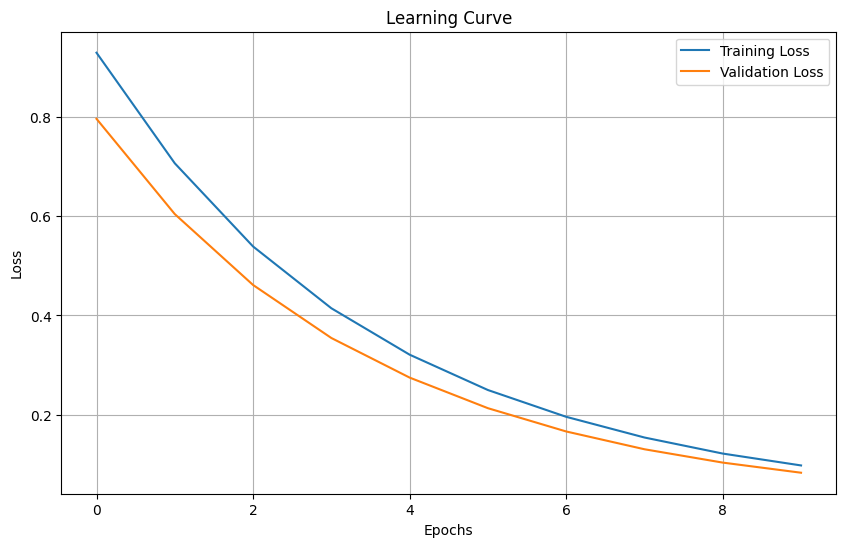

 > 0.104
0.10414880583992162


In [ ]:
df = pd.read_csv("Reindexed.csv")
series= df[['date', 'usdprice_Inter']]
series.set_index('date', inplace=True)
data= series.values 
# data split
n_test = 10                          
config =  [6, 50, 10, 6, 3] # optimal config 
ind_model= 1 # indicator for the model (1 - exp 1, 2- exp 2, 3 - exp 3 ) 
ind_plotcurve= True # T/F indicator for ploting learning curve 
scores= walk_forward_validation_LSTM_benchmark(data, n_test, config, ind_model, ind_plotcurve)
print(scores)


#### Experiment 2


Epoch 1/10


c:\Users\Kaidrin\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning:

Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.



30/30 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - loss: 1.5863 - val_loss: 0.9414
Epoch 2/10
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.8107 - val_loss: 0.4789
Epoch 3/10
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.4230 - val_loss: 0.2419
Epoch 4/10
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.2057 - val_loss: 0.1267
Epoch 5/10
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.1080 - val_loss: 0.0697
Epoch 6/10
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0531 - val_loss: 0.0386
Epoch 7/10
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0340 - val_loss: 0.0268
Epoch 8/10
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0319 - val_loss: 0.0182
Epoch 9/10
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0232 - val_loss: 0.0166
Epoch 10/10
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0307 - val_loss: 0.0139


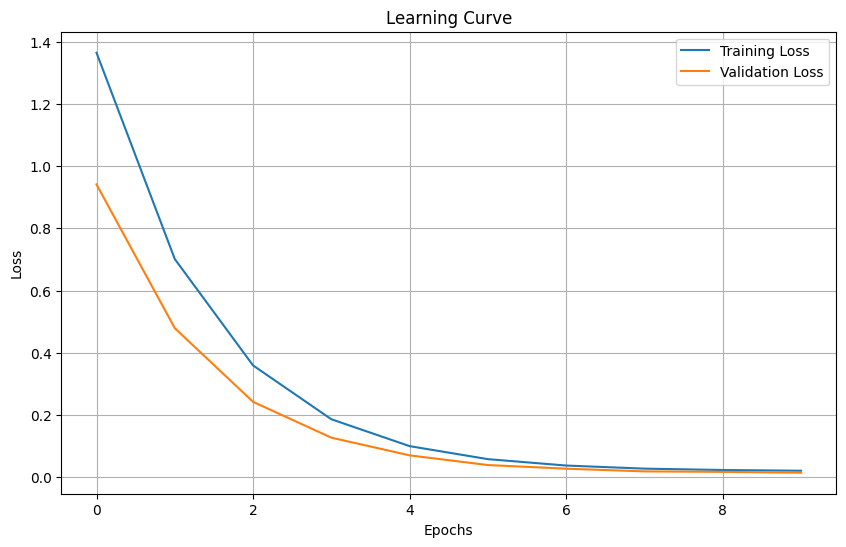

 > 0.105
0.10464571408614338


In [ ]:
df = pd.read_csv("Reindexed.csv")
series= df[['date', 'usdprice_Inter']]
series.set_index('date', inplace=True)
data= series.values 
# data split
n_test = 10                          
config =  [12, 50, 10, 3, 3] # optimal config
ind_model= 2 # indicator for the model (1 - exp 1, 2- exp 2, 3 - exp 3 ) 
ind_plotcurve= True # T/F indicator for ploting learning curve 
scores= walk_forward_validation_LSTM_benchmark(data, n_test, config, ind_model, ind_plotcurve)
print(scores)


#### Experiment 3 

Epoch 1/10


c:\Users\Kaidrin\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning:

Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.



16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - loss: 1.6967 - val_loss: 1.3016
Epoch 2/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 1.2126 - val_loss: 0.9081
Epoch 3/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.8415 - val_loss: 0.6314
Epoch 4/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.5891 - val_loss: 0.4387
Epoch 5/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.4113 - val_loss: 0.3053
Epoch 6/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.2831 - val_loss: 0.2128
Epoch 7/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.1975 - val_loss: 0.1479
Epoch 8/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.1543 - val_loss: 0.1061
Epoch 9/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0990 - val_loss: 0.0735
Epoch 10/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0682 - val_loss: 0.0539


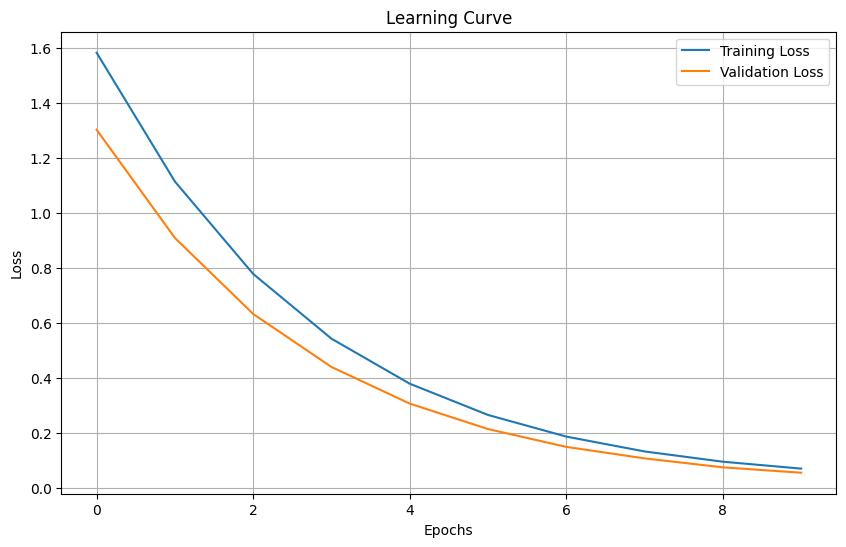

 > 0.107
0.10728585592154724


In [ ]:
df = pd.read_csv("Reindexed.csv")
df = df.replace(np.nan, 0)
series= df[['date', 'usdprice_Inter']]
series.set_index('date', inplace=True)
data= series.values 
# data split
n_test = 10                          
config =  [6, 50, 10, 6, 3] # optimal config 
ind_model= 3 # indicator for the model (1 - exp 1, 2- exp 2, 3 - exp 3 ) 
ind_plotcurve= True # T/F indicator for ploting learning curve 
scores= walk_forward_validation_LSTM_benchmark(data, n_test, config, ind_model, ind_plotcurve)
print(scores)


### 4.3. Visualization 

The best LSTM model was the basic one (experiment 1) with 1 LSTM layer with relu activation, 1 Dense and output layer.  This shows that more complex LSTM model requires data sample to pay off their advanced arhitecture. Intresting thing was that tanh activation function showed better performance than relu activation function on architecture shown in experiment 2 and 3. 

In the following part, it was shown visualizion of the actual and prediction valued using mentioned best LSTM model. 

Predicted trend shows ups and downs but there is a delay in timesteps if we compare it regarding to the actual trends. 


In [97]:
# walk-forward validation for univariate data
def walk_forward_validation_visualization(data,  cfg, n_test):
  predictions = []
  # split dataset
  train, test = train_test_split_ts(data, n_test)
  test_res = [x for x in test]
  # fit model
  model = model_fit_LSTM(train, cfg)
  # seed history with training dataset
  history = [x for x in train]
  # step over each time-step in the test set
  for i in range(len(test)):
    # fit model and make forecast for history
    yhat = model_predict_LSTM(model, history, cfg)
    # store forecast in list of predictions
    predictions.append(yhat)
    # add actual observation to history for the next loop
    history.append(test[i])
  # estimate prediction error
  error = measure_rmse(test_res, predictions)
  print(' > %.3f' % error)
  history_list = [float(array[0]) for array in history]
  predictions_ls= [float(array[0]) for array in predictions]

  return history_list,   history_list[:-12]+predictions_ls

c:\Users\Kaidrin\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning:

Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.



 > 0.057


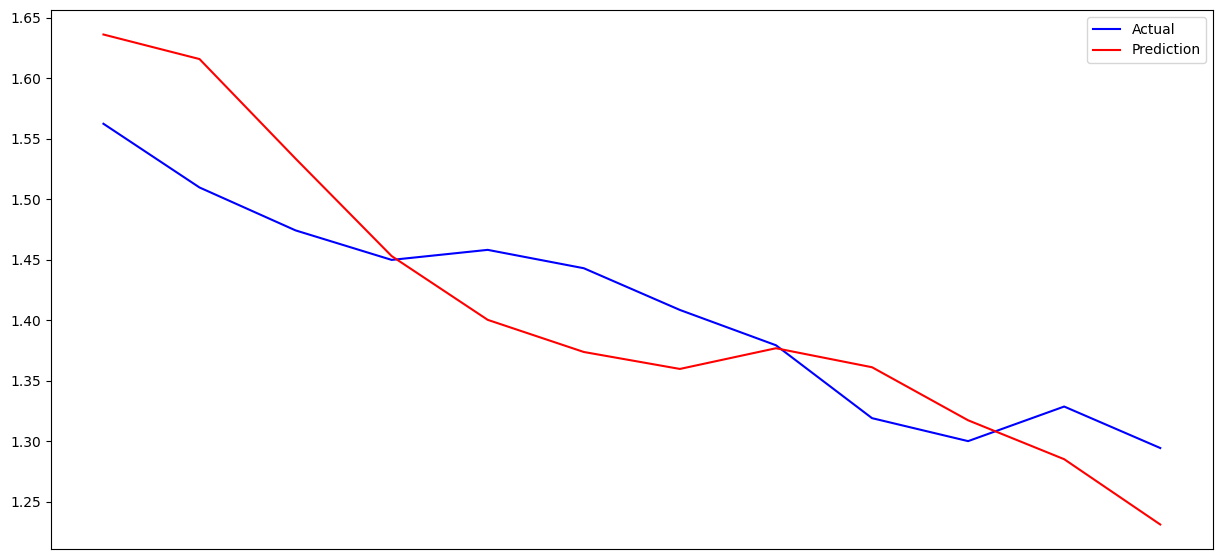

In [ ]:
df = pd.read_csv("Reindexed.csv")
series= df[['date', 'usdprice_Inter']]
series.set_index('date', inplace=True)
data= series.values 
# data split
n_test = 12
config=   [6, 50, 10, 6, 3]  # optimal config                                 
hist,  predictions = walk_forward_validation_visualization(data, config, n_test)
pyplot.plot(hist[-12: ], color='b', label= 'Actual')
pyplot.plot(predictions[-12: ], color='r', label='Prediction')
pyplot.xticks([])
pyplot.legend()
pyplot.show()
# As we can see from the plot the trends are following each other in similar direction 

### 4.4. Additional Experiments 

#### Data Scaling

Our time series data contains input values with varying scales, as significant jumps were observed during crises. 

To address this, I applied normalization using the MinMaxScaler from scikit-learn. MinMax scaler doesn’t reduce the effect of outliers, but it linearly scales them down into a fixed range (in our case (0, 1)), where the largest occurring data point corresponds to the maximum value and the smallest one corresponds to the minimum value.

After applying scaling, the RMSE error improved significantly and was the best among all models. We utilized Experiment 1 LSTM model, employing the configuration identified as the best-performing. 

In [99]:
# fit a model
def model_fit_LSTM(train, config):
  # unpack config
  n_input, n_nodes, n_epochs, n_batch, n_diff = config                          
  
  # prepare data                                                     
  if n_diff > 0:
    train = difference(train, n_diff)                                          
  data = series_to_supervised(train, n_input)
  
  train_x, train_y = data[:, :-1], data[:, -1]

  train_x = train_x.reshape((train_x.shape[0], train_x.shape[1], 1))
  # define model
  model = Sequential()                                                         
  model.add(LSTM(n_nodes, activation='relu', input_shape=(n_input, 1)))
  model.add(Dense(n_nodes, activation='relu'))
  model.add(Dense(1))
  model.compile(loss='mse', optimizer='adam')
  # fit
  model.fit(train_x, train_y, epochs=n_epochs, batch_size=n_batch, verbose=0)
  return model

# walk-forward validation for univariate data
def walk_forward_validation_LSTM_scaling(data, n_test, cfg):
  predictions = []
  # split dataset
  train, predict = train_test_split_ts(data, n_test)

  print('train in walk', train.shape)

  # train the normalization
  scaler = MinMaxScaler(feature_range=(0, 1))
  scaler = scaler.fit(train)
  # normalize the dataset
  normalized = scaler.transform(train)
  predict_scale= scaler.transform(predict)

  # fit model
  model = model_fit_LSTM(normalized, cfg)
  # seed history with training dataset
  history = [x for x in normalized]
  test_ls= [x for x in predict]
  # step over each time-step in the test set
  for i in range(len(predict)):
    # fit model and make forecast for history
    yhat = model_predict_LSTM(model, history, cfg)
    yhat= yhat.reshape((yhat.shape[0], 1))
    #inverse transformation 
    inversed = scaler.inverse_transform(yhat)
    #reshape for comparison for RMSE
    inv= inversed.reshape(-1)
    # store forecast in list of predictions
    predictions.append(inv)
    # add actual observation to history for the next loop
    history.append(predict_scale[i])
  # estimate prediction error

  error = measure_rmse_LSTM(predict, predictions)
  print(' > %.3f' % error)
  return error 

In [ ]:
from sklearn.preprocessing import MinMaxScaler
df = pd.read_csv("Reindexed.csv")
series= df[['date', 'usdprice_Inter']]
series.set_index('date', inplace=True)
data= series.values 

# data split
n_test= 10 
config =  [6, 50, 10, 6, 3] #optimal config
scores= walk_forward_validation_LSTM_scaling(data, n_test, config)
print(scores)

train in walk (110, 1)


c:\Users\Kaidrin\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning:

Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.



 > 0.049
0.048829432874979296


#### Training on new indicators 

Given that 'ewma' and 'rolling_3_mean' exhibit positive linear correlation (shown in the 1.2 Section), I will train the model on each of these indicators separately using LSTM Experiment 1, which demonstrated the best performance.

Training with the EWMA indicators slightly improves the results (0.102 RMSE ± 0.006), which can be attributed to the indicator's design for detecting trends and patterns. It adapts more quickly to changes, gives higher importance to recent data and handles volatility and trends more effectively which in our case its highly important since crisis started in last two years. 

On the other hand, the rolling 3-day mean performs worse ( 0.108 RMSE ± 0.006) since it relies on local trends. However, the model has already incorporated local trends through input reshaping.
 

In [107]:
# repeat evaluation of a config
def repeat_evaluate_LSTM_benchmark(data, n_test, config,  ind_model, ind_plotcurve, n_repeats=30):
  # fit and evaluate the model n times
  scores = [walk_forward_validation_LSTM_benchmark(data, n_test, config, ind_model, ind_plotcurve) for _ in range(n_repeats)]
  return scores


data (120, 1)


c:\Users\Kaidrin\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning:

Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.



 > 0.098


c:\Users\Kaidrin\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning:

Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.



 > 0.112


c:\Users\Kaidrin\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning:

Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.



 > 0.091


c:\Users\Kaidrin\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning:

Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.



 > 0.101


c:\Users\Kaidrin\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning:

Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.



 > 0.106


c:\Users\Kaidrin\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning:

Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.



 > 0.104


c:\Users\Kaidrin\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning:

Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.



 > 0.102


c:\Users\Kaidrin\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning:

Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.



 > 0.106


c:\Users\Kaidrin\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning:

Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.



 > 0.099


c:\Users\Kaidrin\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning:

Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.



 > 0.106
[0.09761198056446271, 0.11194165900113727, 0.09087476890151412, 0.10056617563167503, 0.10640267508951663, 0.10351327022660002, 0.10151214940573222, 0.10571316889613046, 0.09881763864044729, 0.10596831868274949]
LSTM: 0.102 RMSE (+/- 0.006)


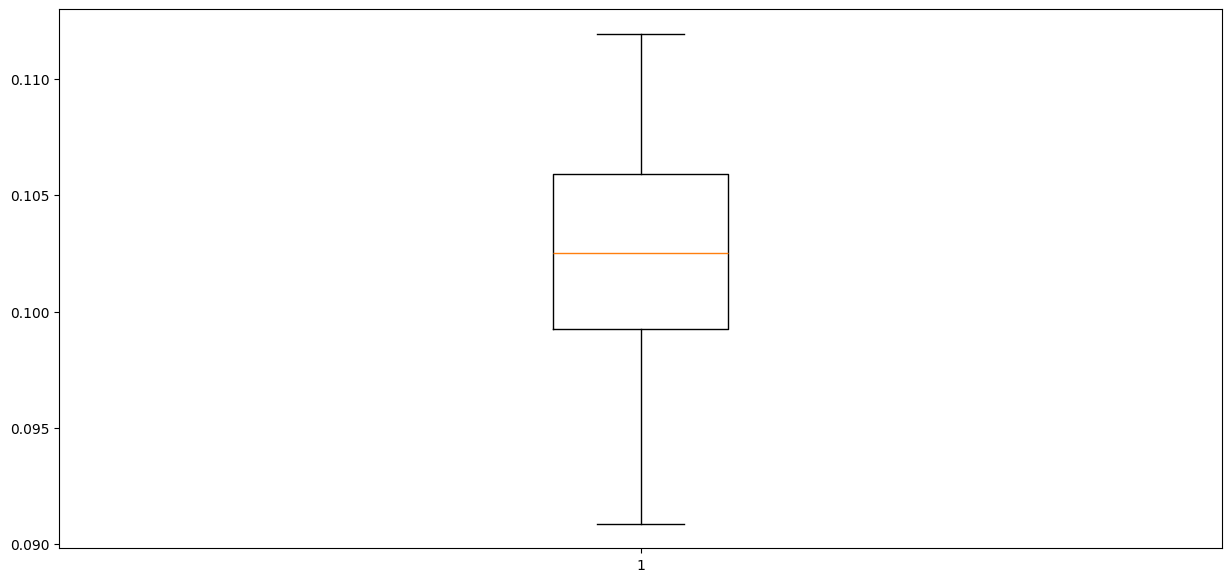

In [103]:
df = pd.read_csv("Reindexed.csv")
series= df[['date', 'ewma']]
series.set_index('date', inplace=True)
data= series.values 
print('data', data.shape)
# data split
n_test = 10
                                                
config =  [6, 50, 10, 6, 3]
ind_model= 1 # indicator for the model (1 - exp 1, 2- exp 2, 3 - exp 3 ) 
ind_plotcurve= False # T/F indicator for ploting learning curve 
scores = repeat_evaluate_LSTM_benchmark(data,  n_test, config,  ind_model, ind_plotcurve, 10)
print(scores)
# summarize scores
summarize_scores('LSTM', scores)



data (118, 1)


c:\Users\Kaidrin\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning:

Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.



 > 0.109


c:\Users\Kaidrin\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning:

Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.



 > 0.114


c:\Users\Kaidrin\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning:

Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.



 > 0.098


c:\Users\Kaidrin\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning:

Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.



 > 0.102


c:\Users\Kaidrin\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning:

Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.



 > 0.123


c:\Users\Kaidrin\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning:

Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.



 > 0.112


c:\Users\Kaidrin\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning:

Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.



 > 0.103


c:\Users\Kaidrin\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning:

Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.



 > 0.104


c:\Users\Kaidrin\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning:

Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.



 > 0.107


c:\Users\Kaidrin\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning:

Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.



 > 0.111
[0.10922809053144493, 0.11395778222322683, 0.09823007397209761, 0.10189103396777614, 0.1233569674762505, 0.11167525317959412, 0.10320756842489297, 0.10428742590746708, 0.10701826780559855, 0.1111387917936888]
LSTM: 0.108 RMSE (+/- 0.007)


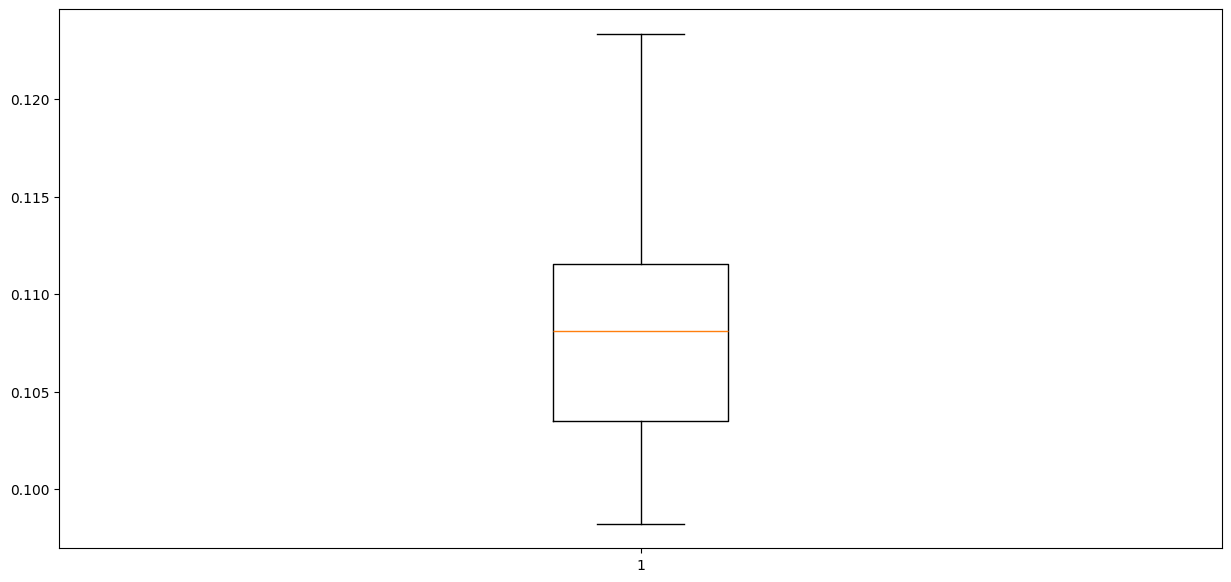

In [ ]:
df = pd.read_csv("Reindexed.csv")
#df = df.replace(np.nan, 0)
series= df[['date', 'rolling_3_mean']]
series.set_index('date', inplace=True)
series = series[(series != 0).all(axis=1)]
data= series.values 
print('data', data.shape)
# data split
n_test = 10                                              
config =  [12, 15, 10, 6, 3]
ind_model= 1 # indicator for the model (1 - exp 1, 2- exp 2, 3 - exp 3 ) 
ind_plotcurve= False # T/F indicator for ploting learning curve 
scores = repeat_evaluate_LSTM_benchmark(data,  n_test, config,  ind_model, ind_plotcurve, 10)
print(scores)
# summarize scores
summarize_scores('LSTM', scores)



## Conclusion 
 
- The MLP model proves to be challenging to outperform in terms of performance.


- Among LSTM models, the simplest architecture with a single LSTM layer outperforms more complex stacked LSTM configurations.

- Further improvements will likely require incorporating multivariate analysis, utilizing multiple features for each time step. Given the dataset includes crisis periods, it will be essential to include features such as economic indices, safety indices, and similar indicators.

- This analysis demonstrates that the best performance is achieved when data is scaled, making data scaling the foundational approach to begin with, no matter which model or architecture is used.